In [1]:
# buat visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# manipulasi data
import numpy as np
import pandas as pd

# preprosessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# buat pipe line
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model
from sklearn.ensemble import GradientBoostingRegressor

# evaluasi
from sklearn.metrics import make_scorer, mean_squared_error

c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#variabel konstan
CV_FOLDS = 3
N_ITER = 10
VERBOSITY = 5
RANDOM_STATE = 2049

In [3]:
#load datasets
data_path = '../data/'

# Load dataset

In [4]:
# Loading training dataset
train_data = pd.read_csv(data_path + "train.csv")

# Loading test dataset
test_data = pd.read_csv(data_path + "test.csv")

## Cek Missing

In [5]:
def identify_missing_values(data):
    """Menghitung missing values"""
    # validasi kolom yang ada missing
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]

    # buat table untuk nampung perhitungan nilai missing
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )
    
    # masukan nilai perhitungan kedalam table yang sebelumnya dibuat 
    nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
    nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)
    nans_df["dtype"] = data[nans_df.index].dtypes
    nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

    return nans_df

In [6]:
# Computing missing values
miss_vals = identify_missing_values(data=train_data)

In [7]:
miss_vals

dtype  missing_count  missing_fraction
PoolQC         object           1453            0.9952
MiscFeature    object           1406            0.9630
Alley          object           1369            0.9377
Fence          object           1179            0.8075
FireplaceQu    object            690            0.4726
LotFrontage   float64            259            0.1774
GarageType     object             81            0.0555
GarageYrBlt   float64             81            0.0555
GarageFinish   object             81            0.0555
GarageQual     object             81            0.0555
GarageCond     object             81            0.0555
BsmtExposure   object             38            0.0260
BsmtFinType2   object             38            0.0260
BsmtFinType1   object             37            0.0253
BsmtCond       object             37            0.0253
BsmtQual       object             37            0.0253
MasVnrArea    float64              8            0.0055
MasVnrType     object              8            0.0055
Electrical     object              1            0.0007

In [8]:
# nampilin data missing yang numeric
miss_vals[miss_vals['dtype'] != "object"]

dtype  missing_count  missing_fraction
LotFrontage  float64            259            0.1774
GarageYrBlt  float64             81            0.0555
MasVnrArea   float64              8            0.0055

In [9]:
# mengisi missing value
train_data[['MasVnrArea','LotFrontage']] = train_data[['MasVnrArea','LotFrontage']].fillna(train_data[['MasVnrArea','LotFrontage']].median())
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean())

In [10]:
# cek lagi
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals['dtype'] != "object"]

Empty DataFrame
Columns: [dtype, missing_count, missing_fraction]
Index: []

In [11]:
# nampilin data missing yang object
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals["dtype"] == "object"]

dtype  missing_count  missing_fraction
PoolQC        object           1453            0.9952
MiscFeature   object           1406            0.9630
Alley         object           1369            0.9377
Fence         object           1179            0.8075
FireplaceQu   object            690            0.4726
GarageType    object             81            0.0555
GarageFinish  object             81            0.0555
GarageQual    object             81            0.0555
GarageCond    object             81            0.0555
BsmtExposure  object             38            0.0260
BsmtFinType2  object             38            0.0260
BsmtQual      object             37            0.0253
BsmtCond      object             37            0.0253
BsmtFinType1  object             37            0.0253
MasVnrType    object              8            0.0055
Electrical    object              1            0.0007

In [12]:
# apus kolom dengan missing values lebih dari 70%
train_data = train_data.drop(miss_vals[miss_vals.missing_fraction > 0.7].index.tolist(),1)

C:\Users\RanggaSaputra\AppData\Local\Temp\ipykernel_23104\2773110458.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_data = train_data.drop(miss_vals[miss_vals.missing_fraction > 0.7].index.tolist(),1)


In [13]:
# cek lagi
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals["dtype"] == "object"]

dtype  missing_count  missing_fraction
FireplaceQu   object            690            0.4726
GarageType    object             81            0.0555
GarageFinish  object             81            0.0555
GarageQual    object             81            0.0555
GarageCond    object             81            0.0555
BsmtExposure  object             38            0.0260
BsmtFinType2  object             38            0.0260
BsmtQual      object             37            0.0253
BsmtCond      object             37            0.0253
BsmtFinType1  object             37            0.0253
MasVnrType    object              8            0.0055
Electrical    object              1            0.0007

In [14]:
# Dropping NaN-values in columns with small shares
cols_to_fillna = miss_vals.index
train_data.fillna(train_data.mode().iloc[0], inplace=True)

In [15]:
# cek lagi
miss_vals = identify_missing_values(data=train_data)
miss_vals[miss_vals["dtype"] == "object"]

Empty DataFrame
Columns: [dtype, missing_count, missing_fraction]
Index: []

In [16]:
train_data_num = train_data.select_dtypes(include=['int64', 'float64'])
train_data_num.head(2)

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   

   SalePrice  
0     208500  
1     181500  

[2 rows x 38 columns]

## cari korelasi yang lebih dari 0.4

In [17]:
train_data_num_corr =train_data_num.corr()['SalePrice'][:-1]
best_featur = train_data_num_corr[abs(train_data_num_corr)>0.4].sort_values(ascending=False)

In [18]:
print(f"There Are {len(best_featur)} Best Features with SalePrice \n\n{best_featur}")

There Are 13 Best Features with SalePrice 

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
GarageYrBlt     0.470177
Fireplaces      0.466929
Name: SalePrice, dtype: float64


In [19]:
best_featur.index

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'GarageYrBlt', 'Fireplaces'],
      dtype='object')

In [20]:
best_num_featurelist = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'MasVnrArea', 'Fireplaces','SalePrice']

train_data_num_featur = train_data.loc[:, best_num_featurelist].copy()

In [21]:
train_data_num_featur.head()

OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  1stFlrSF  \
0            7       1710           2         548          856       856   
1            6       1262           2         460         1262      1262   
2            7       1786           2         608          920       920   
3            7       1717           3         642          756       961   
4            8       2198           3         836         1145      1145   

   FullBath  TotRmsAbvGrd  YearBuilt  YearRemodAdd  GarageYrBlt  MasVnrArea  \
0         2             8       2003          2003       2003.0       196.0   
1         2             6       1976          1976       1976.0         0.0   
2         2             6       2001          2002       2001.0       162.0   
3         1             7       1915          1970       1998.0         0.0   
4         2             9       2000          2000       2000.0       350.0   

   Fireplaces  SalePrice  
0           0     208500  
1           1     181500  
2           1     223500  
3           1     140000  
4           1     250000

## Buat cek korelasi ke sales price

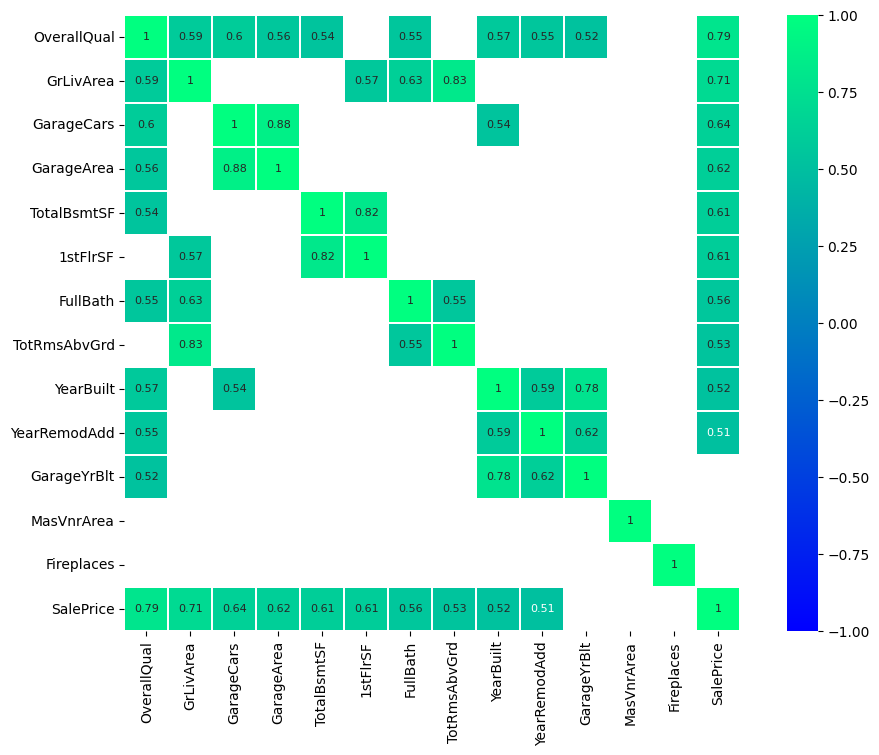

In [22]:
corr = train_data_num_featur.corr()
paper=plt.figure(figsize=(12,8))
sns.heatmap(corr[(corr>=0.5) |(corr<= -0.4)] ,
            cmap='winter', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.show()

diapus karena tidak ada korelasi sama salesprice

In [23]:
train_data_num_featur = train_data_num_featur.drop(['GarageYrBlt', 'MasVnrArea', 'Fireplaces'], axis=1)

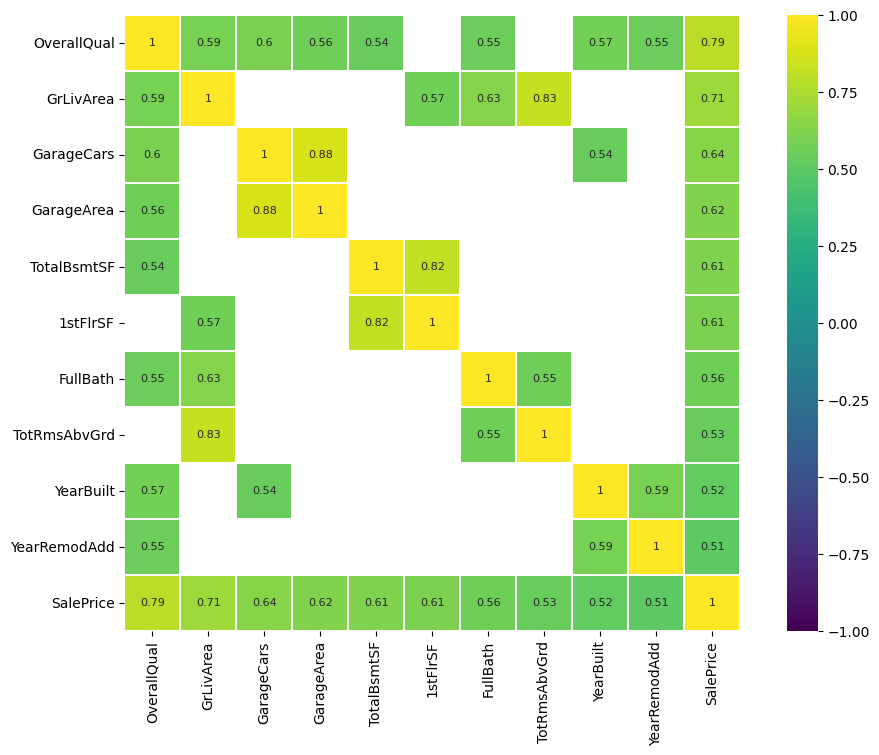

In [24]:
corr = train_data_num_featur.corr()
paper=plt.figure(figsize=(12,8))
sns.heatmap(corr[(corr>=0.5) |(corr<= -0.4)] ,
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.show()

## olah data kategori

In [25]:
train_data_cat = train_data.select_dtypes(include=['object'])
train_data_cat.head(2)

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave      Reg         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1 Condition2  ... KitchenQual Functional FireplaceQu  \
0      CollgCr       Norm       Norm  ...          Gd        Typ          Gd   
1      Veenker      Feedr       Norm  ...          TA        Typ          TA   

  GarageType GarageFinish GarageQual GarageCond PavedDrive SaleType  \
0     Attchd          RFn         TA         TA          Y       WD   
1     Attchd          RFn         TA         TA          Y       WD   

  SaleCondition  
0        Normal  
1        Normal  

[2 rows x 39 columns]

In [26]:
train_data_cat.nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

Drop yang kebanyak dimensi

In [27]:
train_data_cat.drop(columns=['Neighborhood'], inplace = True)

In [28]:
threshold = 0.70  # tetapkan ambang batas

'''
hitung frekuensi banyaknya suatu kategori
ini digunakan agar data tidak menjadi homogen
'''
category_counts = train_data_cat.apply(lambda col: col.value_counts().max() / len(col))

# pisahkan dari setiap fitur data
unrelevant_columns = category_counts[category_counts > threshold].index
relevant_columns = category_counts[category_counts < threshold].index

In [29]:
# banyaknya data yang baik digunakan
print(train_data_cat[relevant_columns].shape)
print(f'Numerical {train_data_num_featur.shape}')

(1460, 14)
Numerical (1460, 11)


In [30]:
relevant_columns = train_data[relevant_columns]

## Seleksi Fitur

In [31]:
# buat data train berdasarkan fitur yang sudah di filter
train_data_best = pd.concat([relevant_columns, train_data_num_featur], axis=1)
train_data_best

LotShape HouseStyle Exterior1st Exterior2nd MasVnrType ExterQual  \
0         Reg     2Story     VinylSd     VinylSd    BrkFace        Gd   
1         Reg     1Story     MetalSd     MetalSd       None        TA   
2         IR1     2Story     VinylSd     VinylSd    BrkFace        Gd   
3         IR1     2Story     Wd Sdng     Wd Shng       None        TA   
4         IR1     2Story     VinylSd     VinylSd    BrkFace        Gd   
...       ...        ...         ...         ...        ...       ...   
1455      Reg     2Story     VinylSd     VinylSd       None        TA   
1456      Reg     1Story     Plywood     Plywood      Stone        TA   
1457      Reg     2Story     CemntBd     CmentBd       None        Ex   
1458      Reg     1Story     MetalSd     MetalSd       None        TA   
1459      Reg     1Story     HdBoard     HdBoard       None        Gd   

     Foundation BsmtQual BsmtExposure BsmtFinType1  ... GrLivArea GarageCars  \
0         PConc       Gd           No          GLQ  ...      1710          2   
1        CBlock       Gd           Gd          ALQ  ...      1262          2   
2         PConc       Gd           Mn          GLQ  ...      1786          2   
3        BrkTil       TA           No          ALQ  ...      1717          3   
4         PConc       Gd           Av          GLQ  ...      2198          3   
...         ...      ...          ...          ...  ...       ...        ...   
1455      PConc       Gd           No          Unf  ...      1647          2   
1456     CBlock       Gd           No          ALQ  ...      2073          2   
1457      Stone       TA           No          GLQ  ...      2340          1   
1458     CBlock       TA           Mn          GLQ  ...      1078          1   
1459     CBlock       TA           No          BLQ  ...      1256          1   

     GarageArea TotalBsmtSF  1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  \
0           548         856       856         2             8       2003   
1           460        1262      1262         2             6       1976   
2           608         920       920         2             6       2001   
3           642         756       961         1             7       1915   
4           836        1145      1145         2             9       2000   
...         ...         ...       ...       ...           ...        ...   
1455        460         953       953         2             7       1999   
1456        500        1542      2073         2             7       1978   
1457        252        1152      1188         2             9       1941   
1458        240        1078      1078         1             5       1950   
1459        276        1256      1256         1             6       1965   

      YearRemodAdd  SalePrice  
0             2003     208500  
1             1976     181500  
2             2002     223500  
3             1970     140000  
4             2000     250000  
...            ...        ...  
1455          2000     175000  
1456          1988     210000  
1457          2006     266500  
1458          1996     142125  
1459          1965     147500  

[1460 rows x 25 columns]

In [32]:
train_data_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LotShape      1460 non-null   object
 1   HouseStyle    1460 non-null   object
 2   Exterior1st   1460 non-null   object
 3   Exterior2nd   1460 non-null   object
 4   MasVnrType    1460 non-null   object
 5   ExterQual     1460 non-null   object
 6   Foundation    1460 non-null   object
 7   BsmtQual      1460 non-null   object
 8   BsmtExposure  1460 non-null   object
 9   BsmtFinType1  1460 non-null   object
 10  HeatingQC     1460 non-null   object
 11  KitchenQual   1460 non-null   object
 12  GarageType    1460 non-null   object
 13  GarageFinish  1460 non-null   object
 14  OverallQual   1460 non-null   int64 
 15  GrLivArea     1460 non-null   int64 
 16  GarageCars    1460 non-null   int64 
 17  GarageArea    1460 non-null   int64 
 18  TotalBsmtSF   1460 non-null   int64 
 19  1stFlr

## Cek persebaran data test

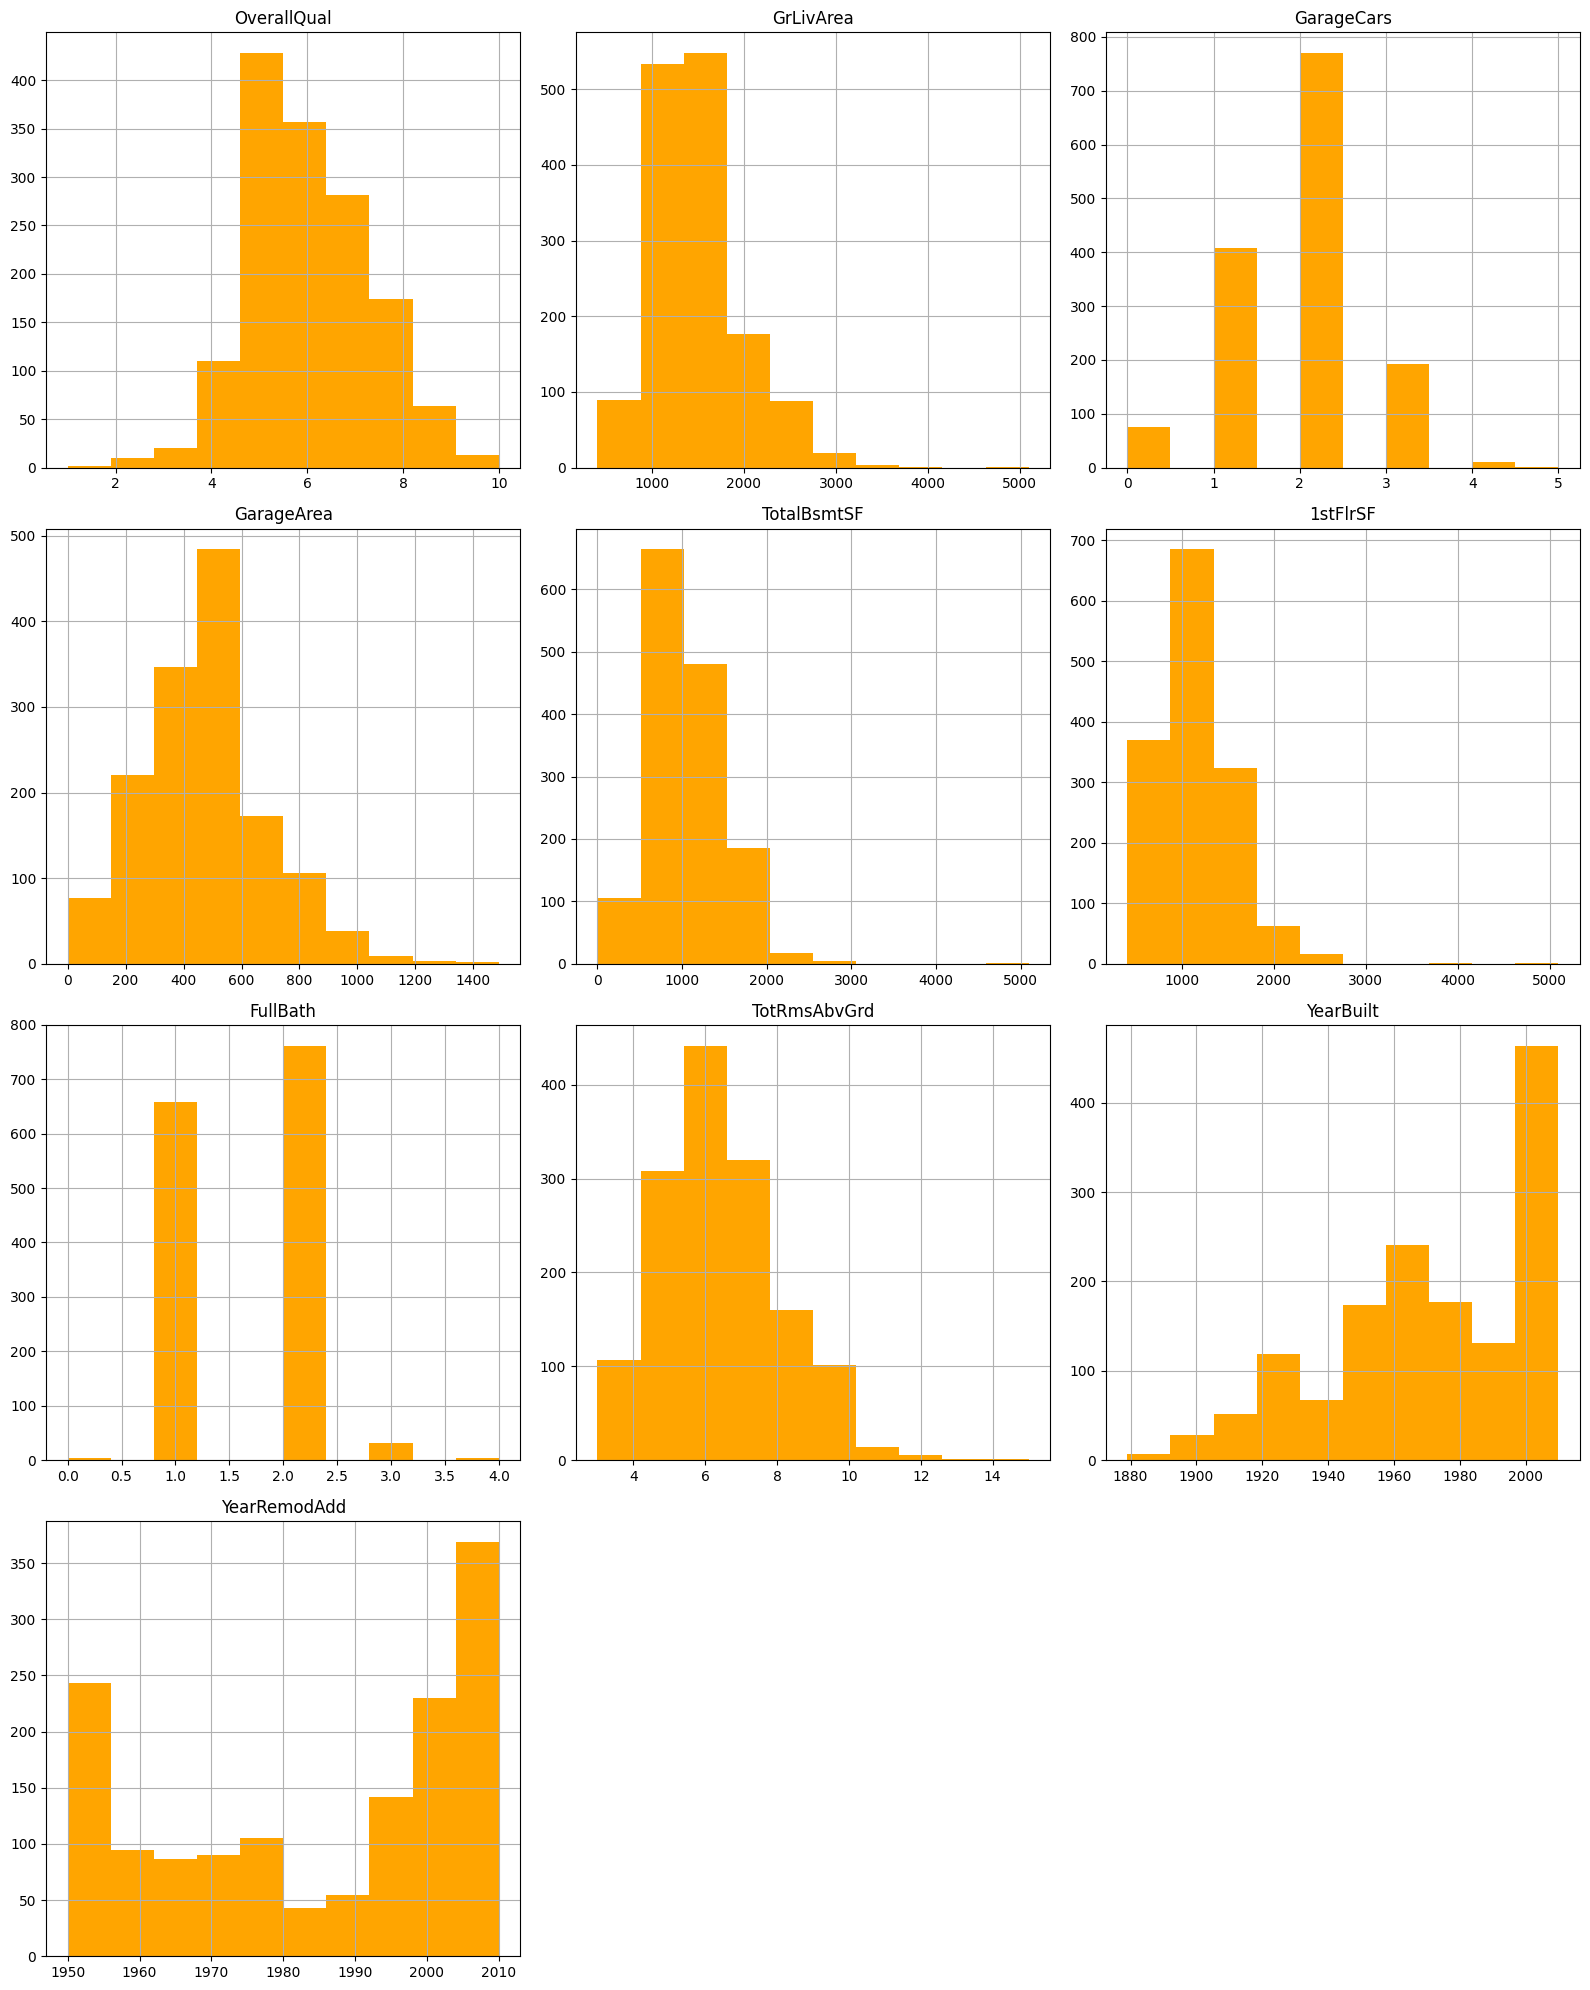

In [33]:
train_data_cols = train_data_best.drop(["SalePrice"], axis=1).columns
test_data[train_data_cols].hist(figsize=(16, 20), color="orange")
plt.tight_layout()
plt.show()

## Cek missing values di test data

In [34]:
# cek missing value
identify_missing_values(data=test_data[train_data_cols])

dtype  missing_count  missing_fraction
GarageFinish   object             78            0.0535
GarageType     object             76            0.0521
BsmtQual       object             44            0.0302
BsmtExposure   object             44            0.0302
BsmtFinType1   object             42            0.0288
MasVnrType     object             16            0.0110
Exterior1st    object              1            0.0007
Exterior2nd    object              1            0.0007
KitchenQual    object              1            0.0007
GarageCars    float64              1            0.0007
GarageArea    float64              1            0.0007
TotalBsmtSF   float64              1            0.0007

## Buat pipeline

In [35]:
# Pisahkan fitur kategori, fitur ordinal, fitur numerik
fitur_numerik = ['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']
fitur_ordinal = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual']
fitur_kategori = ['LotShape',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'GarageType',
 'GarageFinish']

In [36]:
# Daftar urutan kategori
order_qual_BsmtQual = ['Ex', 'Gd', 'Ta', 'Fa']
order_qual_BsmtExposure = ['Gd', 'Av', 'Mn', 'No']
order_qual_BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf']
order_qual_HeatingQC = ['Ex', 'Gd', 'Ta', 'Fa', 'Po']
order_qual_KitchenQual = ['Ex', 'Gd', 'Ta', 'Fa']

# untuk tranformasi dan preprosessing data
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[order_qual_BsmtQual, order_qual_BsmtExposure, 
                                               order_qual_BsmtFinType1, order_qual_HeatingQC, 
                                               order_qual_KitchenQual], 
                                               handle_unknown='use_encoded_value',
                                               unknown_value=np.nan), 
                                               fitur_ordinal),
        ('onehot', OneHotEncoder(drop="first",
                                 handle_unknown='ignore'), 
                                 fitur_kategori),
        ('scaler', StandardScaler(), fitur_numerik)  # Standarisasi data numerik
    ])

# Buat langkah dalam pipeline
steps = [
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mengisi missing values dengan nilai yang paling sering muncul
]

## Buat evalusi

In [37]:
def rmse_log_scorer(y_true, y_pred):
    """Computes RMSE between log predictions and log true values."""
    # Computing logarithms of true and predicted values
    log_y_true = np.log(y_true)
    log_y_pred = np.log(y_pred)
    
    # Computing RMSE for logs
    rmse_score = mean_squared_error(
        y_true=log_y_true, y_pred=log_y_pred, squared=False
    )
    
    return rmse_score

In [38]:
rmse_scorer = make_scorer(rmse_log_scorer, greater_is_better=False)

In [39]:
target_train = train_data["SalePrice"]

features_train = train_data.drop(["SalePrice"], axis=1)

features_test = test_data[features_train.columns]

## bagi data test dan train

In [68]:
from sklearn.model_selection import train_test_split

# Bagi data Anda menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

## Untuk memilih algoritma terbaik

lazypredict itu gabungan dari banyak algoritma jadi kita ngg usah test satu satu

In [71]:
from lazypredict.Supervised import LazyRegressor

# melihat referensi model yang bisa digunakan
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models_reg, predictions_reg = reg.fit(X_train, X_test, y_train, y_test)
models_reg.sort_values(by='R-Squared', ascending=False)

100%|██████████| 42/42 [01:49<00:00,  2.61s/it]


Adjusted R-Squared  \
Model                                                                              
GradientBoostingRegressor                                                   0.86   
PoissonRegressor                                                            0.86   
RandomForestRegressor                                                       0.86   
HistGradientBoostingRegressor                                               0.85   
LGBMRegressor                                                               0.85   
LassoLars                                                                   0.85   
Lasso                                                                       0.85   
LassoLarsIC                                                                 0.85   
HuberRegressor                                                              0.84   
BaggingRegressor                                                            0.84   
TransformedTargetRegressor                                                  0.84   
LinearRegression                                                            0.84   
OrthogonalMatchingPursuit                                                   0.83   
KernelRidge                                                                 0.83   
Ridge                                                                       0.83   
ExtraTreesRegressor                                                         0.83   
LassoCV                                                                     0.82   
PassiveAggressiveRegressor                                                  0.82   
LassoLarsCV                                                                 0.82   
XGBRegressor                                                                0.82   
GammaRegressor                                                              0.81   
RidgeCV                                                                     0.81   
BayesianRidge                                                               0.81   
OrthogonalMatchingPursuitCV                                                 0.81   
LarsCV                                                                      0.78   
SGDRegressor                                                                0.77   
AdaBoostRegressor                                                           0.77   
ElasticNet                                                                  0.76   
TweedieRegressor                                                            0.73   
KNeighborsRegressor                                                         0.69   
DecisionTreeRegressor                                                       0.68   
ExtraTreeRegressor                                                          0.63   
RANSACRegressor                                                             0.43   
ElasticNetCV                                                               -0.18   
DummyRegressor                                                             -0.35   
NuSVR                                                                      -0.36   
SVR                                                                        -0.39   
QuantileRegressor                                                          -0.39   
LinearSVR                                                                  -0.48   
MLPRegressor                                                               -5.06   
GaussianProcessRegressor                                                   -5.94   
Lars                          -3142503545922004009879640257723873173169642677...   

                                                                       R-Squared  \
Model                                                                              
GradientBoostingRegressor                                                   0.90   
PoissonRegressor                                                            0.90   
RandomForestRegressor        

GradientBoostingRegressor memiliki nilai R-Squared yang tinggi, RMSE yang rendah, dan waktu pelatihan yang wajar (1.46 detik). Oleh karena itu, model ini bisa menjadi pilihan yang baik.

## satukan algoritma dengan pipe line

In [40]:
gbr_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
steps.append(('Gbr', gbr_model))

gbr_pipeline = Pipeline(steps)

gbr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Ex',
                                                                              'Gd',
                                                                              'Ta',
                                                                              'Fa'],
                                                                             ['Gd',
                                                                              'Av',
                                                                              'Mn',
                                                                              'No'],
                                                                             ['GLQ',
                                                                              'ALQ',
                                                                              'BLQ',
                                                                              'Rec',
                                                                              'LwQ',
                                                                              'Unf'],
                                                                             ['Ex',
                                                                              'Gd',
                                                                              'Ta',
                                                                              'Fa',
                                                                              'Po'],
                                                                             ['Ex',
                                                                              'Gd',
                                                                              'Ta',
                                                                              'Fa']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['BsmtQual', 'BsmtExposure',
                                                   'BsmtFinType1', 'HeatingQC',
                                                   'Kitchen...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'Foundation', 'GarageType',
                                                   'GarageFinish']),
                                                 ('scaler', StandardScaler(),
                                                  ['OverallQual', 'GrLivArea',
                                                   'GarageCars', 'GarageArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'FullBath', 'TotRmsAbvGrd',
                                                   'YearBuilt',
                                                   'YearRemodAdd'])])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('Gbr', GradientBoostingRegressor(random_state=2049))])

## tuning parameter

In [43]:
param_dist = {
    'Gbr__n_estimators': np.arange(50, 300, 10),
    'Gbr__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'Gbr__max_depth': np.arange(2, 16, 2),
    'Gbr__min_samples_leaf': np.arange(30,71,10),
    'Gbr__n_iter_no_change': np.arange(1,6),
    'Gbr__random_state': 2049,
}

In [47]:
# Instantiating a RSCV object
gbr_grid_search = GridSearchCV(
    estimator=gbr_pipeline,
    param_grid=param_dist,
    scoring=rmse_scorer,
    cv=CV_FOLDS,
    verbose=VERBOSITY,
    return_train_score=True,
)

## lakukan eksekusi model

In [48]:
# Launching randomized grid search algorithm 
gbr_grid_search.fit(features_train, target_train)

# Menampilkan hasil terbaik dari pencarian acak
print("Best Parameters: ", gbr_grid_search.best_params_)
print("Best Score (RMSE): ", -gbr_grid_search.best_score_)

Fitting 3 folds for each of 3500 candidates, totalling 10500 fits
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.316, test=-0.316) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.311, test=-0.328) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.321, test=-0.310) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.304, test=-0.304) total time=   0.0s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.298, test=-0.316) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.308, test=-0.298) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.292, test=-0.292) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.286, test=-0.305) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.296, test=-0.288) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.282, test=-0.281) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.275, test=-0.295) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.285, test=-0.278) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.272, test=-0.271) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.266, test=-0.286) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.276, test=-0.269) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.264, test=-0.262) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.257, test=-0.278) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.267, test=-0.261) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.256, test=-0.254) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.249, test=-0.271) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.259, test=-0.254) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.249, test=-0.246) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.241, test=-0.264) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.251, test=-0.247) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.242, test=-0.240) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.234, test=-0.258) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.244, test=-0.241) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.237, test=-0.233) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.228, test=-0.253) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.238, test=-0.235) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.231, test=-0.228) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.222, test=-0.248) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.232, test=-0.230) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.226, test=-0.222) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.217, test=-0.243) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.226, test=-0.225) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.221, test=-0.217) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.212, test=-0.239) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.221, test=-0.221) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.217, test=-0.212) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.207, test=-0.234) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.216, test=-0.217) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.213, test=-0.208) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.202, test=-0.230) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.212, test=-0.213) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.209, test=-0.204) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.198, test=-0.226) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.207, test=-0.209) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.205, test=-0.200) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.194, test=-0.223) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.203, test=-0.205) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.202, test=-0.197) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.191, test=-0.220) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.200, test=-0.202) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.199, test=-0.194) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.187, test=-0.216) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.196, test=-0.199) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.196, test=-0.190) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.184, test=-0.213) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.193, test=-0.197) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.193, test=-0.187) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.181, test=-0.210) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.190, test=-0.194) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.190, test=-0.185) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.178, test=-0.208) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.187, test=-0.192) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.187, test=-0.182) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.176, test=-0.206) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.184, test=-0.190) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.185, test=-0.180) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.173, test=-0.203) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.182, test=-0.188) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.183, test=-0.177) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.171, test=-0.201) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.179, test=-0.186) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.317, test=-0.316) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.311, test=-0.329) total time=   0.0s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.321, test=-0.310) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.304, test=-0.303) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.298, test=-0.316) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.308, test=-0.298) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.293, test=-0.292) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.286, test=-0.305) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.296, test=-0.287) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.282, test=-0.281) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.276, test=-0.295) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.285, test=-0.278) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.272, test=-0.271) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.266, test=-0.286) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.276, test=-0.269) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.264, test=-0.262) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.257, test=-0.278) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.267, test=-0.261) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.256, test=-0.254) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.249, test=-0.271) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.259, test=-0.253) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.249, test=-0.246) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.241, test=-0.264) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.251, test=-0.247) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.243, test=-0.239) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.234, test=-0.258) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.244, test=-0.241) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.237, test=-0.233) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.228, test=-0.253) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.238, test=-0.235) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.231, test=-0.227) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.222, test=-0.247) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.232, test=-0.230) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.226, test=-0.222) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.216, test=-0.242) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.227, test=-0.225) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.222, test=-0.218) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.211, test=-0.238) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.221, test=-0.221) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.218, test=-0.213) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.206, test=-0.233) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.217, test=-0.217) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.213, test=-0.209) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.202, test=-0.229) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.212, test=-0.213) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.210, test=-0.205) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.198, test=-0.226) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.208, test=-0.209) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.206, test=-0.201) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.194, test=-0.222) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.204, test=-0.206) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.203, test=-0.198) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.190, test=-0.219) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.200, test=-0.203) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.199, test=-0.194) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.187, test=-0.216) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.197, test=-0.200) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.196, test=-0.191) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.184, test=-0.213) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.194, test=-0.197) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.194, test=-0.188) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.181, test=-0.210) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.191, test=-0.195) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.191, test=-0.186) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.178, test=-0.208) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.188, test=-0.193) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.188, test=-0.183) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.176, test=-0.205) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.186, test=-0.191) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.186, test=-0.180) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.174, test=-0.203) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.183, test=-0.189) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.184, test=-0.178) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.171, test=-0.201) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.181, test=-0.187) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.317, test=-0.316) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.311, test=-0.329) total time=   0.0s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.321, test=-0.310) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.304, test=-0.303) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.298, test=-0.317) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.308, test=-0.298) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.293, test=-0.292) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.286, test=-0.305) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.296, test=-0.288) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.282, test=-0.281) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.275, test=-0.295) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.285, test=-0.278) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.272, test=-0.271) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.266, test=-0.286) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.276, test=-0.270) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.264, test=-0.262) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.257, test=-0.278) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.267, test=-0.262) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.256, test=-0.254) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.249, test=-0.271) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.259, test=-0.254) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.249, test=-0.246) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.242, test=-0.265) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.251, test=-0.248) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.242, test=-0.240) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.235, test=-0.258) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.245, test=-0.242) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.237, test=-0.233) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.228, test=-0.253) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.238, test=-0.236) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.231, test=-0.228) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.223, test=-0.248) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.233, test=-0.231) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.227, test=-0.223) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.217, test=-0.243) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.227, test=-0.226) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.222, test=-0.218) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.212, test=-0.238) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.222, test=-0.222) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.218, test=-0.213) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.207, test=-0.234) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.218, test=-0.218) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.214, test=-0.209) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.202, test=-0.230) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.213, test=-0.214) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.210, test=-0.205) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.198, test=-0.226) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.209, test=-0.210) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.206, test=-0.201) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.194, test=-0.223) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.205, test=-0.207) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.203, test=-0.197) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.191, test=-0.219) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.201, test=-0.204) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.199, test=-0.194) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.188, test=-0.217) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.198, test=-0.201) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.196, test=-0.191) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.185, test=-0.214) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.195, test=-0.198) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.193, test=-0.188) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.182, test=-0.211) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.192, test=-0.196) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.190, test=-0.185) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.180, test=-0.209) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.189, test=-0.194) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.188, test=-0.183) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.177, test=-0.206) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.186, test=-0.191) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.185, test=-0.180) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.175, test=-0.204) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.184, test=-0.190) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.183, test=-0.178) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.172, test=-0.202) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.182, test=-0.188) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.317, test=-0.317) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.311, test=-0.330) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.321, test=-0.310) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.304, test=-0.305) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.298, test=-0.317) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.308, test=-0.298) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.293, test=-0.293) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.286, test=-0.306) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.296, test=-0.287) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.282, test=-0.282) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.276, test=-0.296) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.285, test=-0.278) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.273, test=-0.272) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.266, test=-0.287) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.276, test=-0.269) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.264, test=-0.263) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.257, test=-0.278) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.267, test=-0.262) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.256, test=-0.254) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.249, test=-0.271) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.259, test=-0.254) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.249, test=-0.247) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.242, test=-0.265) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.252, test=-0.248) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.243, test=-0.240) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.235, test=-0.259) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.245, test=-0.242) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.237, test=-0.234) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.229, test=-0.254) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.239, test=-0.237) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.232, test=-0.229) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.223, test=-0.249) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.233, test=-0.232) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.227, test=-0.224) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.218, test=-0.244) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.228, test=-0.227) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.223, test=-0.219) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.213, test=-0.239) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.223, test=-0.223) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.219, test=-0.215) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.208, test=-0.235) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.219, test=-0.219) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.215, test=-0.211) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.203, test=-0.231) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.214, test=-0.215) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.211, test=-0.207) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.200, test=-0.227) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.210, test=-0.211) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.208, test=-0.203) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.196, test=-0.224) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.206, test=-0.208) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.205, test=-0.200) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.193, test=-0.221) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.202, test=-0.205) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.201, test=-0.196) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.189, test=-0.218) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.199, test=-0.202) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.198, test=-0.193) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.186, test=-0.215) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.196, test=-0.199) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.195, test=-0.190) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.184, test=-0.212) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.193, test=-0.197) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.192, test=-0.187) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.181, test=-0.210) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.190, test=-0.195) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.190, test=-0.185) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.178, test=-0.207) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.188, test=-0.193) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.187, test=-0.183) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.176, test=-0.205) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.186, test=-0.191) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.185, test=-0.180) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.173, test=-0.203) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.183, test=-0.189) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.317, test=-0.318) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.311, test=-0.329) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.321, test=-0.310) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.304, test=-0.305) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.299, test=-0.317) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.308, test=-0.298) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.293, test=-0.293) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.286, test=-0.305) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.296, test=-0.287) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.282, test=-0.282) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.276, test=-0.296) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.286, test=-0.278) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.273, test=-0.273) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.266, test=-0.287) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.276, test=-0.269) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.265, test=-0.264) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.258, test=-0.279) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.268, test=-0.262) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.258, test=-0.256) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.250, test=-0.272) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.260, test=-0.255) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.251, test=-0.249) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.243, test=-0.266) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.252, test=-0.249) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.245, test=-0.242) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.236, test=-0.260) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.246, test=-0.243) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.239, test=-0.236) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.230, test=-0.255) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.240, test=-0.238) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.234, test=-0.230) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.225, test=-0.250) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.235, test=-0.233) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.229, test=-0.225) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.219, test=-0.245) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.229, test=-0.229) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.225, test=-0.220) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.214, test=-0.241) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.225, test=-0.225) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.220, test=-0.215) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.209, test=-0.236) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.220, test=-0.221) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.216, test=-0.211) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.205, test=-0.232) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.216, test=-0.217) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.213, test=-0.207) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.201, test=-0.229) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.212, test=-0.214) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.209, test=-0.203) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.197, test=-0.225) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.208, test=-0.210) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.206, test=-0.200) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.194, test=-0.222) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.204, test=-0.207) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.203, test=-0.197) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.191, test=-0.219) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.201, test=-0.204) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.199, test=-0.194) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.188, test=-0.216) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.198, test=-0.202) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.196, test=-0.191) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.185, test=-0.214) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.195, test=-0.199) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.194, test=-0.188) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.182, test=-0.211) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.192, test=-0.197) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.191, test=-0.185) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.180, test=-0.209) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.190, test=-0.195) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.188, test=-0.183) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.177, test=-0.206) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.188, test=-0.194) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.186, test=-0.181) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.175, test=-0.204) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.186, test=-0.192) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.294) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.288, test=-0.308) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.298, test=-0.290) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.278, test=-0.280) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.272, test=-0.293) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.275) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.264, test=-0.266) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.258, test=-0.280) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.267, test=-0.262) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.254) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.268) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.250) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.241, test=-0.243) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.233, test=-0.258) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.239) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.230, test=-0.232) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.223, test=-0.248) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.231, test=-0.229) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.221, test=-0.223) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.213, test=-0.239) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.221) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.212, test=-0.214) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.205, test=-0.231) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.213) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.204, test=-0.207) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.197, test=-0.225) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.206) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.197, test=-0.201) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.190, test=-0.218) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.197, test=-0.200) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.195) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.213) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.190, test=-0.194) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.185, test=-0.189) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.208) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.184, test=-0.189) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.180, test=-0.185) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.203) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.179, test=-0.185) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.175, test=-0.180) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.199) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.174, test=-0.181) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.171, test=-0.177) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.162, test=-0.196) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.169, test=-0.178) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.167, test=-0.174) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.158, test=-0.192) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.165, test=-0.175) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.164, test=-0.171) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.155, test=-0.189) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.162, test=-0.173) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.161, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.152, test=-0.186) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.158, test=-0.170) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.158, test=-0.165) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.149, test=-0.183) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.155, test=-0.169) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.155, test=-0.163) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.180) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.152, test=-0.167) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.153, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.144, test=-0.178) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.150, test=-0.165) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.150, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.142, test=-0.176) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.147, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.148, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.140, test=-0.174) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.145, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.146, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.138, test=-0.172) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.144, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.144, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.137, test=-0.171) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.142, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.295, test=-0.295) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.290, test=-0.310) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.300, test=-0.290) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.280, test=-0.281) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.274, test=-0.295) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.276) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.266, test=-0.267) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.260, test=-0.281) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.270, test=-0.263) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.255) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.247, test=-0.269) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.257, test=-0.251) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.244) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.235, test=-0.259) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.245, test=-0.241) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.232, test=-0.234) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.225, test=-0.249) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.234, test=-0.231) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.223, test=-0.224) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.215, test=-0.240) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.225, test=-0.223) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.214, test=-0.216) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.207, test=-0.232) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.216, test=-0.215) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.206, test=-0.209) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.199, test=-0.226) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.208, test=-0.208) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.200, test=-0.202) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.192, test=-0.220) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.200, test=-0.202) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.193, test=-0.196) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.186, test=-0.214) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.194, test=-0.197) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.188, test=-0.191) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.180, test=-0.209) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.188, test=-0.193) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.187) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.175, test=-0.204) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.189) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.182) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.170, test=-0.200) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.186) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.179) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.166, test=-0.196) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.183) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.175) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.163, test=-0.193) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.180) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.166, test=-0.172) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.159, test=-0.190) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.166, test=-0.178) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.163, test=-0.170) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.156, test=-0.187) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.163, test=-0.175) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.161, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.153, test=-0.184) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.160, test=-0.173) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.158, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.151, test=-0.182) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.157, test=-0.172) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.156, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.149, test=-0.180) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.155, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.154, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.147, test=-0.178) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.152, test=-0.168) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.152, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.145, test=-0.176) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.150, test=-0.167) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.150, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.143, test=-0.174) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.148, test=-0.166) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.148, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.142, test=-0.172) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.147, test=-0.165) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.297, test=-0.297) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.291, test=-0.313) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.301, test=-0.292) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.282) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.276, test=-0.298) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.286, test=-0.278) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.268, test=-0.269) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.284) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.271, test=-0.265) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.255, test=-0.256) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.249, test=-0.272) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.259, test=-0.253) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.244, test=-0.245) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.237, test=-0.261) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.247, test=-0.243) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.234, test=-0.235) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.227, test=-0.251) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.236, test=-0.234) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.225, test=-0.226) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.218, test=-0.243) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.227, test=-0.226) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.217, test=-0.218) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.209, test=-0.235) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.218, test=-0.219) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.210, test=-0.211) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.228) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.210, test=-0.212) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.203, test=-0.205) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.195, test=-0.222) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.203, test=-0.207) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.197, test=-0.199) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.217) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.197, test=-0.202) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.194) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.184, test=-0.212) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.191, test=-0.198) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.186, test=-0.189) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.179, test=-0.207) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.186, test=-0.194) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.182, test=-0.185) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.174, test=-0.203) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.181, test=-0.190) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.178, test=-0.181) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.170, test=-0.199) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.177, test=-0.187) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.174, test=-0.177) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.166, test=-0.196) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.173, test=-0.184) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.171, test=-0.174) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.163, test=-0.193) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.169, test=-0.182) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.168, test=-0.171) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.160, test=-0.189) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.166, test=-0.179) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.165, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.157, test=-0.187) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.163, test=-0.177) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.162, test=-0.166) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.155, test=-0.184) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.160, test=-0.176) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.160, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.152, test=-0.182) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.158, test=-0.174) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.158, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.150, test=-0.180) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.173) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.156, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.148, test=-0.178) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.172) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.155, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.147, test=-0.176) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.152, test=-0.171) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.153, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.145, test=-0.175) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.170) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.297, test=-0.299) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.292, test=-0.313) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.302, test=-0.293) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.284) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.299) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.286, test=-0.278) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.269, test=-0.270) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.285) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.272, test=-0.266) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.257, test=-0.258) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.273) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.260, test=-0.254) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.246, test=-0.247) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.238, test=-0.263) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.248, test=-0.244) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.236, test=-0.237) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.228, test=-0.253) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.238, test=-0.235) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.227, test=-0.228) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.245) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.228, test=-0.227) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.219, test=-0.220) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.211, test=-0.238) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.220, test=-0.220) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.212, test=-0.213) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.203, test=-0.231) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.212, test=-0.214) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.205, test=-0.206) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.197, test=-0.225) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.205, test=-0.208) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.199, test=-0.200) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.219) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.198, test=-0.203) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.194, test=-0.195) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.214) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.193, test=-0.198) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.189, test=-0.190) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.181, test=-0.210) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.194) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.184, test=-0.185) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.176, test=-0.205) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.191) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.180, test=-0.181) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.172, test=-0.201) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.187) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.176, test=-0.178) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.169, test=-0.198) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.175, test=-0.184) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.173, test=-0.175) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.165, test=-0.194) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.171, test=-0.182) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.170, test=-0.172) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.162, test=-0.191) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.168, test=-0.180) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.167, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.159, test=-0.188) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.165, test=-0.178) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.165, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.157, test=-0.186) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.163, test=-0.176) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.155, test=-0.184) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.160, test=-0.174) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.163) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.153, test=-0.182) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.158, test=-0.173) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.151, test=-0.180) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.156, test=-0.171) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.157, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.149, test=-0.178) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.154, test=-0.170) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.156, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.148, test=-0.177) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.153, test=-0.169) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.299, test=-0.300) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.312) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.303, test=-0.293) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.286) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.278, test=-0.298) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.288, test=-0.280) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.271, test=-0.273) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.286) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.274, test=-0.267) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.259, test=-0.261) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.253, test=-0.275) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.262, test=-0.256) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.248, test=-0.250) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.265) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.251, test=-0.246) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.239, test=-0.240) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.233, test=-0.256) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.240, test=-0.238) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.230, test=-0.231) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.224, test=-0.248) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.231, test=-0.230) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.222, test=-0.223) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.216, test=-0.241) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.223, test=-0.223) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.215, test=-0.215) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.209, test=-0.235) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.215, test=-0.217) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.209, test=-0.208) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.203, test=-0.229) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.208, test=-0.211) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.203, test=-0.202) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.197, test=-0.223) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.201, test=-0.206) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.197, test=-0.197) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.218) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.195, test=-0.202) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.193, test=-0.192) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.214) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.190, test=-0.198) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.188, test=-0.188) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.210) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.186, test=-0.194) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.184, test=-0.184) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.206) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.181, test=-0.191) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.180, test=-0.180) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.175, test=-0.203) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.178, test=-0.188) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.177, test=-0.177) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.172, test=-0.199) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.174, test=-0.186) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.174, test=-0.174) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.169, test=-0.197) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.171, test=-0.183) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.171, test=-0.171) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.166, test=-0.194) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.168, test=-0.181) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.169, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.164, test=-0.192) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.166, test=-0.180) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.167, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.162, test=-0.190) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.178) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.165, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.160, test=-0.189) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.177) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.163, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.187) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.175) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.161, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.157, test=-0.186) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.157, test=-0.174) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.160, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.156, test=-0.184) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.156, test=-0.173) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.286, test=-0.290) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.282, test=-0.303) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.291, test=-0.283) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.269, test=-0.274) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.265, test=-0.287) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.274, test=-0.268) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.255, test=-0.260) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.249, test=-0.273) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.259, test=-0.254) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.241, test=-0.248) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.236, test=-0.260) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.242) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.229, test=-0.236) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.223, test=-0.249) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.232, test=-0.231) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.218, test=-0.226) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.212, test=-0.240) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.221, test=-0.221) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.208, test=-0.216) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.202, test=-0.231) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.211, test=-0.212) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.199, test=-0.208) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.193, test=-0.223) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.202, test=-0.204) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.191, test=-0.201) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.185, test=-0.216) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.194, test=-0.197) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.184, test=-0.195) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.177, test=-0.210) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.186, test=-0.192) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.177, test=-0.189) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.171, test=-0.205) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.179, test=-0.186) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.171, test=-0.184) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.165, test=-0.200) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.173, test=-0.182) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.166, test=-0.179) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.160, test=-0.196) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.167, test=-0.178) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.161, test=-0.175) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.155, test=-0.192) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.162, test=-0.174) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.157, test=-0.171) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.150, test=-0.188) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.158, test=-0.171) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.153, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.147, test=-0.184) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.154, test=-0.169) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.149, test=-0.165) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.143, test=-0.181) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.150, test=-0.167) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.146, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.140, test=-0.179) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.147, test=-0.165) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.143, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.137, test=-0.176) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.144, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.141, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.135, test=-0.174) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.142, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.139, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.132, test=-0.172) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.139, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.137, test=-0.156) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.130, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.137, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.135, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.128, test=-0.169) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.136, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.133, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.127, test=-0.168) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.134, test=-0.159) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.132, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.125, test=-0.167) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.133, test=-0.158) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.291) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.285, test=-0.305) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.285) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.276) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.268, test=-0.290) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.270) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.258, test=-0.262) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.253, test=-0.276) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.257) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.250) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.264) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.249, test=-0.245) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.233, test=-0.238) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.228, test=-0.252) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.236, test=-0.234) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.223, test=-0.228) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.217, test=-0.243) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.225, test=-0.224) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.213, test=-0.219) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.207, test=-0.234) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.216, test=-0.215) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.205, test=-0.211) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.198, test=-0.226) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.207) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.197, test=-0.204) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.190, test=-0.219) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.198, test=-0.201) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.190, test=-0.197) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.183, test=-0.213) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.191, test=-0.195) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.184, test=-0.191) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.176, test=-0.207) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.184, test=-0.190) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.178, test=-0.186) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.170, test=-0.202) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.178, test=-0.186) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.173, test=-0.181) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.165, test=-0.198) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.173, test=-0.182) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.168, test=-0.177) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.161, test=-0.194) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.168, test=-0.179) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.164, test=-0.173) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.156, test=-0.190) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.164, test=-0.176) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.160, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.152, test=-0.187) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.160, test=-0.174) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.157, test=-0.167) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.149, test=-0.184) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.157, test=-0.172) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.154, test=-0.165) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.146, test=-0.181) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.153, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.151, test=-0.163) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.143, test=-0.179) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.151, test=-0.169) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.149, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.141, test=-0.176) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.148, test=-0.167) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.147, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.139, test=-0.174) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.146, test=-0.167) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.145, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.137, test=-0.173) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.144, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.143, test=-0.156) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.135, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.142, test=-0.165) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.142, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.133, test=-0.170) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.141, test=-0.164) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.140, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.132, test=-0.169) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.139, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.293) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.288, test=-0.309) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.297, test=-0.288) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.278) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.272, test=-0.294) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.280, test=-0.273) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.263, test=-0.265) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.280) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.266, test=-0.259) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.251) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.244, test=-0.267) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.247) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.238, test=-0.240) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.232, test=-0.256) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.240, test=-0.237) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.228, test=-0.230) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.221, test=-0.247) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.227) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.220) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.211, test=-0.238) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.219) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.203, test=-0.231) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.203, test=-0.205) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.195, test=-0.224) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.206) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.196, test=-0.198) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.188, test=-0.217) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.195, test=-0.201) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.192) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.182, test=-0.212) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.196) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.184, test=-0.187) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.176, test=-0.207) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.183, test=-0.192) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.179, test=-0.182) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.171, test=-0.202) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.178, test=-0.188) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.174, test=-0.177) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.166, test=-0.198) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.173, test=-0.185) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.170, test=-0.174) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.162, test=-0.195) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.169, test=-0.182) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.166, test=-0.170) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.191) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.165, test=-0.179) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.163, test=-0.167) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.155, test=-0.188) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.162, test=-0.177) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.160, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.152, test=-0.186) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.159, test=-0.175) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.158, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.149, test=-0.183) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.156, test=-0.173) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.155, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.181) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.153, test=-0.172) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.153, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.179) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.151, test=-0.171) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.151, test=-0.156) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.177) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.149, test=-0.170) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.150, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.176) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.148, test=-0.169) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.148, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.140, test=-0.174) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.146, test=-0.169) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.147, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.173) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.145, test=-0.168) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.296) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.311) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.298, test=-0.289) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.279, test=-0.281) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.296) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.274) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.267) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.259, test=-0.282) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.267, test=-0.261) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.255) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.246, test=-0.270) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.249) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.241, test=-0.243) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.234, test=-0.259) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.243, test=-0.239) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.231, test=-0.233) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.224, test=-0.249) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.232, test=-0.230) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.224) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.214, test=-0.241) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.221) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.216) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.233) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.214) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.206, test=-0.208) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.198, test=-0.226) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.208) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.199, test=-0.202) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.191, test=-0.219) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.203) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.193, test=-0.196) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.185, test=-0.214) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.198) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.188, test=-0.190) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.179, test=-0.208) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.193) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.185) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.174, test=-0.204) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.180, test=-0.189) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.181) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.170, test=-0.200) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.176, test=-0.186) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.177) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.165, test=-0.196) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.171, test=-0.183) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.171, test=-0.174) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.162, test=-0.193) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.168, test=-0.180) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.168, test=-0.171) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.159, test=-0.190) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.165, test=-0.178) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.165, test=-0.169) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.156, test=-0.188) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.162, test=-0.176) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.162, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.153, test=-0.185) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.159, test=-0.174) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.160, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.151, test=-0.183) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.157, test=-0.173) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.158, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.149, test=-0.181) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.155, test=-0.172) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.147, test=-0.179) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.153, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.145, test=-0.178) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.151, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.153, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.144, test=-0.176) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.150, test=-0.169) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.143, test=-0.175) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.148, test=-0.168) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.298) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.292, test=-0.311) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.300, test=-0.291) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.281, test=-0.283) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.276, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.277) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.268, test=-0.270) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.284) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.270, test=-0.264) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.256, test=-0.258) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.272) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.258, test=-0.253) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.245, test=-0.247) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.239, test=-0.262) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.246, test=-0.243) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.237) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.254) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.234) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.226, test=-0.227) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.220, test=-0.245) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.226, test=-0.226) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.218, test=-0.219) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.212, test=-0.238) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.217, test=-0.219) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.211, test=-0.211) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.232) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.209, test=-0.212) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.204, test=-0.204) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.225) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.202, test=-0.207) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.198, test=-0.198) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.192, test=-0.219) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.195, test=-0.202) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.193) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.214) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.189, test=-0.197) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.188) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.182, test=-0.210) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.184, test=-0.193) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.184) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.177, test=-0.206) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.180, test=-0.190) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.180) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.173, test=-0.202) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.176, test=-0.187) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.176, test=-0.176) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.199) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.172, test=-0.184) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.172, test=-0.173) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.167, test=-0.196) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.169, test=-0.182) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.170, test=-0.171) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.164, test=-0.193) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.166, test=-0.180) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.167, test=-0.168) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.162, test=-0.191) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.163, test=-0.179) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.165, test=-0.166) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.159, test=-0.189) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.161, test=-0.177) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.187) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.159, test=-0.176) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.155, test=-0.186) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.157, test=-0.175) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.161) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.184) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.155, test=-0.174) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.158, test=-0.159) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.152, test=-0.183) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.153, test=-0.173) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.157, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.182) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.152, test=-0.172) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.285, test=-0.288) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.281, test=-0.302) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.290, test=-0.282) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.269, test=-0.272) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.264, test=-0.286) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.267) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.254, test=-0.258) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.248, test=-0.272) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.253) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.246) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.235, test=-0.260) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.243, test=-0.241) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.228, test=-0.235) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.222, test=-0.249) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.231, test=-0.230) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.217, test=-0.224) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.211, test=-0.239) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.219, test=-0.220) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.207, test=-0.215) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.200, test=-0.230) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.209, test=-0.211) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.198, test=-0.207) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.191, test=-0.222) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.200, test=-0.203) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.190, test=-0.199) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.183, test=-0.215) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.192, test=-0.196) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.193) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.175, test=-0.209) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.184, test=-0.190) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.187) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.169, test=-0.204) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.177, test=-0.185) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.182) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.162, test=-0.199) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.171, test=-0.181) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.178) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.157, test=-0.195) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.165, test=-0.177) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.174) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.152, test=-0.191) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.160, test=-0.174) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.170) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.148, test=-0.187) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.156, test=-0.171) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.167) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.144, test=-0.184) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.168) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.164) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.140, test=-0.181) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.148, test=-0.167) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.137, test=-0.178) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.145, test=-0.165) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.134, test=-0.176) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.142, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.131, test=-0.174) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.139, test=-0.162) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.129, test=-0.172) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.137, test=-0.161) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.154) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.127, test=-0.171) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.135, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.125, test=-0.169) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.133, test=-0.159) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.152) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.124, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.131, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.151) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.122, test=-0.167) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.130, test=-0.158) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.291) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.284, test=-0.305) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.285) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.272, test=-0.275) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.268, test=-0.290) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.270) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.258, test=-0.261) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.253, test=-0.276) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.261, test=-0.256) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.249) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.264) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.248, test=-0.244) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.233, test=-0.238) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.227, test=-0.252) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.236, test=-0.233) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.222, test=-0.228) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.216, test=-0.242) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.225, test=-0.224) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.213, test=-0.218) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.206, test=-0.233) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.215, test=-0.215) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.204, test=-0.210) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.197, test=-0.226) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.207) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.196, test=-0.203) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.219) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.197, test=-0.200) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.189, test=-0.196) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.213) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.190, test=-0.195) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.191) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.207) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.190) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.202) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.180) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.197) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.182) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.176) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.193) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.179) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.189) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.176) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.169) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.186) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.174) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.156, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.183) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.155, test=-0.172) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.153, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.181) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.152, test=-0.170) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.150, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.178) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.150, test=-0.169) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.148, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.139, test=-0.176) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.167) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.146, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.137, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.144, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.135, test=-0.173) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.166) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.142, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.133, test=-0.171) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.165) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.140, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.131, test=-0.170) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.139, test=-0.164) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.130, test=-0.169) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.293) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.288, test=-0.309) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.288) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.278) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.271, test=-0.294) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.280, test=-0.273) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.263, test=-0.264) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.280) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.260) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.251) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.244, test=-0.267) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.247) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.238, test=-0.239) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.232, test=-0.256) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.240, test=-0.237) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.228, test=-0.229) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.221, test=-0.246) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.227) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.218, test=-0.220) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.211, test=-0.238) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.219) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.202, test=-0.230) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.204) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.195, test=-0.223) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.206) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.195, test=-0.197) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.188, test=-0.217) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.194, test=-0.201) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.191) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.181, test=-0.211) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.188, test=-0.196) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.183, test=-0.186) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.176, test=-0.206) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.182, test=-0.192) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.178, test=-0.181) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.170, test=-0.202) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.177, test=-0.188) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.173, test=-0.177) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.166, test=-0.198) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.172, test=-0.185) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.169, test=-0.173) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.161, test=-0.194) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.168, test=-0.182) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.166, test=-0.169) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.158, test=-0.191) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.164, test=-0.179) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.163, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.154, test=-0.188) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.161, test=-0.177) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.160, test=-0.164) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.151, test=-0.185) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.158, test=-0.175) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.157, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.148, test=-0.183) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.155, test=-0.174) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.154, test=-0.159) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.146, test=-0.181) total time=   6.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.153, test=-0.172) total time=   4.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.152, test=-0.157) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.144, test=-0.179) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.150, test=-0.171) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.150, test=-0.156) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.142, test=-0.177) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.148, test=-0.170) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.149, test=-0.154) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.140, test=-0.175) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.147, test=-0.169) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.147, test=-0.153) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.138, test=-0.174) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.145, test=-0.169) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.145, test=-0.152) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.137, test=-0.173) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.144, test=-0.168) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.296) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.311) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.298, test=-0.289) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.279, test=-0.281) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.296) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.274) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.267) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.259, test=-0.282) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.267, test=-0.261) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.255) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.246, test=-0.270) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.249) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.241, test=-0.243) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.234, test=-0.259) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.239) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.231, test=-0.233) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.224, test=-0.249) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.232, test=-0.230) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.224) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.214, test=-0.241) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.221) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.216) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.233) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.214) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.206, test=-0.208) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.198, test=-0.226) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.208) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.199, test=-0.202) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.191, test=-0.219) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.202) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.193, test=-0.196) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.184, test=-0.213) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.197) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.187, test=-0.190) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.179, test=-0.208) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.185, test=-0.193) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.185) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.173, test=-0.204) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.180, test=-0.189) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.181) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.169, test=-0.200) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.175, test=-0.186) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.177) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.165, test=-0.196) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.171, test=-0.182) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.174) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.161, test=-0.193) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.168, test=-0.180) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.167, test=-0.171) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.158, test=-0.190) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.164, test=-0.178) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.164, test=-0.168) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.155, test=-0.187) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.161, test=-0.176) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.162, test=-0.166) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.153, test=-0.185) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.159, test=-0.174) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.160, test=-0.164) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.150, test=-0.183) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.156, test=-0.173) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.162) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.148, test=-0.181) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.154, test=-0.171) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.160) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.146, test=-0.179) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.152, test=-0.170) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.158) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.144, test=-0.178) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.151, test=-0.169) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.152, test=-0.157) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.143, test=-0.176) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.149, test=-0.169) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.156) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.141, test=-0.175) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.147, test=-0.168) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.298) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.292, test=-0.311) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.300, test=-0.291) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.281, test=-0.283) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.276, test=-0.296) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.277) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.268, test=-0.270) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.284) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.270, test=-0.264) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.256, test=-0.258) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.272) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.258, test=-0.253) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.245, test=-0.247) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.239, test=-0.262) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.246, test=-0.243) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.237) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.254) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.234) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.226, test=-0.227) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.220, test=-0.245) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.225, test=-0.225) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.218, test=-0.219) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.212, test=-0.238) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.217, test=-0.218) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.210, test=-0.211) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.232) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.209, test=-0.212) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.204, test=-0.204) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.225) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.202, test=-0.206) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.198, test=-0.198) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.192, test=-0.219) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.195, test=-0.201) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.193) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.214) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.189, test=-0.197) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.188) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.181, test=-0.210) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.184, test=-0.193) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.183) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.177, test=-0.205) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.179, test=-0.190) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.180) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.173, test=-0.202) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.175, test=-0.187) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.175, test=-0.176) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.169, test=-0.199) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.172, test=-0.184) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.172, test=-0.173) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.166, test=-0.196) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.169, test=-0.182) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.170, test=-0.170) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.163, test=-0.193) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.166, test=-0.180) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.167, test=-0.168) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.161, test=-0.191) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.163, test=-0.179) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.165, test=-0.166) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.159, test=-0.189) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.161, test=-0.177) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.164) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.187) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.158, test=-0.176) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.155, test=-0.185) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.175) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.153, test=-0.184) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.155, test=-0.174) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.158, test=-0.159) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.151, test=-0.183) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.153, test=-0.173) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.157, test=-0.158) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.150, test=-0.181) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.152, test=-0.172) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.285, test=-0.288) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.281, test=-0.302) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.290, test=-0.282) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.269, test=-0.272) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.264, test=-0.286) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.267) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.254, test=-0.258) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.248, test=-0.272) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.253) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.246) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.235, test=-0.259) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.243, test=-0.241) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.228, test=-0.235) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.222, test=-0.249) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.231, test=-0.230) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.217, test=-0.224) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.211, test=-0.239) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.219, test=-0.220) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.207, test=-0.215) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.200, test=-0.230) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.209, test=-0.211) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.198, test=-0.207) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.191, test=-0.222) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.200, test=-0.203) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.199) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.182, test=-0.215) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.192, test=-0.196) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.193) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.175, test=-0.209) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.184, test=-0.190) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.187) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.168, test=-0.204) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.177, test=-0.185) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.182) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.162, test=-0.199) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.171, test=-0.180) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.178) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.157, test=-0.195) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.165, test=-0.176) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.152, test=-0.191) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.160, test=-0.173) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.170) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.147, test=-0.187) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.171) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.166) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.143, test=-0.184) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.168) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.164) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.140, test=-0.181) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.148, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.136, test=-0.178) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.165) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.159) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.133, test=-0.176) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.163) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.157) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.131, test=-0.174) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.139, test=-0.162) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.155) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.128, test=-0.172) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.161) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.133, test=-0.154) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.126, test=-0.171) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.131, test=-0.153) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.124, test=-0.169) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.159) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.152) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.123, test=-0.168) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.158) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.128, test=-0.151) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.121, test=-0.167) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.158) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.291) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.284, test=-0.305) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.285) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.272, test=-0.275) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.268, test=-0.290) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.270) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.258, test=-0.261) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.253, test=-0.276) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.261, test=-0.256) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.249) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.264) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.248, test=-0.244) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.233, test=-0.238) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.227, test=-0.252) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.236, test=-0.233) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.222, test=-0.228) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.216, test=-0.242) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.225, test=-0.224) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.213, test=-0.218) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.206, test=-0.233) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.215, test=-0.215) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.204, test=-0.210) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.197, test=-0.226) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.207) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.196, test=-0.203) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.219) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.197, test=-0.200) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.189, test=-0.196) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.213) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.190, test=-0.195) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.191) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.207) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.190) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.202) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.180) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.197) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.182) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.176) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.193) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.179) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.172) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.189) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.176) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.169) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.186) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.174) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.156, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.183) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.155, test=-0.172) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.153, test=-0.164) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.181) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.152, test=-0.170) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.150, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.178) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.149, test=-0.169) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.148, test=-0.159) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.176) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.167) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.174) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.166) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.156) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.172) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.166) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.155) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.171) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.165) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.140, test=-0.153) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.131, test=-0.170) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.139, test=-0.164) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.152) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.169) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.164) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.293) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.288, test=-0.309) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.288) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.278) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.271, test=-0.294) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.280, test=-0.273) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.263, test=-0.264) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.280) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.260) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.251) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.244, test=-0.267) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.247) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.238, test=-0.239) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.232, test=-0.256) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.240, test=-0.237) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.228, test=-0.229) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.221, test=-0.246) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.227) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.218, test=-0.220) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.211, test=-0.238) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.219) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.202, test=-0.230) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.204) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.195, test=-0.223) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.206) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.195, test=-0.197) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.188, test=-0.217) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.194, test=-0.201) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.191) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.181, test=-0.211) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.188, test=-0.196) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.183, test=-0.186) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.175, test=-0.206) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.182, test=-0.192) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.178, test=-0.181) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.170, test=-0.202) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.177, test=-0.188) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.173, test=-0.177) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.165, test=-0.198) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.172, test=-0.185) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.169, test=-0.173) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.161, test=-0.194) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.168, test=-0.182) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.166, test=-0.170) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.157, test=-0.191) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.164, test=-0.179) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.163, test=-0.166) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.154, test=-0.188) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.161, test=-0.177) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.160, test=-0.164) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.151, test=-0.185) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.158, test=-0.175) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.157, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.148, test=-0.183) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.155, test=-0.173) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.154, test=-0.159) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.146, test=-0.181) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.153, test=-0.172) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.152, test=-0.157) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.143, test=-0.178) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.150, test=-0.171) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.150, test=-0.155) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.141, test=-0.177) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.148, test=-0.170) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.148, test=-0.154) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.139, test=-0.175) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.147, test=-0.170) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.147, test=-0.153) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.138, test=-0.174) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.145, test=-0.169) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.145, test=-0.152) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.136, test=-0.173) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.144, test=-0.168) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.311) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.298, test=-0.289) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.279, test=-0.281) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.296) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.274) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.267) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.259, test=-0.282) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.267, test=-0.261) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.255) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.246, test=-0.270) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.249) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.241, test=-0.243) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.234, test=-0.259) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.239) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.231, test=-0.233) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.224, test=-0.249) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.232, test=-0.230) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.224) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.214, test=-0.241) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.221) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.216) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.233) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.214) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.206, test=-0.208) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.198, test=-0.226) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.208) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.199, test=-0.202) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.191, test=-0.219) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.202) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.193, test=-0.196) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.184, test=-0.213) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.197) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.187, test=-0.190) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.179, test=-0.208) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.185, test=-0.193) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.185) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.173, test=-0.204) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.180, test=-0.189) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.181) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.169, test=-0.200) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.175, test=-0.186) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.177) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.165, test=-0.196) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.171, test=-0.182) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.161, test=-0.193) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.168, test=-0.180) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.167, test=-0.171) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.158, test=-0.190) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.164, test=-0.177) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.164, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.155, test=-0.187) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.161, test=-0.176) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.162, test=-0.166) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.153, test=-0.185) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.159, test=-0.174) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.160, test=-0.164) total time=   5.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.150, test=-0.183) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.156, test=-0.173) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.162) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.148, test=-0.181) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.154, test=-0.171) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.160) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.146, test=-0.179) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.152, test=-0.170) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.144, test=-0.178) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.151, test=-0.169) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.152, test=-0.157) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.143, test=-0.176) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.149, test=-0.169) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.141, test=-0.175) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.147, test=-0.168) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.298) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.292, test=-0.311) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.300, test=-0.291) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.281, test=-0.283) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.276, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.277) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.268, test=-0.270) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.284) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.270, test=-0.264) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.256, test=-0.258) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.272) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.258, test=-0.253) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.245, test=-0.247) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.239, test=-0.262) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.246, test=-0.243) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.237) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.254) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.234) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.226, test=-0.227) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.220, test=-0.245) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.225, test=-0.225) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.218, test=-0.219) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.212, test=-0.238) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.217, test=-0.218) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.210, test=-0.211) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.232) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.209, test=-0.212) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.204, test=-0.204) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.225) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.202, test=-0.206) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.198, test=-0.198) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.192, test=-0.219) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.195, test=-0.201) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.193) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.214) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.189, test=-0.197) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.188) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.181, test=-0.210) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.184, test=-0.193) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.183) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.177, test=-0.205) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.179, test=-0.190) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.180) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.173, test=-0.202) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.175, test=-0.187) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.175, test=-0.176) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.169, test=-0.199) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.172, test=-0.184) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.172, test=-0.173) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.166, test=-0.196) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.169, test=-0.182) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.170, test=-0.170) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.163, test=-0.193) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.166, test=-0.180) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.167, test=-0.168) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.161, test=-0.191) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.163, test=-0.179) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.165, test=-0.166) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.159, test=-0.189) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.161, test=-0.177) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.164) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.187) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.158, test=-0.176) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.155, test=-0.185) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.175) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.153, test=-0.184) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.155, test=-0.174) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.158, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.151, test=-0.183) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.153, test=-0.173) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.157, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.150, test=-0.181) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.152, test=-0.172) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.285, test=-0.288) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.281, test=-0.302) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.290, test=-0.282) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.269, test=-0.272) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.264, test=-0.286) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.267) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.254, test=-0.258) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.248, test=-0.272) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.253) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.246) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.235, test=-0.259) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.243, test=-0.241) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.228, test=-0.235) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.222, test=-0.249) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.231, test=-0.230) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.217, test=-0.224) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.211, test=-0.239) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.219, test=-0.220) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.207, test=-0.215) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.200, test=-0.230) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.209, test=-0.211) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.198, test=-0.207) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.191, test=-0.222) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.200, test=-0.203) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.199) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.182, test=-0.215) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.192, test=-0.196) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.193) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.175, test=-0.209) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.184, test=-0.190) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.187) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.168, test=-0.204) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.177, test=-0.185) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.182) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.162, test=-0.199) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.171, test=-0.180) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.178) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.157, test=-0.195) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.165, test=-0.176) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.152, test=-0.191) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.160, test=-0.173) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.170) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.147, test=-0.187) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.171) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.167) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.143, test=-0.184) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.168) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.164) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.140, test=-0.181) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.148, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.136, test=-0.178) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.165) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.133, test=-0.176) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.131, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.139, test=-0.162) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.128, test=-0.172) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.133, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.126, test=-0.171) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.131, test=-0.153) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.124, test=-0.169) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.129, test=-0.152) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.122, test=-0.168) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.158) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.128, test=-0.151) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.121, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.158) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.291) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.284, test=-0.305) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.285) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.272, test=-0.275) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.268, test=-0.290) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.270) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.258, test=-0.261) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.253, test=-0.276) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.261, test=-0.256) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.249) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.264) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.248, test=-0.244) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.233, test=-0.238) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.227, test=-0.252) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.236, test=-0.233) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.222, test=-0.228) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.216, test=-0.242) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.225, test=-0.224) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.213, test=-0.218) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.206, test=-0.233) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.215, test=-0.215) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.204, test=-0.210) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.197, test=-0.226) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.207) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.196, test=-0.203) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.219) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.197, test=-0.200) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.189, test=-0.196) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.213) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.190, test=-0.195) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.191) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.207) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.190) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.202) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.180) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.197) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.182) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.176) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.193) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.179) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.189) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.176) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.169) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.186) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.174) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.156, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.183) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.155, test=-0.172) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.153, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.181) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.152, test=-0.170) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.150, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.178) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.149, test=-0.169) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.176) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.167) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.172) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.166) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.171) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.165) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.140, test=-0.153) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.170) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.139, test=-0.164) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.152) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.164) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.293) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.288, test=-0.309) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.288) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.278) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.271, test=-0.294) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.280, test=-0.273) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.263, test=-0.264) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.280) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.260) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.251) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.244, test=-0.267) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.247) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.238, test=-0.239) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.232, test=-0.256) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.240, test=-0.237) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.228, test=-0.229) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.221, test=-0.246) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.227) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.218, test=-0.220) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.211, test=-0.238) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.219) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.202, test=-0.230) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.204) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.195, test=-0.223) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.206) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.195, test=-0.197) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.188, test=-0.217) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.194, test=-0.201) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.191) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.181, test=-0.211) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.188, test=-0.196) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.183, test=-0.186) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.175, test=-0.206) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.182, test=-0.192) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.178, test=-0.181) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.170, test=-0.202) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.177, test=-0.188) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.173, test=-0.177) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.165, test=-0.198) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.172, test=-0.185) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.169, test=-0.173) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.161, test=-0.194) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.168, test=-0.182) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.166, test=-0.170) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.157, test=-0.191) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.164, test=-0.179) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.163, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.154, test=-0.188) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.161, test=-0.177) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.160, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.151, test=-0.185) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.158, test=-0.175) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.157, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.148, test=-0.183) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.155, test=-0.173) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.154, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.146, test=-0.181) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.153, test=-0.172) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.152, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.143, test=-0.179) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.150, test=-0.171) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.150, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.141, test=-0.177) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.148, test=-0.170) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.148, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.140, test=-0.175) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.147, test=-0.170) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.147, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.138, test=-0.174) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.145, test=-0.169) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.145, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.136, test=-0.173) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.144, test=-0.168) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.296) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.311) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.298, test=-0.289) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.279, test=-0.281) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.274) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.267) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.259, test=-0.282) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.267, test=-0.261) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.255) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.246, test=-0.270) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.249) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.241, test=-0.243) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.234, test=-0.259) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.239) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.231, test=-0.233) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.224, test=-0.249) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.232, test=-0.230) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.224) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.214, test=-0.241) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.221) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.216) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.233) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.214) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.206, test=-0.208) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.198, test=-0.226) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.208) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.199, test=-0.202) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.191, test=-0.219) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.202) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.193, test=-0.196) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.184, test=-0.213) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.197) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.187, test=-0.190) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.179, test=-0.208) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.185, test=-0.193) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.185) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.173, test=-0.204) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.180, test=-0.189) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.181) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.169, test=-0.200) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.175, test=-0.186) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.177) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.165, test=-0.196) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.171, test=-0.182) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.174) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.161, test=-0.193) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.168, test=-0.180) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.167, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.158, test=-0.190) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.164, test=-0.177) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.164, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.155, test=-0.187) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.161, test=-0.176) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.162, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.153, test=-0.185) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.159, test=-0.174) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.160, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.150, test=-0.183) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.156, test=-0.173) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.148, test=-0.181) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.154, test=-0.171) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.146, test=-0.179) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.152, test=-0.170) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.144, test=-0.178) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.151, test=-0.169) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.152, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.143, test=-0.176) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.149, test=-0.169) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.156) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.141, test=-0.175) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.147, test=-0.168) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.298) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.292, test=-0.311) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.300, test=-0.291) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.281, test=-0.283) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.276, test=-0.296) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.277) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.268, test=-0.270) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.284) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.270, test=-0.264) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.256, test=-0.258) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.272) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.258, test=-0.253) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.245, test=-0.247) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.239, test=-0.262) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.246, test=-0.243) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.237) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.254) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.234) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.226, test=-0.227) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.220, test=-0.245) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.225, test=-0.225) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.218, test=-0.219) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.212, test=-0.238) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.217, test=-0.218) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.210, test=-0.211) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.232) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.209, test=-0.212) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.204, test=-0.204) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.225) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.202, test=-0.206) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.198, test=-0.198) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.192, test=-0.219) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.195, test=-0.201) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.193) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.214) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.189, test=-0.197) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.188) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.181, test=-0.210) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.184, test=-0.193) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.183) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.177, test=-0.205) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.179, test=-0.190) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.180) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.173, test=-0.202) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.175, test=-0.187) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.175, test=-0.176) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.169, test=-0.199) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.172, test=-0.184) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.172, test=-0.173) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.166, test=-0.196) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.169, test=-0.182) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.170, test=-0.170) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.163, test=-0.193) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.166, test=-0.180) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.167, test=-0.168) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.161, test=-0.191) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.163, test=-0.179) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.165, test=-0.166) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.159, test=-0.189) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.161, test=-0.177) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.187) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.158, test=-0.176) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.155, test=-0.185) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.175) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.153, test=-0.184) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.155, test=-0.174) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.158, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.151, test=-0.183) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.153, test=-0.173) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.157, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.150, test=-0.181) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.152, test=-0.172) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.285, test=-0.288) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.281, test=-0.302) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.290, test=-0.282) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.269, test=-0.272) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.264, test=-0.286) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.267) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.254, test=-0.258) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.248, test=-0.272) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.253) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.246) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.235, test=-0.259) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.243, test=-0.241) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.228, test=-0.235) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.222, test=-0.249) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.231, test=-0.230) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.217, test=-0.224) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.211, test=-0.239) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.219, test=-0.220) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.207, test=-0.215) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.200, test=-0.230) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.209, test=-0.211) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.198, test=-0.207) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.191, test=-0.222) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.200, test=-0.203) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.199) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.182, test=-0.215) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.192, test=-0.196) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.193) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.175, test=-0.209) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.184, test=-0.190) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.187) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.168, test=-0.204) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.177, test=-0.185) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.182) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.162, test=-0.199) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.171, test=-0.180) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.178) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.157, test=-0.195) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.165, test=-0.176) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.174) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.152, test=-0.191) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.160, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.170) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.147, test=-0.187) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.171) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.167) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.143, test=-0.184) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.168) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.140, test=-0.181) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.148, test=-0.166) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.136, test=-0.178) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.165) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.133, test=-0.176) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.131, test=-0.174) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.139, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.128, test=-0.172) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.133, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.126, test=-0.171) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.131, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.124, test=-0.169) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.159) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.129, test=-0.152) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.122, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.158) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.128, test=-0.151) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.121, test=-0.167) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.158) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.291) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.284, test=-0.305) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.285) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.272, test=-0.275) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.268, test=-0.290) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.270) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.258, test=-0.261) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.253, test=-0.276) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.261, test=-0.256) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.245, test=-0.249) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.240, test=-0.264) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.248, test=-0.244) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.233, test=-0.238) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.227, test=-0.252) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.236, test=-0.233) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.222, test=-0.228) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.216, test=-0.242) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.225, test=-0.224) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.213, test=-0.218) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.206, test=-0.233) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.215, test=-0.215) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.204, test=-0.210) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.197, test=-0.226) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.207) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.196, test=-0.203) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.189, test=-0.219) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.197, test=-0.200) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.189, test=-0.196) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.182, test=-0.213) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.190, test=-0.195) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.191) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.175, test=-0.207) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.183, test=-0.190) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.169, test=-0.202) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.177, test=-0.185) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.180) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.164, test=-0.197) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.172, test=-0.182) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.176) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.159, test=-0.193) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.167, test=-0.179) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.155, test=-0.189) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.163, test=-0.176) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.169) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.151, test=-0.186) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.159, test=-0.174) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.156, test=-0.166) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.147, test=-0.183) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.155, test=-0.172) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.153, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.144, test=-0.181) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.152, test=-0.170) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.150, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.141, test=-0.178) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.149, test=-0.169) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.138, test=-0.176) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.147, test=-0.167) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.174) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.145, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.134, test=-0.172) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.143, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.171) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.141, test=-0.165) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.140, test=-0.153) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.170) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.139, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.168) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.138, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.293, test=-0.293) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.288, test=-0.309) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.288) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.277, test=-0.278) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.271, test=-0.294) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.280, test=-0.273) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.263, test=-0.264) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.257, test=-0.280) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.260) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.251) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.244, test=-0.267) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.247) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.238, test=-0.239) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.232, test=-0.256) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.240, test=-0.237) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.228, test=-0.229) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.221, test=-0.246) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.227) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.218, test=-0.220) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.211, test=-0.238) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.219, test=-0.219) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.202, test=-0.230) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.210, test=-0.212) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.204) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.195, test=-0.223) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.202, test=-0.206) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.195, test=-0.197) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.188, test=-0.217) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.194, test=-0.201) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.189, test=-0.191) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.181, test=-0.211) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.188, test=-0.196) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.183, test=-0.186) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.175, test=-0.206) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.182, test=-0.192) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.178, test=-0.181) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.170, test=-0.202) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.177, test=-0.188) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.173, test=-0.177) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.165, test=-0.198) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.172, test=-0.185) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.169, test=-0.173) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.161, test=-0.194) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.168, test=-0.182) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.166, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.157, test=-0.191) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.164, test=-0.179) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.163, test=-0.166) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.154, test=-0.188) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.161, test=-0.177) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.160, test=-0.164) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.151, test=-0.185) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.158, test=-0.175) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.157, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.148, test=-0.183) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.155, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.154, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.146, test=-0.181) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.153, test=-0.172) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.152, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.143, test=-0.179) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.150, test=-0.171) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.150, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.141, test=-0.177) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.148, test=-0.170) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.148, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.140, test=-0.175) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.147, test=-0.170) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.147, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.138, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.145, test=-0.169) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.145, test=-0.152) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.136, test=-0.173) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.144, test=-0.168) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.294, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.289, test=-0.311) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.298, test=-0.289) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.279, test=-0.281) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.273, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.282, test=-0.274) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.265, test=-0.267) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.259, test=-0.282) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.267, test=-0.261) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.252, test=-0.255) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.246, test=-0.270) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.254, test=-0.249) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.241, test=-0.243) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.234, test=-0.259) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.242, test=-0.239) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.231, test=-0.233) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.224, test=-0.249) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.232, test=-0.230) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.224) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.214, test=-0.241) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.222, test=-0.221) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.216) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.206, test=-0.233) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.213, test=-0.214) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.206, test=-0.208) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.198, test=-0.226) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.208) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.199, test=-0.202) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.191, test=-0.219) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.202) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.193, test=-0.196) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.184, test=-0.213) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.191, test=-0.197) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.187, test=-0.190) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.179, test=-0.208) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.185, test=-0.193) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.183, test=-0.185) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.173, test=-0.204) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.180, test=-0.189) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.178, test=-0.181) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.169, test=-0.200) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.175, test=-0.186) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.174, test=-0.177) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.165, test=-0.196) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.171, test=-0.182) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.170, test=-0.174) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.161, test=-0.193) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.168, test=-0.180) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.167, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.158, test=-0.190) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.164, test=-0.177) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.164, test=-0.168) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.155, test=-0.187) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.161, test=-0.176) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.162, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.153, test=-0.185) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.159, test=-0.174) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.160, test=-0.164) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.150, test=-0.183) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.156, test=-0.173) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.148, test=-0.181) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.154, test=-0.171) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.146, test=-0.179) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.152, test=-0.170) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.154, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.144, test=-0.178) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.151, test=-0.169) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.152, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.143, test=-0.176) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.149, test=-0.169) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.151, test=-0.156) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.141, test=-0.175) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.147, test=-0.168) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.296, test=-0.298) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.292, test=-0.311) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.300, test=-0.291) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.281, test=-0.283) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.276, test=-0.296) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.284, test=-0.277) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.268, test=-0.270) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.262, test=-0.284) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.270, test=-0.264) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.256, test=-0.258) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.250, test=-0.272) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.258, test=-0.253) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.245, test=-0.247) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.239, test=-0.262) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.246, test=-0.243) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.237) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.229, test=-0.254) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.235, test=-0.234) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.226, test=-0.227) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.220, test=-0.245) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.225, test=-0.225) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.218, test=-0.219) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.212, test=-0.238) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.217, test=-0.218) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.210, test=-0.211) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.205, test=-0.232) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.209, test=-0.212) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.204, test=-0.204) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.198, test=-0.225) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.202, test=-0.206) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.198, test=-0.198) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.192, test=-0.219) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.195, test=-0.201) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.192, test=-0.193) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.186, test=-0.214) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.189, test=-0.197) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.187, test=-0.188) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.181, test=-0.210) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.184, test=-0.193) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.183, test=-0.183) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.177, test=-0.205) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.179, test=-0.190) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.179, test=-0.180) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.173, test=-0.202) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.175, test=-0.187) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.175, test=-0.176) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.169, test=-0.199) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.172, test=-0.184) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.172, test=-0.173) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.166, test=-0.196) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.169, test=-0.182) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.170, test=-0.170) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.163, test=-0.193) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.166, test=-0.180) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.167, test=-0.168) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.161, test=-0.191) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.163, test=-0.179) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.165, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.159, test=-0.189) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.161, test=-0.177) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.163, test=-0.164) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.157, test=-0.187) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.158, test=-0.176) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.161, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.155, test=-0.185) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.156, test=-0.175) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.159, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.153, test=-0.184) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.155, test=-0.174) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.158, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.151, test=-0.183) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.153, test=-0.173) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.157, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.150, test=-0.181) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.01, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.152, test=-0.172) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.152, test=-0.151) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.143, test=-0.171) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.148, test=-0.162) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.147, test=-0.147) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.166) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.143, test=-0.159) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.143, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.140, test=-0.157) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.141, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.134, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.137, test=-0.155) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.139, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.132, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.136, test=-0.155) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.137, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.131, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.154) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.136, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.130, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.133, test=-0.153) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.135, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.152) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.135, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.129, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.152) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.134, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.128, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.130, test=-0.152) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.134, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.127, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.130, test=-0.153) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.133, test=-0.142) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.126, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.130, test=-0.153) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.132, test=-0.142) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.126, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.129, test=-0.153) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.132, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.125, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.129, test=-0.153) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.131, test=-0.142) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.125, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.129, test=-0.153) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.130, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.124, test=-0.154) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.128, test=-0.152) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.130, test=-0.142) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.124, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.127, test=-0.152) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.129, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.123, test=-0.154) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.127, test=-0.152) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.129, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.123, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.127, test=-0.152) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.129, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.123, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.126, test=-0.151) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.128, test=-0.142) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.122, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.125, test=-0.151) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.128, test=-0.142) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.122, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.125, test=-0.152) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.128, test=-0.142) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.121, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.125, test=-0.152) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.127, test=-0.142) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.121, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.124, test=-0.151) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.127, test=-0.142) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.121, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.123, test=-0.151) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.152, test=-0.151) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.144, test=-0.174) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.149, test=-0.164) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.147, test=-0.148) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.168) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.144, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.145, test=-0.146) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.141, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.143, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.139, test=-0.158) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.142, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.138, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.141, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.133, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.137, test=-0.157) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.140, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.132, test=-0.161) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.136, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.139, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.131, test=-0.161) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.135, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.139, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.130, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.134, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.138, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.130, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.134, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.137, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.129, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.132, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.137, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.129, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.132, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.137, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.128, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.131, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.136, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.128, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.130, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.136, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.127, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.129, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.135, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.127, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.129, test=-0.154) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.135, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.127, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.128, test=-0.154) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.134, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.127, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.127, test=-0.154) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.133, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.126, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.127, test=-0.154) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.133, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.126, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.126, test=-0.154) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.132, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.125, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.126, test=-0.154) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.132, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.125, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.126, test=-0.154) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.131, test=-0.143) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.125, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.125, test=-0.154) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.131, test=-0.143) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.125, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.125, test=-0.154) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.131, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.124, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.124, test=-0.154) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.154, test=-0.152) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.143, test=-0.171) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.151, test=-0.166) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.149, test=-0.148) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.166) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.146, test=-0.163) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.147, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.143, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.145, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.161) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.141, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.144, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.140, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.143, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.133, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.139, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.142, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.132, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.138, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.141, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.137, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.141, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.159) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.137, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.140, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.131, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.136, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.140, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.130, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.135, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.139, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.130, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.135, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.139, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.129, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.134, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.138, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.129, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.134, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.138, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.128, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.133, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.137, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.128, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.133, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.137, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.128, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.132, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.136, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.127, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.132, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.136, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.127, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.131, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.135, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.127, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.131, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.135, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.126, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.131, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.135, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.126, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.130, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.134, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.126, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.130, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.134, test=-0.144) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.125, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.129, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.133, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.125, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.129, test=-0.155) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.155, test=-0.154) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.145, test=-0.173) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.153, test=-0.167) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.150, test=-0.149) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.141, test=-0.168) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.148, test=-0.164) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.148, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.138, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.145, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.146, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.136, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.143, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.145, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.135, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.141, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.144, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.140, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.144, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.134, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.139, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.143, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.133, test=-0.161) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.138, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.142, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.133, test=-0.161) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.137, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.141, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.132, test=-0.161) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.137, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.141, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.132, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.136, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.140, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.132, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.136, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.140, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.131, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.135, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.139, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.131, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.134, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.139, test=-0.144) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.131, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.134, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.139, test=-0.144) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.131, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.134, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.138, test=-0.144) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.130, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.133, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.138, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.130, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.133, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.137, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.130, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.133, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.137, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.129, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.133, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.136, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.129, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.132, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.136, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.129, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.132, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.136, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.129, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.131, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.136, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.128, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.131, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.136, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.128, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.131, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.158, test=-0.153) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.148, test=-0.175) total time=   0.0s
[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.155, test=-0.169) total time=   0.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.153, test=-0.148) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.144, test=-0.170) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.150, test=-0.165) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.150, test=-0.145) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.142, test=-0.167) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.147, test=-0.163) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.148, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.140, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.144, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.147, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.139, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.143, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.146, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.138, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.141, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.145, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.138, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.141, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.144, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.137, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.140, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.143, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.137, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.139, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.143, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.136, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.138, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.142, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.136, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.137, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.141, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.135, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.137, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.141, test=-0.142) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.135, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.136, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.141, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.135, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.135, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.140, test=-0.142) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.135, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.135, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.140, test=-0.142) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.134, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.134, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.140, test=-0.142) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.134, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.134, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.139, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.134, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.133, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.139, test=-0.142) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.133, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.132, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.139, test=-0.142) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.133, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.132, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.138, test=-0.142) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.133, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.132, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.138, test=-0.142) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.133, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.131, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.138, test=-0.142) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.131, test=-0.155) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.138, test=-0.142) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.132, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.130, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.137, test=-0.142) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.132, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.130, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.128, test=-0.155) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.127, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.121, test=-0.155) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.126, test=-0.155) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.153) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.124, test=-0.155) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.123, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.117, test=-0.153) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.122, test=-0.155) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.115, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.121, test=-0.154) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.113, test=-0.151) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.119, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.119, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.112, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.118, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.117, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.118, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.110, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.117, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.117, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.110, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.116, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.116, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.109, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.115, test=-0.155) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.115, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.113, test=-0.155) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.114, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.107, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.112, test=-0.155) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.114, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.106, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.112, test=-0.155) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.113, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.106, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.111, test=-0.155) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.112, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.110, test=-0.156) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.112, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.156) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.111, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.103, test=-0.150) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.110, test=-0.156) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.111, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.102, test=-0.150) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.156) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.110, test=-0.148) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.102, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.108, test=-0.156) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.110, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.108, test=-0.156) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.109, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.107, test=-0.156) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.109, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.099, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.107, test=-0.155) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.108, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.106, test=-0.155) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.135, test=-0.148) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.158) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.124, test=-0.156) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.123, test=-0.156) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.129, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.120, test=-0.155) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.128, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.119, test=-0.155) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.126, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.126, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.118, test=-0.155) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.125, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.125, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.117, test=-0.155) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.124, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.124, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.155) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.123, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.155) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.122, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.121, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.122, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.114, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.120, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.121, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.113, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.119, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.120, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.113, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.118, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.119, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.113, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.117, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.118, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.112, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.116, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.118, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.112, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.115, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.117, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.111, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.114, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.116, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.111, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.114, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.115, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.110, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.113, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.114, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.112, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.114, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.109, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.112, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.113, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.108, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.112, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.113, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.108, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.111, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.112, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.107, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.111, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.112, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.107, test=-0.154) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.111, test=-0.161) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.141, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.130, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.138, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.128, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.134, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.126, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.132, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.134, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.125, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.131, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.133, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.123, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.132, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.121, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.128, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.120, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.126, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.129, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.119, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.125, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.128, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.118, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.124, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.127, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.117, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.124, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.126, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.117, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.123, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.125, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.116, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.122, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.125, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.116, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.121, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.124, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.115, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.121, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.124, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.114, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.120, test=-0.159) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.123, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.113, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.119, test=-0.158) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.122, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.113, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.119, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.122, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.112, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.118, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.121, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.112, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.118, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.121, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.111, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.117, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.121, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.111, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.117, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.120, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.110, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.116, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.120, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.110, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.115, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.119, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.110, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.115, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.148) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.133, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.139, test=-0.163) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.136, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.159) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.135, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.136, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.135, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.132, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.124, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.130, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.133, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.124, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.129, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.123, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.128, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.122, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.127, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.130, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.126, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.130, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.125, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.129, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.124, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.128, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.119, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.124, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.127, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.119, test=-0.157) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.123, test=-0.157) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.127, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.119, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.122, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.126, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.118, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.121, test=-0.157) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.125, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.117, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.121, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.125, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.117, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.120, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.124, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.116, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.120, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.124, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.115, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.119, test=-0.157) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.123, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.115, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.119, test=-0.156) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.123, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.114, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.118, test=-0.156) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.122, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.113, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.118, test=-0.156) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.122, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.113, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.117, test=-0.156) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.121, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.112, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.117, test=-0.156) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.147, test=-0.150) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.141, test=-0.169) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.141, test=-0.166) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.144, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.137, test=-0.167) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.138, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.142, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.135, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.140, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.138, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.132, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.137, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.131, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.132, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.136, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.129, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.161) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.135, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.128, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.129, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.134, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.128, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.128, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.133, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.127, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.127, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.132, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.126, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.125, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.132, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.125, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.124, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.131, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.124, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.123, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.130, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.123, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.122, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.130, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.123, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.122, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.129, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.122, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.121, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.129, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.122, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.120, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.128, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.121, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.119, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.128, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.120, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.118, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.127, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.120, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.118, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.126, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.119, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.117, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.125, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.118, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.116, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.125, test=-0.147) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.117, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.115, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.125, test=-0.147) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.117, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.114, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.124, test=-0.147) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.116, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.114, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.120, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.119, test=-0.154) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.117, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.111, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.116, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.109, test=-0.154) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.110, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.106, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.110, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.109, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.104, test=-0.152) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.108, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.107, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.106, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.152) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.156) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.097, test=-0.152) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.156) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.102, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.096, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.102, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.094, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.102, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.093, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.101, test=-0.157) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.099, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.092, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.100, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.098, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.092, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.100, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.097, test=-0.152) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.091, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.097, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.090, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.099, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.096, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.089, test=-0.154) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.098, test=-0.157) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.095, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.088, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.097, test=-0.157) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.094, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.087, test=-0.153) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.097, test=-0.157) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.093, test=-0.153) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.086, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.095, test=-0.157) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.093, test=-0.153) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.086, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.094, test=-0.157) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.153) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.085, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.094, test=-0.158) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.084, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.093, test=-0.158) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.128, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.116, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.120, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.113, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.118, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.111, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.118, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.116, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.109, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.116, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.115, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.114, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.114, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.106, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.114, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.113, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.112, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.112, test=-0.150) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.111, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.111, test=-0.150) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.110, test=-0.158) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.110, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.102, test=-0.156) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.108, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.109, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.107, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.099, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.106, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.106, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.098, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.150) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.097, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.150) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.096, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.103, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.104, test=-0.150) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.095, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.103, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.103, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.095, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.102, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.102, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.094, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.101, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.101, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.093, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.101, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.151) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.092, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.099, test=-0.151) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.099, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.151) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.159) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.134, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.131, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.128, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.126, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.144) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.116, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.123, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.121, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.113, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.119, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.120, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.111, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.119, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.110, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.118, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.109, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.117, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.108, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.114, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.115, test=-0.146) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.107, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.113, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.114, test=-0.146) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.106, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.112, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.113, test=-0.147) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.105, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.111, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.112, test=-0.147) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.104, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.110, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.111, test=-0.147) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.103, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.109, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.110, test=-0.147) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.102, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.109, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.147) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.100, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.108, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.109, test=-0.147) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.099, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.107, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.108, test=-0.147) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.098, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.106, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.107, test=-0.148) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.097, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.105, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.106, test=-0.148) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.097, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.104, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.148) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.096, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.103, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.105, test=-0.148) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.095, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.103, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.104, test=-0.149) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.094, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.102, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.138, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.134, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.135, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.126, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.132, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.123, test=-0.161) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.130, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.121, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.128, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.119, test=-0.159) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.127, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.117, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.123, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.126, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.116, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.121, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.124, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.115, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.119, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.114, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.118, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.113, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.117, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.111, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.116, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.110, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.115, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.119, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.110, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.114, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.117, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.113, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.117, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.112, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.116, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.106, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.111, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.115, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.106, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.110, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.114, test=-0.149) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.105, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.158) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.113, test=-0.149) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.104, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.109, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.112, test=-0.150) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.103, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.108, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.112, test=-0.150) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.102, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.107, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.111, test=-0.150) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.101, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.106, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.110, test=-0.150) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.101, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.158) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.110, test=-0.151) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.100, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.105, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.109, test=-0.151) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.162) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.143, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.138, test=-0.168) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.138, test=-0.166) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.141, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.134, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.135, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.138, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.132, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.128, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.130, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.133, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.126, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.128, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.131, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.124, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.126, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.130, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.122, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.124, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.128, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.121, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.122, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.127, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.120, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.121, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.126, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.119, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.119, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.125, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.118, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.118, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.124, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.116, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.116, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.123, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.115, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.115, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.122, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.114, test=-0.160) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.114, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.121, test=-0.148) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.113, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.113, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.120, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.112, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.112, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.120, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.111, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.111, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.118, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.118, test=-0.149) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.109, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.109, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.117, test=-0.149) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.108, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.108, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.116, test=-0.149) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.108, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.107, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.115, test=-0.149) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.115, test=-0.149) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.114, test=-0.149) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.105, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.105, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.113, test=-0.150) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.104, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.110, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.154) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.111, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.106, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.111, test=-0.154) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.108, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.108, test=-0.154) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.106, test=-0.149) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.105, test=-0.154) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.103, test=-0.154) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.102, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.101, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.100, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.096, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.099, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.098, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.094, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.098, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.092, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.091, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.155) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.095, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.156) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.155) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.093, test=-0.155) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.085, test=-0.156) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.155) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.152) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.155) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.090, test=-0.152) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.155) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.152) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.082, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.156) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.088, test=-0.153) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.081, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.087, test=-0.156) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.080, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.156) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.086, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.079, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.086, test=-0.156) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.085, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.078, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.085, test=-0.156) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.084, test=-0.153) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.077, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.084, test=-0.157) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.083, test=-0.154) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.076, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.083, test=-0.157) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.082, test=-0.154) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.082, test=-0.157) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.081, test=-0.154) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.081, test=-0.157) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.080, test=-0.154) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.080, test=-0.157) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.116, test=-0.159) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.120, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.117, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.117, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.114, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.114, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.111, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.105, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.112, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.110, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.103, test=-0.157) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.110, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.101, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.107, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.106, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.104, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.103, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.103, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.095, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.101, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.100, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.100, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.098, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.099, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.097, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.097, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.090, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.095, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.096, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.094, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.095, test=-0.152) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.087, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.094, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.093, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.085, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.092, test=-0.152) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.091, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.084, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.090, test=-0.152) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.083, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.089, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.082, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.088, test=-0.153) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.081, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.088, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.087, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.080, test=-0.159) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.087, test=-0.161) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.131, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.128, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.128, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.120, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.124, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.117, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.122, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.115, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.120, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.111, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.118, test=-0.145) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.109, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.115, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.116, test=-0.145) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.107, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.113, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.114, test=-0.145) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.105, test=-0.160) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.111, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.113, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.103, test=-0.160) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.110, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.111, test=-0.145) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.102, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.108, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.110, test=-0.145) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.100, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.107, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.108, test=-0.145) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.099, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.105, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.107, test=-0.146) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.097, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.103, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.106, test=-0.146) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.096, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.102, test=-0.162) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.104, test=-0.147) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.095, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.101, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.103, test=-0.147) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.093, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.100, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.102, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.092, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.101, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.091, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.098, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.100, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.090, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.099, test=-0.148) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.088, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.096, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.098, test=-0.148) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.087, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.095, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.097, test=-0.148) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.086, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.093, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.096, test=-0.149) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.086, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.093, test=-0.162) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.095, test=-0.149) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.085, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.162) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.094, test=-0.149) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.084, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.162) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.138, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.134, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.130, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.131, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.127, test=-0.161) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.128, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.117, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.161) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.126, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.115, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.121, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.124, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.122, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.111, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.118, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.121, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.119, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.108, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.114, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.118, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.107, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.113, test=-0.158) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.116, test=-0.146) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.105, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.111, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.115, test=-0.147) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.104, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.110, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.113, test=-0.147) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.102, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.112, test=-0.148) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.101, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.107, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.111, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.099, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.106, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.110, test=-0.148) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.098, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.104, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.108, test=-0.149) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.097, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.103, test=-0.158) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.107, test=-0.149) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.096, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.102, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.106, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.095, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.101, test=-0.158) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.105, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.094, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.100, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.104, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.093, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.099, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.103, test=-0.150) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.092, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.098, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.102, test=-0.150) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.092, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.097, test=-0.159) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.101, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.091, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.096, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.100, test=-0.151) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.090, test=-0.164) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.159) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.169) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.166) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.133, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.127, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.131, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.127, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.118, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.125, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.119, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.124, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.115, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.117, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.123, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.113, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.112, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.114, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.113, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.119, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.109, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.111, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.117, test=-0.147) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.110, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.116, test=-0.147) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.109, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.115, test=-0.147) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.106, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.108, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.114, test=-0.147) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.107, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.113, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.103, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.105, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.112, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.102, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.105, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.111, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.101, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.104, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.110, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.101, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.103, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.109, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.102, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.108, test=-0.148) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.099, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.101, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.107, test=-0.148) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.098, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.100, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.107, test=-0.149) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.097, test=-0.163) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.162) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.106, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.111, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.102, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.095, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.093, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.098, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.091, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.095, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.095, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.088, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.156) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.093, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.086, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.092, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.091, test=-0.152) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.084, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.156) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.089, test=-0.152) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.083, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.088, test=-0.156) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.081, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.087, test=-0.157) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.086, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.080, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.086, test=-0.157) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.085, test=-0.153) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.084, test=-0.157) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.083, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.083, test=-0.157) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.154) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.157) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.154) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.157) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.154) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.073, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.080, test=-0.157) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.078, test=-0.154) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.072, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.158) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.077, test=-0.154) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.071, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.078, test=-0.158) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.076, test=-0.155) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.069, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.077, test=-0.158) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.075, test=-0.155) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.068, test=-0.158) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.076, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.074, test=-0.155) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.067, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.075, test=-0.158) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.156) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.066, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.074, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.156) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.065, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.159) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.156) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.064, test=-0.159) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.120, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.117, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.111, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.116, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.107, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.113, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.104, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.109, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.102, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.106, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.099, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.097, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.095, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.100, test=-0.159) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.100, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.093, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.091, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.150) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.090, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.095, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.150) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.088, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.093, test=-0.150) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.092, test=-0.150) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.085, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.090, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.090, test=-0.151) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.151) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.082, test=-0.159) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.088, test=-0.151) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.081, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.086, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.151) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.085, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.085, test=-0.152) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.078, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.084, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.077, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.083, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.083, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.076, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.082, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.082, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.075, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.081, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.081, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.074, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.080, test=-0.162) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.080, test=-0.153) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.073, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.079, test=-0.162) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.153) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.072, test=-0.161) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.162) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.130, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.128, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.124, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.116, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.109, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.115, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.106, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.146) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.110, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.146) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.108, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.108, test=-0.146) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.100, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.146) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.105, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.146) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.147) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.147) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.093, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.100, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.148) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.099, test=-0.163) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.098, test=-0.148) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.090, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.097, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.149) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.096, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.095, test=-0.149) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.087, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.095, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.094, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.163) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.093, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.084, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.163) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.092, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.163) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.091, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.082, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.150) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.081, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.088, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.150) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.080, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.087, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.150) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.079, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.086, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.150) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.162) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.085, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.129, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.123, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.120, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.111, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.118, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.119, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.109, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.116, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.117, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.114, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.147) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.112, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.114, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.110, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.112, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.108, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.147) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.107, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.110, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.106, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.104, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.097, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.103, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.095, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.101, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.100, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.103, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.099, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.102, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.098, test=-0.160) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.101, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.097, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.100, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.096, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.098, test=-0.151) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.095, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.097, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.164) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.093, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.096, test=-0.152) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.164) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.152) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.164) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.161) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.169) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.166) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.133, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.127, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.127, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.117, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.125, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.119, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.114, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.117, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.112, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.120, test=-0.149) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.111, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.114, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.119, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.110, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.112, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.117, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.162) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.111, test=-0.162) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.116, test=-0.148) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.107, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.109, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.115, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.105, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.108, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.114, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.104, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.107, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.113, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.103, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.106, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.111, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.102, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.105, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.110, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.100, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.104, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.149) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.100, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.103, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.109, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.099, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.102, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.149) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.098, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.149) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.097, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.106, test=-0.150) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.096, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.099, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.150) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.098, test=-0.163) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.110, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.104, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.111, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.105, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.106, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.102, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.157) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.102, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.098, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.092, test=-0.157) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.098, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.096, test=-0.149) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.095, test=-0.156) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.093, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.087, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.092, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.084, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.090, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.089, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.082, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.088, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.080, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.085, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.151) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.077, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.083, test=-0.158) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.151) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.076, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.082, test=-0.158) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.082, test=-0.151) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.074, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.080, test=-0.158) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.080, test=-0.152) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.072, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.078, test=-0.158) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.070, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.077, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.077, test=-0.153) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.069, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.075, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.075, test=-0.153) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.068, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.074, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.066, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.073, test=-0.159) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.072, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.065, test=-0.160) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.071, test=-0.159) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.071, test=-0.154) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.063, test=-0.160) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.070, test=-0.159) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.070, test=-0.154) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.062, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.069, test=-0.159) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.068, test=-0.155) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.061, test=-0.161) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.068, test=-0.159) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.067, test=-0.155) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.060, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.067, test=-0.160) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.066, test=-0.155) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.059, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.065, test=-0.160) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.065, test=-0.155) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.058, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.064, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.064, test=-0.156) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.057, test=-0.161) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.063, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.120, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.119, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.116, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.110, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.114, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.112, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.106, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.109, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.106, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.100, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.103, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.101, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.101, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.095, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.099, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.092, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.097, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.150) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.095, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.094, test=-0.150) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.088, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.093, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.092, test=-0.151) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.087, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.091, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.090, test=-0.151) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.085, test=-0.160) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.088, test=-0.160) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.089, test=-0.151) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.083, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.087, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.087, test=-0.151) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.082, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.085, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.151) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.080, test=-0.160) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.084, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.082, test=-0.160) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.078, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.080, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.081, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.076, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.080, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.075, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.078, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.073, test=-0.161) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.076, test=-0.160) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.077, test=-0.153) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.072, test=-0.161) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.075, test=-0.161) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.076, test=-0.153) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.071, test=-0.161) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.074, test=-0.161) total time=   5.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.153) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.070, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.161) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.153) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.069, test=-0.161) total time=   5.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.161) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.153) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.068, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.161) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.130, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.117, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.115, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.111, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.110, test=-0.145) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.108, test=-0.145) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.100, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.106, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.145) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.104, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.146) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.102, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.146) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.100, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.146) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.099, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.146) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.090, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.097, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.097, test=-0.147) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.095, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.147) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.087, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.094, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.094, test=-0.147) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.086, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.092, test=-0.163) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.093, test=-0.147) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.084, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.091, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.091, test=-0.148) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.083, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.089, test=-0.162) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.090, test=-0.148) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.082, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.088, test=-0.162) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.089, test=-0.148) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.081, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.087, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.088, test=-0.148) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.080, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.086, test=-0.163) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.087, test=-0.149) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.078, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.085, test=-0.163) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.086, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.078, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.084, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.084, test=-0.149) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.076, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.082, test=-0.163) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.084, test=-0.149) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.075, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.081, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.128, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.122, test=-0.161) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.120, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.112, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.117, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.109, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.115, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.109, test=-0.159) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.113, test=-0.147) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.108, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.147) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.106, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.110, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.105, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.148) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.103, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.149) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.102, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.149) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.095, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.100, test=-0.159) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.150) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.102, test=-0.150) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.098, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.101, test=-0.150) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.159) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.100, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.096, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.099, test=-0.151) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.164) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.095, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.098, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.094, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.097, test=-0.152) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.093, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.096, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.169) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.166) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.133, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.127, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.127, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.117, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.163) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.125, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.114, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.112, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.120, test=-0.149) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.111, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.113, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.119, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.109, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.112, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.117, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.111, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.116, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.106, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.109, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.115, test=-0.148) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.105, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.108, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.114, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.104, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.107, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.113, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.103, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.111, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.102, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.110, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.100, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.103, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.099, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.102, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.108, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.098, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.101, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.149) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.097, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.149) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.097, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.099, test=-0.162) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.106, test=-0.149) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.096, test=-0.163) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.098, test=-0.163) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.149) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.163) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.097, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.108, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.102, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.110, test=-0.155) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.103, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.099, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.104, test=-0.154) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.094, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.099, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.095, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.091, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.095, test=-0.155) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.092, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.088, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.091, test=-0.156) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.089, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.085, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.089, test=-0.156) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.087, test=-0.151) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.082, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.086, test=-0.157) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.084, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.080, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.083, test=-0.157) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.082, test=-0.152) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.077, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.081, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.080, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.074, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.079, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.072, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.077, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.077, test=-0.153) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.070, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.075, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.154) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.068, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.073, test=-0.158) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.073, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.067, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.071, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.072, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.065, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.070, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.071, test=-0.155) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.063, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.068, test=-0.159) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.069, test=-0.155) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.062, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.067, test=-0.159) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.068, test=-0.156) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.060, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.065, test=-0.160) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.067, test=-0.156) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.059, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.064, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.066, test=-0.156) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.058, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.160) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.064, test=-0.157) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.057, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.061, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.063, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.056, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.060, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.062, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.054, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.059, test=-0.161) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.061, test=-0.157) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.053, test=-0.162) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.057, test=-0.161) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.060, test=-0.158) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.052, test=-0.162) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.056, test=-0.161) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.120, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.119, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.115, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.114, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.111, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.108, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.102, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.101, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.099, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.093, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.098, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.097, test=-0.151) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.094, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.094, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.092, test=-0.151) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.086, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.091, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.090, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.089, test=-0.160) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.088, test=-0.151) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.087, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.085, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.080, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.082, test=-0.152) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.077, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.080, test=-0.152) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.075, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.152) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.074, test=-0.160) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.078, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.077, test=-0.153) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.076, test=-0.161) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.076, test=-0.153) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.071, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.075, test=-0.160) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.075, test=-0.153) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.070, test=-0.161) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.073, test=-0.161) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.074, test=-0.153) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.069, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.072, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.154) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.068, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.071, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.154) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.067, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.070, test=-0.161) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.154) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.069, test=-0.162) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.117, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.144) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.113, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.144) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.116, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.145) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.111, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.111, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.109, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.100, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.106, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.146) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.104, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.146) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.102, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.146) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.100, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.100, test=-0.147) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.093, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.098, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.147) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.091, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.096, test=-0.162) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.097, test=-0.147) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.095, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.095, test=-0.148) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.088, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.093, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.094, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.087, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.092, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.092, test=-0.148) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.085, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.090, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.091, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.084, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.089, test=-0.163) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.090, test=-0.149) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.083, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.087, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.089, test=-0.149) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.082, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.086, test=-0.163) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.087, test=-0.150) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.080, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.085, test=-0.163) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.086, test=-0.150) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.079, test=-0.162) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.084, test=-0.163) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.085, test=-0.150) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.078, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.083, test=-0.162) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.084, test=-0.150) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.077, test=-0.162) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.081, test=-0.163) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.083, test=-0.150) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.076, test=-0.162) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.080, test=-0.163) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.128, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.161) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.122, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.120, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.112, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.117, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.109, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.115, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.109, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.113, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.108, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.106, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.110, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.105, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.103, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.149) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.102, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.095, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.100, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.150) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.103, test=-0.150) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.098, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.101, test=-0.151) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.163) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.100, test=-0.151) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.096, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.099, test=-0.151) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.164) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.095, test=-0.159) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.098, test=-0.152) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.094, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.096, test=-0.152) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.093, test=-0.159) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.095, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.164) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.153) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.164) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.149) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.169) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.166) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.131, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.133, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.127, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.127, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.117, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.125, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.114, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.112, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.120, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.111, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.113, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.119, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.109, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.112, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.117, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.111, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.116, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.106, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.109, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.115, test=-0.148) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.105, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.108, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.114, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.104, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.107, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.113, test=-0.149) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.103, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.111, test=-0.148) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.102, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.110, test=-0.149) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.100, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.103, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.149) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.099, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.102, test=-0.162) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.108, test=-0.149) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.098, test=-0.163) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.101, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.149) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.097, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.097, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.099, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.106, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.096, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.098, test=-0.163) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.149) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.095, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.1, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.097, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.140, test=-0.142) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.162) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.159) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.138, test=-0.142) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.130, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.135, test=-0.157) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.142) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.134, test=-0.157) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.134, test=-0.142) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.132, test=-0.156) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.133, test=-0.142) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.158) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.131, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.132, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.124, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.130, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.123, test=-0.158) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.129, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.122, test=-0.157) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.128, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.129, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.121, test=-0.157) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.127, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.128, test=-0.142) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.121, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.126, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.128, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.120, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.125, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.127, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.119, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.125, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.126, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.118, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.123, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.125, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.118, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.122, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.125, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.117, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.121, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.124, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.117, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.121, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.122, test=-0.144) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.116, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.120, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.122, test=-0.144) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.116, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.119, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.121, test=-0.145) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.115, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.118, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.120, test=-0.145) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.115, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.117, test=-0.155) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.119, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.114, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.117, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.119, test=-0.145) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.113, test=-0.156) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.116, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.118, test=-0.145) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.112, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.116, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.118, test=-0.146) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.111, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.116, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.117, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.111, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.115, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.133, test=-0.157) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.138, test=-0.159) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.141, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.157) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.136, test=-0.158) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.140, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.157) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.135, test=-0.157) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.138, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.129, test=-0.157) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.132, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.136, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.128, test=-0.157) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.131, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.135, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.127, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.134, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.126, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.129, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.133, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.125, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.128, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.133, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.124, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.126, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.132, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.123, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.126, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.131, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.122, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.125, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.130, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.122, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.124, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.129, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.121, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.123, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.128, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.121, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.123, test=-0.155) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.128, test=-0.145) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.120, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.122, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.127, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.119, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.122, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.126, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.119, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.122, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.126, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.118, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.121, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.125, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.117, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.121, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.124, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.117, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.120, test=-0.155) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.123, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.116, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.120, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.122, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.115, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.120, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.122, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.115, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.120, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.121, test=-0.146) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.115, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.120, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.121, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.114, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.119, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.145, test=-0.145) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.162) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.140, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.143, test=-0.144) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.134, test=-0.162) total time=   0.1s
[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.138, test=-0.160) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.141, test=-0.143) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.132, test=-0.161) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.160) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.140, test=-0.142) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.131, test=-0.161) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.159) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.140, test=-0.142) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.138, test=-0.143) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.130, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.133, test=-0.158) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.138, test=-0.142) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.129, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.132, test=-0.158) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.137, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.128, test=-0.161) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.136, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.128, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.135, test=-0.143) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.127, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.130, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.134, test=-0.143) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.126, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.129, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.133, test=-0.143) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.125, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.128, test=-0.157) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.133, test=-0.143) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.125, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.127, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.132, test=-0.143) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.125, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.127, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.131, test=-0.143) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.124, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.126, test=-0.157) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.130, test=-0.144) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.123, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.126, test=-0.157) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.130, test=-0.144) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.122, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.126, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.130, test=-0.144) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.121, test=-0.160) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.125, test=-0.157) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.129, test=-0.145) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.121, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.125, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.128, test=-0.144) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.120, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.125, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.127, test=-0.145) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.120, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.125, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.127, test=-0.144) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.119, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.124, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.127, test=-0.144) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.119, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.124, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.126, test=-0.145) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.118, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.123, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.125, test=-0.145) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.118, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.123, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.147, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.142, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.146, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.135, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.140, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.144, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.134, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.138, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.143, test=-0.144) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.137, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.142, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.133, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.136, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.141, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.132, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.135, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.140, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.132, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.134, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.139, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.131, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.134, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.138, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.133, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.137, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.130, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.132, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.137, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.129, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.131, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.136, test=-0.144) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.128, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.130, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.135, test=-0.144) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.127, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.130, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.134, test=-0.144) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.127, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.130, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.133, test=-0.143) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.126, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.130, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.133, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.125, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.129, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.132, test=-0.144) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.125, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.129, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.131, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.125, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.129, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.131, test=-0.143) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.124, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.128, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.130, test=-0.143) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.123, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.128, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.130, test=-0.143) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.122, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.128, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.129, test=-0.143) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.122, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.127, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.129, test=-0.143) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.121, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.127, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.129, test=-0.144) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.120, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.127, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.128, test=-0.144) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.120, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.126, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.146, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.139, test=-0.166) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.143, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.145, test=-0.144) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.138, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.140, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.144, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.166) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.138, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.143, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.136, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.137, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.142, test=-0.143) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.135, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.135, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.141, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.158) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.141, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.133, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.134, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.139, test=-0.143) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.139, test=-0.143) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.139, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.130, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.131, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.138, test=-0.143) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.130, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.130, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.137, test=-0.142) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.130, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.129, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.137, test=-0.142) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.129, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.128, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.137, test=-0.142) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.129, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.128, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.136, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.128, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.128, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.136, test=-0.143) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.128, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.127, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.136, test=-0.143) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.127, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.127, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.136, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.126, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.126, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.135, test=-0.143) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.126, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.126, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.134, test=-0.142) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.126, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.125, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.133, test=-0.142) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.124, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.125, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.133, test=-0.143) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.124, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.124, test=-0.157) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.132, test=-0.143) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.123, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.124, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.132, test=-0.143) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.122, test=-0.162) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.124, test=-0.157) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.132, test=-0.143) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.122, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.123, test=-0.157) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.148) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.111, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.118, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.109, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.117, test=-0.158) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.115, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.106, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.110, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.111, test=-0.150) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.103, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.109, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.102, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.108, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.101, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.106, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.100, test=-0.152) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.105, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.105, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.098, test=-0.152) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.104, test=-0.151) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.097, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.103, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.103, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.096, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.101, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.102, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.094, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.101, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.101, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.093, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.100, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.152) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.090, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.098, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.088, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.098, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.087, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.158) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.096, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.086, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.096, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.095, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.086, test=-0.155) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.095, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.094, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.086, test=-0.155) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.095, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.094, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.085, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.094, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.153) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.084, test=-0.155) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.093, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.084, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.093, test=-0.159) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.128, test=-0.149) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.120, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.125, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.126, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.124, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.124, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.116, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.123, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.114, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.121, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.119, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.112, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.115, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.117, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.111, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.114, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.115, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.109, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.112, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.114, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.108, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.111, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.113, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.106, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.110, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.105, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.110, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.110, test=-0.152) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.105, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.109, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.109, test=-0.152) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.104, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.108, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.103, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.106, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.107, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.102, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.106, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.101, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.105, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.099, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.104, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.104, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.103, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.097, test=-0.156) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.102, test=-0.162) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.102, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.096, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.101, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.101, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.096, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.101, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.101, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.094, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.162) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.100, test=-0.154) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.094, test=-0.157) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.100, test=-0.162) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.092, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.155) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.129, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.121, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.127, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.145) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.127, test=-0.145) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.116, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.124, test=-0.147) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.115, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.122, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.114, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.118, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.121, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.117, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.120, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.119, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.110, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.114, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.118, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.109, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.113, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.116, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.108, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.112, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.115, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.107, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.112, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.114, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.106, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.111, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.113, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.105, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.110, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.112, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.104, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.109, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.111, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.108, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.150) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.103, test=-0.155) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.108, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.109, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.102, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.107, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.101, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.106, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.108, test=-0.151) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.100, test=-0.155) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.105, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.151) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.099, test=-0.155) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.105, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.107, test=-0.151) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.099, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.104, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.106, test=-0.152) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.098, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.104, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.152) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.097, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.103, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.135, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.125, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.130, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.134, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.127, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.131, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.156) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.125, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.130, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.121, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.123, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.128, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.120, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.127, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.119, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.120, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.125, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.117, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.119, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.124, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.116, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.114, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.117, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.122, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.113, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.112, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.115, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.114, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.119, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.110, test=-0.156) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.113, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.118, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.109, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.112, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.117, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.107, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.111, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.117, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.106, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.111, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.116, test=-0.151) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.110, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.115, test=-0.152) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.109, test=-0.161) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.114, test=-0.152) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.102, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.108, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.114, test=-0.153) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.101, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.108, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.112, test=-0.153) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.101, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.107, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.112, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.107, test=-0.160) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.111, test=-0.154) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.106, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.110, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.099, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.106, test=-0.160) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.109, test=-0.154) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.098, test=-0.159) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.105, test=-0.160) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.138, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.133, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.136, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.129, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.129, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.134, test=-0.147) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.127, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.133, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.125, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.132, test=-0.147) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.123, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.131, test=-0.147) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.129, test=-0.148) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.120, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.119, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.127, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.117, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.126, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.117, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.116, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.125, test=-0.148) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.116, test=-0.162) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.115, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.124, test=-0.148) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.115, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.114, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.123, test=-0.149) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.114, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.113, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.122, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.113, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.111, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.122, test=-0.149) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.112, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.111, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.120, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.112, test=-0.163) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.109, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.120, test=-0.150) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.110, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.109, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.119, test=-0.150) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.109, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.108, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.118, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.108, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.107, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.117, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.107, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.106, test=-0.161) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.117, test=-0.150) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.106, test=-0.164) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.105, test=-0.161) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.116, test=-0.151) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.105, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.105, test=-0.161) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.115, test=-0.151) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.105, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.104, test=-0.162) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.114, test=-0.151) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.104, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.103, test=-0.162) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.114, test=-0.151) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.103, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.102, test=-0.162) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.113, test=-0.151) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.103, test=-0.163) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.102, test=-0.162) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.110, test=-0.149) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.103, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.109, test=-0.155) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.155) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.097, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.106, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.151) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.095, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.104, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.100, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.092, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.101, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.098, test=-0.152) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.089, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.100, test=-0.157) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.097, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.087, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.099, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.094, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.085, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.092, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.084, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.095, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.090, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.081, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.094, test=-0.157) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.154) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.080, test=-0.156) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.092, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.155) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.079, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.090, test=-0.157) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.085, test=-0.155) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.078, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.089, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.077, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.088, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.084, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.082, test=-0.155) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.083, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.080, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.073, test=-0.157) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.082, test=-0.158) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.156) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.072, test=-0.157) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.081, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.077, test=-0.156) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.071, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.080, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.077, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.070, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.078, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.076, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.074, test=-0.157) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.076, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.073, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.158) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.159) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.160) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.153) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.111, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.118, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.110, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.115, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.107, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.112, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.104, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.110, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.101, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.109, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.100, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.107, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.098, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.105, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.104, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.094, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.101, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.102, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.093, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.099, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.101, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.091, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.098, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.099, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.089, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.097, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.097, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.088, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.096, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.095, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.087, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.094, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.094, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.093, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.093, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.092, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.092, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.159) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.091, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.090, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.090, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.088, test=-0.157) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.080, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.089, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.087, test=-0.157) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.080, test=-0.159) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.088, test=-0.160) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.086, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.079, test=-0.159) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.087, test=-0.160) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.085, test=-0.157) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.077, test=-0.160) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.085, test=-0.161) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.084, test=-0.158) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.084, test=-0.161) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.082, test=-0.158) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.075, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.083, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.081, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.074, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.082, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.125, test=-0.150) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.116, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.120, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.117, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.117, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.113, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.111, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.112, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.102, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.109, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.110, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.101, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.108, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.107, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.157) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.161) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.105, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.103, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.095, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.101, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.102, test=-0.153) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.093, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.100, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.153) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.154) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.098, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.095, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.095, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.086, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.161) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.094, test=-0.155) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.085, test=-0.160) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.161) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.093, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.084, test=-0.160) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.083, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.156) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.082, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.081, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.089, test=-0.162) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.080, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.162) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.157) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.079, test=-0.161) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.162) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.157) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.162) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.163) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.118, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.127, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.115, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.120, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.124, test=-0.151) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.112, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.118, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.121, test=-0.151) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.109, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.115, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.119, test=-0.152) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.117, test=-0.152) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.111, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.115, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.109, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.114, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.108, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.154) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.110, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.109, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.108, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.095, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.102, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.106, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.094, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.105, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.093, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.160) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.104, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.092, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.099, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.103, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.090, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.098, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.102, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.089, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.097, test=-0.160) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.101, test=-0.156) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.087, test=-0.161) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.096, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.099, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.086, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.095, test=-0.161) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.098, test=-0.157) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.085, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.094, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.097, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.084, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.093, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.096, test=-0.157) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.083, test=-0.162) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.093, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.095, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.082, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.092, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.094, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.081, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.091, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.093, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.080, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.161) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.133, test=-0.151) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.125, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.130, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.165) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.151) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.118, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.115, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.123, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.115, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.110, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.118, test=-0.152) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.111, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.108, test=-0.164) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.117, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.109, test=-0.167) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.107, test=-0.164) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.115, test=-0.153) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.107, test=-0.167) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.113, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.167) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.103, test=-0.165) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.112, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.102, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.111, test=-0.155) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.167) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.100, test=-0.165) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.109, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.099, test=-0.165) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.108, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.167) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.165) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.106, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.099, test=-0.168) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.165) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.167) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.095, test=-0.166) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.104, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.096, test=-0.167) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.165) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.103, test=-0.157) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.095, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.093, test=-0.166) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.102, test=-0.157) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.094, test=-0.168) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.166) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.101, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.092, test=-0.169) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.166) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.100, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.091, test=-0.169) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.089, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.100, test=-0.158) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.090, test=-0.169) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.088, test=-0.166) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.099, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.089, test=-0.169) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.087, test=-0.166) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.098, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.088, test=-0.169) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.166) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.097, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.169) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.166) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.101, test=-0.152) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.098, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.103, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.098, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.094, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.101, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.090, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.086, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.096, test=-0.156) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.090, test=-0.155) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.083, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.093, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.088, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.080, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.091, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.085, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.078, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.087, test=-0.157) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.083, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.076, test=-0.159) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.086, test=-0.158) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.081, test=-0.156) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.075, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.082, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.079, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.073, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.081, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.077, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.072, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.159) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.075, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.070, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.073, test=-0.158) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.069, test=-0.160) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.073, test=-0.160) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.159) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.067, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.070, test=-0.159) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.066, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.071, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.159) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.065, test=-0.161) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.161) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.067, test=-0.159) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.064, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.068, test=-0.161) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.160) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.062, test=-0.162) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.161) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.064, test=-0.160) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.060, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.161) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.059, test=-0.163) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.162) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.058, test=-0.163) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.162) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.161) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.057, test=-0.163) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.162) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.161) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.056, test=-0.164) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.163) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.059, test=-0.161) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.055, test=-0.164) total time=   5.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.059, test=-0.163) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.162) total time=   5.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.054, test=-0.164) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.057, test=-0.164) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.152) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.103, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.110, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.099, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.090, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.087, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.095, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.085, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.093, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.092, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.083, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.081, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.089, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.079, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.088, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.087, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.087, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.085, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.085, test=-0.158) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.084, test=-0.157) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.083, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.082, test=-0.157) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.073, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.082, test=-0.158) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.080, test=-0.158) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.071, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.080, test=-0.158) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.158) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.070, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.159) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.077, test=-0.159) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.068, test=-0.160) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.077, test=-0.160) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.075, test=-0.159) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.067, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.076, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.074, test=-0.160) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.074, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.072, test=-0.160) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.064, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.073, test=-0.160) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.071, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.063, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.071, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.070, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.062, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.070, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.069, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.061, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.068, test=-0.161) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.067, test=-0.162) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.060, test=-0.162) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.067, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.066, test=-0.162) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.162) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.066, test=-0.161) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.120, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.109, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.116, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.105, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.112, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.113, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.102, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.109, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.152) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.098, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.106, test=-0.163) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.152) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.096, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.103, test=-0.163) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.104, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.093, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.101, test=-0.164) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.101, test=-0.154) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.099, test=-0.164) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.088, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.097, test=-0.164) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.155) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.086, test=-0.160) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.094, test=-0.164) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.155) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.084, test=-0.160) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.092, test=-0.164) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.156) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.090, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.156) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.088, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.090, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.164) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.085, test=-0.164) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.087, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.077, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.165) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.075, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.082, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.074, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.081, test=-0.166) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.072, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.166) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.081, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.071, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.078, test=-0.166) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.070, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.077, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.160) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.164) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.076, test=-0.166) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.077, test=-0.160) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.067, test=-0.164) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.075, test=-0.166) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.160) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.066, test=-0.164) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.167) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.075, test=-0.160) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.065, test=-0.164) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.167) total time=   4.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.161) total time=   6.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.064, test=-0.164) total time=   6.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.168) total time=   5.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.125, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.119, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.121, test=-0.148) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.110, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.115, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.149) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.106, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.111, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.104, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.108, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.150) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.101, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.106, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.110, test=-0.150) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.098, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.103, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.107, test=-0.150) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.096, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.101, test=-0.160) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.105, test=-0.151) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.094, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.103, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.092, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.101, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.090, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.160) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.099, test=-0.153) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.159) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.098, test=-0.153) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.086, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.096, test=-0.154) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.085, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.091, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.094, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.083, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.093, test=-0.155) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.164) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.087, test=-0.161) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.091, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.080, test=-0.164) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.086, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.090, test=-0.156) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.165) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.085, test=-0.161) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.089, test=-0.157) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.077, test=-0.164) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.084, test=-0.161) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.087, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.076, test=-0.165) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.083, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.087, test=-0.157) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.075, test=-0.165) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.082, test=-0.162) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.085, test=-0.158) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.074, test=-0.165) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.081, test=-0.162) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.084, test=-0.158) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.073, test=-0.165) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.080, test=-0.162) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.083, test=-0.159) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.072, test=-0.165) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.079, test=-0.162) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.082, test=-0.159) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.071, test=-0.165) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.077, test=-0.162) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.081, test=-0.159) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.070, test=-0.166) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.077, test=-0.162) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.149) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.126, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.116, test=-0.167) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.164) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.113, test=-0.167) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.151) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.110, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.109, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.115, test=-0.151) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.108, test=-0.167) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.107, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.113, test=-0.151) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.105, test=-0.167) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.105, test=-0.164) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.111, test=-0.152) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.103, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.103, test=-0.164) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.109, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.100, test=-0.168) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.101, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.107, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.168) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.100, test=-0.164) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.106, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.098, test=-0.165) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.104, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.095, test=-0.169) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.096, test=-0.165) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.103, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.093, test=-0.169) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.095, test=-0.165) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.101, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.092, test=-0.170) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.093, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.100, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.091, test=-0.170) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.092, test=-0.165) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.098, test=-0.154) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.171) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.090, test=-0.166) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.097, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.088, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.089, test=-0.166) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.095, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.171) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.088, test=-0.166) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.094, test=-0.154) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.085, test=-0.171) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.086, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.093, test=-0.155) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.171) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.085, test=-0.167) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.092, test=-0.155) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.082, test=-0.171) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.084, test=-0.167) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.091, test=-0.156) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.081, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.083, test=-0.167) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.090, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.080, test=-0.172) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.082, test=-0.168) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.089, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.078, test=-0.172) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.080, test=-0.168) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.088, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.077, test=-0.172) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.079, test=-0.168) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.097, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.091, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.097, test=-0.153) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.093, test=-0.154) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.086, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.093, test=-0.155) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.090, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.082, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.090, test=-0.155) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.088, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.079, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.086, test=-0.155) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.084, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.076, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.084, test=-0.155) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.081, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.072, test=-0.159) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.081, test=-0.156) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.078, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.070, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.078, test=-0.156) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.076, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.068, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.076, test=-0.157) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.074, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.066, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.074, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.072, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.065, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.072, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.069, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.062, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.070, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.067, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.060, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.068, test=-0.158) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.066, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.059, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.066, test=-0.158) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.064, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.057, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.064, test=-0.159) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.063, test=-0.160) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.056, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.062, test=-0.159) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.061, test=-0.161) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.054, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.060, test=-0.159) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.060, test=-0.161) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.053, test=-0.162) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.058, test=-0.160) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.058, test=-0.162) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.051, test=-0.162) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.056, test=-0.160) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.057, test=-0.162) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.050, test=-0.162) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.054, test=-0.160) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.055, test=-0.162) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.048, test=-0.163) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.053, test=-0.161) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.053, test=-0.163) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.047, test=-0.163) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.052, test=-0.161) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.052, test=-0.163) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.046, test=-0.163) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.051, test=-0.161) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.051, test=-0.163) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.045, test=-0.163) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.049, test=-0.161) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.050, test=-0.164) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.043, test=-0.164) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.048, test=-0.161) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.049, test=-0.164) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.042, test=-0.164) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.047, test=-0.162) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.109, test=-0.153) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.100, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.103, test=-0.159) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.105, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.096, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.101, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.092, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.097, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.088, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.094, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.084, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.090, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.091, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.082, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.087, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.088, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.079, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.084, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.085, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.077, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.082, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.082, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.074, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.079, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.080, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.072, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.077, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.070, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.075, test=-0.162) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.069, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.073, test=-0.162) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.074, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.067, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.071, test=-0.162) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.065, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.069, test=-0.162) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.070, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.063, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.068, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.061, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.066, test=-0.163) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.067, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.059, test=-0.165) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.065, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.162) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.058, test=-0.165) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.063, test=-0.163) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.056, test=-0.165) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.062, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.162) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.055, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.061, test=-0.164) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.054, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.059, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.163) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.053, test=-0.166) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.058, test=-0.164) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.163) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.052, test=-0.166) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.057, test=-0.165) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.058, test=-0.163) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.051, test=-0.167) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.056, test=-0.165) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.057, test=-0.164) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.049, test=-0.167) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.055, test=-0.165) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.107, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.111, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.102, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.107, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.094, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.100, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.091, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.151) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.088, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.164) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.085, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.092, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.083, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.090, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.080, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.165) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.088, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.078, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.155) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.076, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.164) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.156) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.074, test=-0.164) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.165) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.156) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.073, test=-0.164) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.080, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.080, test=-0.157) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.071, test=-0.164) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.165) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.157) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.070, test=-0.165) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.165) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.077, test=-0.158) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.068, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.165) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.075, test=-0.158) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.067, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.073, test=-0.166) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.074, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.065, test=-0.166) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.071, test=-0.166) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.158) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.064, test=-0.166) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.070, test=-0.166) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.071, test=-0.159) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.167) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.068, test=-0.166) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.070, test=-0.159) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.061, test=-0.167) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.067, test=-0.167) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.159) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.060, test=-0.167) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.065, test=-0.167) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.160) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.059, test=-0.168) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.064, test=-0.167) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.058, test=-0.168) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.063, test=-0.167) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.160) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.057, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.062, test=-0.168) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.150) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.117, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.120, test=-0.150) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.158) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.116, test=-0.150) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.106, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.151) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.106, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.109, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.100, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.103, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.107, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.100, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.153) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.095, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.098, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.153) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.092, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.154) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.093, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.155) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.088, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.091, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.095, test=-0.155) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.086, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.089, test=-0.160) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.093, test=-0.156) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.084, test=-0.163) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.091, test=-0.156) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.082, test=-0.163) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.090, test=-0.157) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.081, test=-0.163) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.161) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.088, test=-0.157) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.079, test=-0.164) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.162) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.087, test=-0.158) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.077, test=-0.164) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.162) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.085, test=-0.157) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.076, test=-0.164) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.080, test=-0.162) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.084, test=-0.158) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.075, test=-0.164) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.162) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.083, test=-0.158) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.073, test=-0.164) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.078, test=-0.162) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.081, test=-0.159) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.072, test=-0.165) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.076, test=-0.162) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.080, test=-0.159) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.071, test=-0.164) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.075, test=-0.163) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.079, test=-0.159) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.070, test=-0.165) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.074, test=-0.163) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.077, test=-0.159) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.069, test=-0.166) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.163) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.076, test=-0.159) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.068, test=-0.166) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.164) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.075, test=-0.160) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.067, test=-0.166) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.164) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.164) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.164) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.109, test=-0.163) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.106, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.107, test=-0.163) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.165) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.163) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.153) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.165) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.103, test=-0.163) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.108, test=-0.154) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.166) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.101, test=-0.164) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.166) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.099, test=-0.164) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.155) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.167) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.097, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.155) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.167) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.095, test=-0.165) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.155) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.094, test=-0.164) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.099, test=-0.156) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.090, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.092, test=-0.165) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.098, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.167) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.091, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.168) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.090, test=-0.165) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.096, test=-0.156) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.086, test=-0.168) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.088, test=-0.165) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.095, test=-0.157) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.085, test=-0.168) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.087, test=-0.165) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.093, test=-0.157) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.084, test=-0.169) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.085, test=-0.165) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.092, test=-0.157) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.082, test=-0.169) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.166) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.091, test=-0.158) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.081, test=-0.169) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.083, test=-0.166) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.090, test=-0.158) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.080, test=-0.169) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.082, test=-0.166) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.158) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.079, test=-0.170) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.080, test=-0.167) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.078, test=-0.169) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.079, test=-0.167) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.077, test=-0.169) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.167) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.093, test=-0.152) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.087, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.093, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.088, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.081, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.089, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.085, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.077, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.084, test=-0.158) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.082, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.072, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.081, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.078, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.070, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.077, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.075, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.067, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.074, test=-0.158) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.072, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.064, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.071, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.070, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.062, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.069, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.067, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.059, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.066, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.065, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.057, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.064, test=-0.160) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.063, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.055, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.062, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.061, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.053, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.060, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.059, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.052, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.057, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.057, test=-0.160) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.050, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.056, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.055, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.048, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.054, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.054, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.047, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.052, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.052, test=-0.160) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.045, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.050, test=-0.162) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.050, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.044, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.048, test=-0.163) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.049, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.043, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.047, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.048, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.041, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.045, test=-0.164) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.047, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.040, test=-0.163) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.044, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.046, test=-0.162) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.039, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.042, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.044, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.037, test=-0.163) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.041, test=-0.164) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.043, test=-0.162) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.036, test=-0.163) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.040, test=-0.164) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.042, test=-0.162) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.035, test=-0.164) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.038, test=-0.165) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.104, test=-0.153) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.096, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.102, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.098, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.091, test=-0.159) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.097, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.094, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.087, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.093, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.090, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.083, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.089, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.087, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.080, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.085, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.084, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.078, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.082, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.081, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.074, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.079, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.078, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.071, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.076, test=-0.162) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.076, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.069, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.073, test=-0.162) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.074, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.067, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.071, test=-0.163) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.072, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.064, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.069, test=-0.163) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.070, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.063, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.067, test=-0.163) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.068, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.061, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.064, test=-0.163) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.067, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.059, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.063, test=-0.163) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.065, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.057, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.061, test=-0.164) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.064, test=-0.159) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.056, test=-0.164) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.059, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.062, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.054, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.058, test=-0.165) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.061, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.053, test=-0.165) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.056, test=-0.165) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.059, test=-0.160) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.051, test=-0.165) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.055, test=-0.165) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.058, test=-0.160) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.050, test=-0.165) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.054, test=-0.165) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.056, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.049, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.053, test=-0.166) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.055, test=-0.160) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.047, test=-0.166) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.051, test=-0.166) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.054, test=-0.160) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.046, test=-0.166) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.050, test=-0.166) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.053, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.045, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.048, test=-0.167) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.052, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.043, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.048, test=-0.167) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.106, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.152) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.092, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.099, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.098, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.096, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.095, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.092, test=-0.164) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.092, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.083, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.089, test=-0.164) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.089, test=-0.155) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.080, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.087, test=-0.164) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.078, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.084, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.076, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.082, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.080, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.072, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.077, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.158) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.071, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.165) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.077, test=-0.158) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.069, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.074, test=-0.165) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.075, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.067, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.072, test=-0.166) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.066, test=-0.164) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.070, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.072, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.064, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.069, test=-0.166) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.070, test=-0.159) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.063, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.067, test=-0.167) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.069, test=-0.160) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.061, test=-0.165) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.066, test=-0.168) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.067, test=-0.160) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.060, test=-0.165) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.065, test=-0.168) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.066, test=-0.160) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.059, test=-0.165) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.063, test=-0.168) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.065, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.057, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.062, test=-0.168) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.064, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.056, test=-0.166) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.061, test=-0.168) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.063, test=-0.162) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.055, test=-0.166) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.060, test=-0.169) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.162) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.054, test=-0.166) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.169) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.150) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.117, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.109, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.152) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.106, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.109, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.158) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.101, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.098, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.100, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.156) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.164) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.093, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.087, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.091, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.093, test=-0.157) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.164) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.089, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.090, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.165) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.088, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.079, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.159) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.076, test=-0.166) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.161) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.075, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.081, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.073, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.078, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.080, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.166) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.077, test=-0.162) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.160) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.071, test=-0.167) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.076, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.167) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.074, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.076, test=-0.160) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.167) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.073, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.167) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.072, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.167) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.071, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.069, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.151) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.151) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.164) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.106, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.152) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.164) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.163) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.165) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.108, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.166) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.100, test=-0.164) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.164) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.166) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.164) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.167) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.095, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.093, test=-0.164) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.099, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.164) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.098, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.168) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.090, test=-0.165) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.168) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.165) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.096, test=-0.156) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.086, test=-0.168) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.087, test=-0.165) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.094, test=-0.157) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.085, test=-0.169) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.165) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.093, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.083, test=-0.169) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.085, test=-0.166) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.092, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.082, test=-0.169) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.165) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.091, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.081, test=-0.169) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.083, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.090, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.079, test=-0.169) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.081, test=-0.166) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.158) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.078, test=-0.169) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.081, test=-0.166) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.159) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.077, test=-0.169) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.080, test=-0.167) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.159) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.076, test=-0.169) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.167) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.090, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.084, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.088, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.085, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.079, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.083, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.081, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.074, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.079, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.078, test=-0.156) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.070, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.074, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.074, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.066, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.071, test=-0.159) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.070, test=-0.158) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.063, test=-0.159) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.067, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.067, test=-0.158) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.060, test=-0.159) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.065, test=-0.160) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.065, test=-0.159) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.057, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.062, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.062, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.055, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.059, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.060, test=-0.160) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.053, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.057, test=-0.162) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.058, test=-0.160) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.050, test=-0.160) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.055, test=-0.162) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.056, test=-0.161) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.048, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.053, test=-0.162) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.054, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.046, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.051, test=-0.162) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.052, test=-0.161) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.045, test=-0.161) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.049, test=-0.163) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.051, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.043, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.047, test=-0.163) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.049, test=-0.161) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.041, test=-0.162) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.046, test=-0.163) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.048, test=-0.162) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.040, test=-0.162) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.045, test=-0.164) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.047, test=-0.162) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.038, test=-0.163) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.043, test=-0.164) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.045, test=-0.162) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.037, test=-0.163) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.042, test=-0.164) total time=   6.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.044, test=-0.162) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.036, test=-0.163) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.040, test=-0.165) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.043, test=-0.162) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.035, test=-0.164) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.039, test=-0.165) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.042, test=-0.162) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.033, test=-0.164) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.038, test=-0.165) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.041, test=-0.163) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.032, test=-0.164) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.037, test=-0.166) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.040, test=-0.163) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.031, test=-0.164) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.035, test=-0.166) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.039, test=-0.163) total time=   7.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.030, test=-0.165) total time=   7.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.034, test=-0.166) total time=   6.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.104, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.094, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.101, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.099, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.090, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.096, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.095, test=-0.154) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.086, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.091, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.091, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.082, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.087, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.087, test=-0.156) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.079, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.083, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.084, test=-0.156) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.076, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.080, test=-0.163) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.081, test=-0.157) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.073, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.076, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.078, test=-0.157) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.070, test=-0.162) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.073, test=-0.164) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.075, test=-0.158) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.068, test=-0.163) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.071, test=-0.164) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.073, test=-0.158) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.065, test=-0.163) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.069, test=-0.164) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.070, test=-0.159) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.063, test=-0.163) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.066, test=-0.164) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.068, test=-0.159) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.061, test=-0.163) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.064, test=-0.164) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.066, test=-0.159) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.059, test=-0.164) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.062, test=-0.165) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.065, test=-0.160) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.057, test=-0.164) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.060, test=-0.166) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.063, test=-0.160) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.055, test=-0.165) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.058, test=-0.166) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.061, test=-0.160) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.053, test=-0.165) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.056, test=-0.166) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.059, test=-0.161) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.052, test=-0.165) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.055, test=-0.166) total time=   4.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.058, test=-0.160) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.050, test=-0.165) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.053, test=-0.167) total time=   4.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.056, test=-0.161) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.049, test=-0.166) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.052, test=-0.167) total time=   4.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.055, test=-0.161) total time=   5.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.048, test=-0.166) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.051, test=-0.167) total time=   5.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.054, test=-0.161) total time=   5.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.046, test=-0.166) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.049, test=-0.168) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.053, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.045, test=-0.166) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.048, test=-0.168) total time=   4.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.052, test=-0.162) total time=   5.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.044, test=-0.167) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.047, test=-0.168) total time=   5.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.051, test=-0.162) total time=   5.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.043, test=-0.167) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.046, test=-0.168) total time=   5.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.050, test=-0.162) total time=   5.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.042, test=-0.167) total time=   5.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.045, test=-0.168) total time=   5.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.104, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.111, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.164) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.164) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.154) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.099, test=-0.163) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.155) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.096, test=-0.164) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.093, test=-0.164) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.083, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.090, test=-0.165) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.088, test=-0.156) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.087, test=-0.166) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.086, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.078, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.084, test=-0.166) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.084, test=-0.157) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.077, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.082, test=-0.166) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.082, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.079, test=-0.167) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.080, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.073, test=-0.163) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.077, test=-0.167) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.078, test=-0.158) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.071, test=-0.164) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.168) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.076, test=-0.159) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.069, test=-0.164) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.073, test=-0.168) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.074, test=-0.159) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.067, test=-0.164) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.071, test=-0.169) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.073, test=-0.159) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.066, test=-0.165) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.169) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.071, test=-0.159) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.065, test=-0.165) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.068, test=-0.169) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.070, test=-0.160) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.063, test=-0.165) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.169) total time=   4.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.068, test=-0.160) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.061, test=-0.166) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.170) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.067, test=-0.160) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.060, test=-0.166) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.170) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.066, test=-0.160) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.059, test=-0.166) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.170) total time=   4.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.065, test=-0.160) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.058, test=-0.166) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.170) total time=   4.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.064, test=-0.161) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.056, test=-0.167) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.171) total time=   4.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.062, test=-0.161) total time=   5.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.055, test=-0.167) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.058, test=-0.171) total time=   5.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.161) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.054, test=-0.167) total time=   5.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.057, test=-0.171) total time=   5.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.117, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.119, test=-0.151) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.109, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.152) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.106, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.109, test=-0.153) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.158) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.162) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.101, test=-0.159) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.154) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.163) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.098, test=-0.159) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.100, test=-0.155) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.164) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.159) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.156) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.093, test=-0.160) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.156) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.087, test=-0.164) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.091, test=-0.160) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.093, test=-0.157) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.164) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.089, test=-0.160) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.158) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.165) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.160) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.090, test=-0.158) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.165) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.160) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.088, test=-0.159) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.079, test=-0.165) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.161) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.159) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.166) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.161) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.159) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.076, test=-0.166) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.161) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.159) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.075, test=-0.166) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.161) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.160) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.073, test=-0.166) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.078, test=-0.162) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.081, test=-0.160) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.166) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.077, test=-0.162) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.160) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.071, test=-0.167) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.076, test=-0.162) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.160) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.167) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.074, test=-0.163) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.076, test=-0.161) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.167) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.073, test=-0.163) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.161) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.167) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.072, test=-0.164) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.161) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.167) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.071, test=-0.164) total time=   4.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.161) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.168) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.069, test=-0.164) total time=   4.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.151) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.165) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.122, test=-0.151) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.164) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.163) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.151) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.164) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.112, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.151) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.164) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.163) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.152) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.106, test=-0.163) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.152) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.163) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.153) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.165) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.108, test=-0.154) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.100, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.154) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.166) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.098, test=-0.164) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.155) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.096, test=-0.164) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.155) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.095, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.155) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.167) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.093, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.099, test=-0.156) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.168) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.164) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.098, test=-0.155) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.168) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.090, test=-0.165) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.156) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.088, test=-0.168) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.165) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.096, test=-0.156) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.086, test=-0.168) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.087, test=-0.165) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.094, test=-0.157) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.085, test=-0.169) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.086, test=-0.165) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.093, test=-0.157) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.083, test=-0.169) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.085, test=-0.166) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.092, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.082, test=-0.169) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.165) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.091, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.081, test=-0.169) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.083, test=-0.166) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.090, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.079, test=-0.169) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.081, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.088, test=-0.158) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.078, test=-0.169) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.081, test=-0.166) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.087, test=-0.159) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.077, test=-0.169) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.080, test=-0.167) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.086, test=-0.159) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.076, test=-0.169) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.2, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.078, test=-0.167) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.137, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.133, test=-0.159) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.135, test=-0.156) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.134, test=-0.145) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.129, test=-0.159) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.155) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.132, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.128, test=-0.158) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.130, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.131, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.129, test=-0.156) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.125, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.127, test=-0.157) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.124, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.125, test=-0.157) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.127, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.122, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.124, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.125, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.121, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.123, test=-0.158) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.124, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.120, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.122, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.123, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.118, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.120, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.118, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.120, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.116, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.119, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.119, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.116, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.118, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.117, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.113, test=-0.157) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.117, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.116, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.113, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.116, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.115, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.112, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.116, test=-0.158) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.114, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.111, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.115, test=-0.158) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.114, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.110, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.114, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.113, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.110, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.113, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.112, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.109, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.113, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.112, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.108, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.112, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.111, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.108, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.112, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.110, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.107, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.112, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.109, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.107, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.111, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.108, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.106, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.111, test=-0.159) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.141, test=-0.147) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.160) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.136, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.140, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.130, test=-0.160) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.133, test=-0.158) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.138, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.160) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.131, test=-0.158) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.128, test=-0.160) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.129, test=-0.157) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.127, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.128, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.133, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.125, test=-0.160) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.127, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.123, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.125, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.122, test=-0.159) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.124, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.130, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.121, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.156) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.129, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.120, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.121, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.127, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.119, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.126, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.118, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.124, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.118, test=-0.161) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.120, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.123, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.117, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.119, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.122, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.116, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.119, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.121, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.115, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.118, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.120, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.115, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.118, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.120, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.114, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.118, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.119, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.113, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.118, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.118, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.113, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.117, test=-0.156) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.118, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.112, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.116, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.118, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.111, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.116, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.117, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.111, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.116, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.116, test=-0.150) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.111, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.115, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.116, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.110, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.115, test=-0.157) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.143, test=-0.146) total time=   0.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.133, test=-0.164) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.139, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.142, test=-0.146) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.132, test=-0.163) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.137, test=-0.160) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.140, test=-0.146) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.135, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.138, test=-0.148) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.128, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.134, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.136, test=-0.147) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.127, test=-0.162) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.133, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.126, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.131, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.133, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.125, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.124, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.130, test=-0.148) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.123, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.129, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.129, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.123, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.128, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.128, test=-0.147) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.121, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.128, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.128, test=-0.148) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.120, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.127, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.127, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.119, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.127, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.125, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.118, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.126, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.125, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.117, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.125, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.124, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.117, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.124, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.122, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.116, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.124, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.122, test=-0.149) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.115, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.124, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.121, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.115, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.123, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.121, test=-0.149) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.114, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.123, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.120, test=-0.149) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.114, test=-0.164) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.121, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.119, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.114, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.121, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.118, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.113, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.120, test=-0.161) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.118, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.112, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.120, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.117, test=-0.151) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.111, test=-0.165) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.119, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.143, test=-0.148) total time=   0.1s
[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.134, test=-0.167) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.141, test=-0.163) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.142, test=-0.148) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.133, test=-0.166) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.140, test=-0.163) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.140, test=-0.148) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.132, test=-0.166) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.138, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.139, test=-0.148) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.131, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.137, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.138, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.130, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.135, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.136, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.129, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.133, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.135, test=-0.149) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.127, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.134, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.126, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.133, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.126, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.130, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.132, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.125, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.129, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.131, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.124, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.128, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.129, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.122, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.128, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.129, test=-0.151) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.122, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.127, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.128, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.121, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.127, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.127, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.121, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.127, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.127, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.120, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.126, test=-0.162) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.126, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.119, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.125, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.125, test=-0.152) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.118, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.125, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.125, test=-0.152) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.117, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.124, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.124, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.117, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.124, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.123, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.116, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.124, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.122, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.116, test=-0.167) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.124, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.121, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.115, test=-0.167) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.123, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.121, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.115, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.123, test=-0.162) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.120, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.114, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.122, test=-0.161) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.145, test=-0.144) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.140, test=-0.165) total time=   0.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.141, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.144, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.139, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.143, test=-0.145) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.136, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.137, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.141, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.135, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.140, test=-0.146) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.134, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.140, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.134, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.133, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.139, test=-0.145) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.132, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.131, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.137, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.132, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.130, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.137, test=-0.146) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.131, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.129, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.136, test=-0.146) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.129, test=-0.162) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.128, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.135, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.128, test=-0.162) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.128, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.135, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.127, test=-0.162) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.127, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.134, test=-0.146) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.125, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.127, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.133, test=-0.146) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.124, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.126, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.133, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.124, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.125, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.132, test=-0.147) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.123, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.124, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.131, test=-0.147) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.123, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.124, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.131, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.122, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.123, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.130, test=-0.148) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.121, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.123, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.129, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.121, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.121, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.129, test=-0.148) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.121, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.121, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.128, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.120, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.121, test=-0.160) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.127, test=-0.149) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.119, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.120, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.126, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.119, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.120, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.126, test=-0.150) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.118, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=2, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.119, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.118, test=-0.148) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.111, test=-0.155) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.115, test=-0.149) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.112, test=-0.158) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.113, test=-0.150) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.153) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.157) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.108, test=-0.157) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.110, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.102, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.105, test=-0.156) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.108, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.099, test=-0.154) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.104, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.107, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.097, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.105, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.095, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.102, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.093, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.157) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.101, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.089, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.100, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.099, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.086, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.093, test=-0.158) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.098, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.085, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.091, test=-0.158) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.097, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.158) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.154) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.081, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.088, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.094, test=-0.154) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.078, test=-0.159) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.087, test=-0.159) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.092, test=-0.154) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.076, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.085, test=-0.160) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.088, test=-0.154) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.076, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.083, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.086, test=-0.155) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.075, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.082, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.084, test=-0.155) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.074, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.081, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.084, test=-0.155) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.073, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.081, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.082, test=-0.155) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.071, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.078, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.080, test=-0.156) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.070, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.078, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.068, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.162) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.077, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.066, test=-0.162) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.127, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.161) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.114, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.160) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.112, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.115, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.114, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.157) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.112, test=-0.161) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.116, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.107, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.111, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.114, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.105, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.110, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.152) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.103, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.108, test=-0.160) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.102, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.109, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.100, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.108, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.099, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.160) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.106, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.097, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.105, test=-0.154) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.095, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.105, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.094, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.100, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.103, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.093, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.099, test=-0.161) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.102, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.092, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.097, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.101, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.091, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.095, test=-0.161) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.099, test=-0.155) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.091, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.095, test=-0.161) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.098, test=-0.155) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.089, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.094, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.097, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.087, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.093, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.095, test=-0.156) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.085, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.092, test=-0.161) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.094, test=-0.156) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.084, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.092, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.093, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.082, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.091, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.092, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.080, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.090, test=-0.161) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.079, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.088, test=-0.160) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.129, test=-0.147) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.159) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.124, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.126, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.160) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.124, test=-0.147) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.117, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.160) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.122, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.115, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.118, test=-0.148) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.116, test=-0.159) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.117, test=-0.148) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.113, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.115, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.114, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.110, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.111, test=-0.159) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.112, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.107, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.109, test=-0.159) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.110, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.106, test=-0.160) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.109, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.104, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.106, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.107, test=-0.152) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.103, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.105, test=-0.159) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.106, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.160) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.104, test=-0.159) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.105, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.103, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.104, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.097, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.102, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.102, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.096, test=-0.161) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.101, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.100, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.096, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.101, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.099, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.094, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.100, test=-0.160) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.098, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.092, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.099, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.097, test=-0.154) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.090, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.098, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.096, test=-0.154) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.090, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.097, test=-0.160) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.095, test=-0.154) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.088, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.096, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.095, test=-0.154) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.087, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.095, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.093, test=-0.154) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.086, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.094, test=-0.160) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.091, test=-0.155) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.085, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.094, test=-0.160) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.130, test=-0.149) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.123, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.128, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.128, test=-0.149) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.120, test=-0.163) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.125, test=-0.159) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.126, test=-0.150) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.124, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.117, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.119, test=-0.158) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.122, test=-0.151) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.118, test=-0.157) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.121, test=-0.152) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.112, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.117, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.119, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.110, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.115, test=-0.157) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.118, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.109, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.156) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.117, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.107, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.112, test=-0.156) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.116, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.105, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.111, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.114, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.110, test=-0.157) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.113, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.102, test=-0.166) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.109, test=-0.156) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.112, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.101, test=-0.166) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.108, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.111, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.099, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.107, test=-0.157) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.110, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.098, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.106, test=-0.157) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.108, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.096, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.105, test=-0.157) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.107, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.096, test=-0.168) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.105, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.106, test=-0.155) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.095, test=-0.168) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.104, test=-0.157) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.104, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.094, test=-0.168) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.103, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.104, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.093, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.102, test=-0.158) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.103, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.092, test=-0.170) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.102, test=-0.158) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.102, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.091, test=-0.170) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.101, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.101, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.090, test=-0.170) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.100, test=-0.158) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.100, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.089, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.099, test=-0.159) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.099, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.088, test=-0.171) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.098, test=-0.159) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.132, test=-0.149) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.161) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.130, test=-0.150) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.129, test=-0.150) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.121, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.126, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.120, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.118, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.124, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.117, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.116, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.122, test=-0.152) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.116, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.114, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.121, test=-0.152) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.114, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.112, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.120, test=-0.153) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.113, test=-0.167) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.111, test=-0.162) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.118, test=-0.153) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.111, test=-0.166) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.109, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.117, test=-0.154) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.109, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.108, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.116, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.108, test=-0.166) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.106, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.114, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.106, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.105, test=-0.163) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.113, test=-0.155) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.105, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.104, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.112, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.104, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.102, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.111, test=-0.155) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.103, test=-0.166) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.100, test=-0.163) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.110, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.102, test=-0.166) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.100, test=-0.163) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.109, test=-0.156) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.101, test=-0.167) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.099, test=-0.163) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.108, test=-0.156) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.100, test=-0.166) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.097, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.107, test=-0.156) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.099, test=-0.166) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.097, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.106, test=-0.156) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.098, test=-0.167) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.095, test=-0.164) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.105, test=-0.156) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.097, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.094, test=-0.164) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.104, test=-0.157) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.096, test=-0.167) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.093, test=-0.164) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.103, test=-0.157) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.095, test=-0.167) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.092, test=-0.164) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.103, test=-0.158) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.094, test=-0.167) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.091, test=-0.165) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.101, test=-0.158) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.094, test=-0.167) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=4, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.090, test=-0.165) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.106, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.100, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.104, test=-0.161) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.103, test=-0.155) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.097, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.162) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.099, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.094, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.162) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.096, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.090, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.095, test=-0.163) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.093, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.087, test=-0.161) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.093, test=-0.164) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.090, test=-0.156) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.085, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.090, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.088, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.083, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.087, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.086, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.161) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.085, test=-0.165) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.084, test=-0.157) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.080, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.083, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.082, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.079, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.080, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.079, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.076, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.167) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.077, test=-0.158) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.074, test=-0.163) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.168) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.159) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.072, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.074, test=-0.168) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.073, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.070, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.169) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.072, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.068, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.069, test=-0.169) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.072, test=-0.161) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.067, test=-0.166) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.068, test=-0.169) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.069, test=-0.161) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.065, test=-0.167) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.066, test=-0.169) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.068, test=-0.162) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.064, test=-0.167) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.065, test=-0.170) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.067, test=-0.162) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.062, test=-0.168) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.063, test=-0.170) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.066, test=-0.163) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.061, test=-0.168) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.061, test=-0.170) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.064, test=-0.163) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.060, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.060, test=-0.171) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.062, test=-0.164) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.057, test=-0.169) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.059, test=-0.171) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.061, test=-0.165) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.056, test=-0.169) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.058, test=-0.171) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.060, test=-0.165) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.054, test=-0.169) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.057, test=-0.171) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.165) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.053, test=-0.169) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.056, test=-0.171) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.154) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.161) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.111, test=-0.167) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.110, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.102, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.107, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.099, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.166) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.097, test=-0.161) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.166) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.101, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.093, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.098, test=-0.166) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.099, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.091, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.167) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.097, test=-0.157) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.089, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.167) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.095, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.088, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.092, test=-0.167) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.093, test=-0.158) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.086, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.167) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.090, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.084, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.088, test=-0.168) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.158) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.082, test=-0.163) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.087, test=-0.168) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.086, test=-0.159) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.080, test=-0.164) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.085, test=-0.168) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.084, test=-0.159) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.163) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.084, test=-0.169) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.082, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.077, test=-0.163) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.083, test=-0.169) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.081, test=-0.160) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.163) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.081, test=-0.169) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.160) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.164) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.169) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.078, test=-0.160) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.072, test=-0.164) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.078, test=-0.170) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.076, test=-0.161) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.071, test=-0.164) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.077, test=-0.169) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.075, test=-0.161) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.069, test=-0.164) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.075, test=-0.170) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.074, test=-0.161) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.068, test=-0.164) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.074, test=-0.170) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.073, test=-0.162) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.066, test=-0.166) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.073, test=-0.170) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.072, test=-0.162) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.065, test=-0.166) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.072, test=-0.170) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.069, test=-0.162) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.063, test=-0.166) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.071, test=-0.171) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.068, test=-0.163) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.062, test=-0.166) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.070, test=-0.171) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.067, test=-0.164) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.167) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.069, test=-0.171) total time=   4.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.150) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.110, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.116, test=-0.165) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.117, test=-0.152) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.112, test=-0.164) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.113, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.108, test=-0.164) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.153) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.161) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.105, test=-0.164) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.098, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.102, test=-0.164) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.106, test=-0.155) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.100, test=-0.164) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.104, test=-0.156) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.098, test=-0.164) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.102, test=-0.156) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.096, test=-0.165) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.163) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.094, test=-0.165) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.087, test=-0.164) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.092, test=-0.165) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.164) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.090, test=-0.165) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.159) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.164) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.166) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.091, test=-0.159) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.082, test=-0.164) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.084, test=-0.167) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.160) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.080, test=-0.165) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.083, test=-0.167) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.087, test=-0.160) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.079, test=-0.166) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.082, test=-0.167) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.086, test=-0.161) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.078, test=-0.166) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.080, test=-0.168) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.084, test=-0.161) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.076, test=-0.166) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.168) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.083, test=-0.161) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.075, test=-0.167) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.079, test=-0.168) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.081, test=-0.162) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.074, test=-0.168) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.078, test=-0.168) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.162) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.073, test=-0.168) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.077, test=-0.168) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.162) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.071, test=-0.168) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.075, test=-0.169) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.076, test=-0.162) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.070, test=-0.168) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.075, test=-0.169) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.075, test=-0.163) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.069, test=-0.168) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.073, test=-0.169) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.163) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.068, test=-0.169) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.072, test=-0.169) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.164) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.066, test=-0.169) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.071, test=-0.170) total time=   4.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.124, test=-0.151) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.116, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.122, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.110, test=-0.164) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.160) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.119, test=-0.153) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.106, test=-0.165) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.115, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.164) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.159) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.113, test=-0.155) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.100, test=-0.164) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.159) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.111, test=-0.156) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.098, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.103, test=-0.160) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.109, test=-0.156) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.096, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.160) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.106, test=-0.157) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.094, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.100, test=-0.159) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.105, test=-0.158) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.091, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.104, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.090, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.160) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.101, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.089, test=-0.167) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.161) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.099, test=-0.159) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.087, test=-0.167) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.094, test=-0.161) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.097, test=-0.159) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.086, test=-0.167) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.092, test=-0.162) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.095, test=-0.160) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.084, test=-0.167) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.091, test=-0.162) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.093, test=-0.160) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.083, test=-0.167) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.089, test=-0.163) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.092, test=-0.161) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.081, test=-0.167) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.089, test=-0.163) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.091, test=-0.161) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.079, test=-0.167) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.087, test=-0.163) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.090, test=-0.161) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.078, test=-0.167) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.087, test=-0.163) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.089, test=-0.162) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.077, test=-0.168) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.086, test=-0.163) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.088, test=-0.162) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.075, test=-0.168) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.085, test=-0.163) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.086, test=-0.163) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.074, test=-0.168) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.083, test=-0.163) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.085, test=-0.163) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.073, test=-0.169) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.082, test=-0.164) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.084, test=-0.163) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.072, test=-0.169) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.081, test=-0.164) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.083, test=-0.163) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.071, test=-0.169) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.080, test=-0.164) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.081, test=-0.163) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.070, test=-0.169) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.079, test=-0.165) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.126, test=-0.152) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.117, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.117, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.123, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.163) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.120, test=-0.152) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.110, test=-0.163) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.116, test=-0.153) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.108, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.107, test=-0.164) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.114, test=-0.154) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.105, test=-0.163) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.104, test=-0.165) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.112, test=-0.154) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.103, test=-0.164) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.102, test=-0.166) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.110, test=-0.155) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.100, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.100, test=-0.166) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.108, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.098, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.098, test=-0.166) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.106, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.165) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.096, test=-0.167) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.105, test=-0.155) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.094, test=-0.165) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.094, test=-0.168) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.103, test=-0.157) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.093, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.092, test=-0.169) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.101, test=-0.157) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.091, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.090, test=-0.169) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.100, test=-0.157) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.089, test=-0.168) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.089, test=-0.170) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.098, test=-0.158) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.088, test=-0.168) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.088, test=-0.170) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.096, test=-0.158) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.169) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.170) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.095, test=-0.159) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.169) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.084, test=-0.171) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.094, test=-0.159) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.084, test=-0.169) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.171) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.092, test=-0.160) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.169) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.172) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.091, test=-0.160) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.081, test=-0.169) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.081, test=-0.172) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.091, test=-0.160) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.080, test=-0.170) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.080, test=-0.172) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.089, test=-0.160) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.079, test=-0.170) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.079, test=-0.172) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.088, test=-0.161) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.078, test=-0.170) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.077, test=-0.173) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.087, test=-0.161) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.170) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.173) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.086, test=-0.161) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.075, test=-0.170) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.075, test=-0.173) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.085, test=-0.161) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.074, test=-0.171) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=6, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.074, test=-0.173) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.095, test=-0.157) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.088, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.093, test=-0.160) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.092, test=-0.157) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.084, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.090, test=-0.160) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.087, test=-0.158) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.081, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.086, test=-0.162) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.083, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.077, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.082, test=-0.162) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.080, test=-0.159) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.074, test=-0.162) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.079, test=-0.163) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.076, test=-0.159) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.071, test=-0.163) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.077, test=-0.164) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.073, test=-0.159) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.069, test=-0.163) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.074, test=-0.164) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.071, test=-0.159) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.066, test=-0.163) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.072, test=-0.165) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.069, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.064, test=-0.164) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.068, test=-0.165) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.067, test=-0.161) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.062, test=-0.163) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.065, test=-0.166) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.065, test=-0.162) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.059, test=-0.164) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.064, test=-0.166) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.063, test=-0.162) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.057, test=-0.165) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.061, test=-0.167) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.061, test=-0.163) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.055, test=-0.164) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.059, test=-0.168) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.059, test=-0.164) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.053, test=-0.165) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.058, test=-0.168) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.057, test=-0.164) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.051, test=-0.166) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.056, test=-0.168) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.055, test=-0.164) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.050, test=-0.166) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.054, test=-0.168) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.052, test=-0.165) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.048, test=-0.167) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.052, test=-0.169) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.052, test=-0.166) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.046, test=-0.167) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.050, test=-0.169) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.051, test=-0.166) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.044, test=-0.167) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.048, test=-0.169) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.049, test=-0.166) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.043, test=-0.167) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.047, test=-0.169) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.048, test=-0.167) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.042, test=-0.168) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.046, test=-0.170) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.047, test=-0.167) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.040, test=-0.168) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.044, test=-0.170) total time=   5.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.046, test=-0.167) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.039, test=-0.169) total time=   5.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.043, test=-0.171) total time=   5.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.044, test=-0.167) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.036, test=-0.169) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.042, test=-0.171) total time=   5.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.043, test=-0.167) total time=   6.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.035, test=-0.169) total time=   5.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.041, test=-0.171) total time=   5.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.106, test=-0.154) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.096, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.102, test=-0.163) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.101, test=-0.156) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.091, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.096, test=-0.163) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.157) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.087, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.093, test=-0.163) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.092, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.085, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.090, test=-0.163) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.157) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.081, test=-0.164) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.087, test=-0.164) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.158) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.079, test=-0.165) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.085, test=-0.164) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.084, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.075, test=-0.165) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.082, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.159) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.072, test=-0.166) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.080, test=-0.164) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.079, test=-0.159) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.071, test=-0.166) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.078, test=-0.164) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.077, test=-0.160) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.068, test=-0.167) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.075, test=-0.165) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.160) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.066, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.073, test=-0.165) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.072, test=-0.161) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.064, test=-0.167) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.071, test=-0.166) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.070, test=-0.162) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.062, test=-0.168) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.069, test=-0.167) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.068, test=-0.162) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.060, test=-0.168) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.068, test=-0.167) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.066, test=-0.162) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.058, test=-0.168) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.066, test=-0.167) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.064, test=-0.163) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.057, test=-0.168) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.064, test=-0.168) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.063, test=-0.163) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.055, test=-0.168) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.062, test=-0.168) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.062, test=-0.163) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.054, test=-0.169) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.061, test=-0.169) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.060, test=-0.163) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.053, test=-0.169) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.059, test=-0.169) total time=   4.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.058, test=-0.164) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.051, test=-0.169) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.058, test=-0.169) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.057, test=-0.164) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.050, test=-0.170) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.056, test=-0.169) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.055, test=-0.165) total time=   5.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.049, test=-0.170) total time=   5.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.055, test=-0.170) total time=   5.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.054, test=-0.165) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.047, test=-0.170) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.054, test=-0.170) total time=   4.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.052, test=-0.165) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.046, test=-0.170) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.053, test=-0.170) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.051, test=-0.166) total time=   5.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.045, test=-0.170) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.052, test=-0.171) total time=   5.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.149) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.104, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.167) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.152) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.101, test=-0.166) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.152) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.166) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.153) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.094, test=-0.167) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.096, test=-0.154) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.092, test=-0.167) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.155) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.165) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.088, test=-0.166) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.156) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.084, test=-0.165) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.086, test=-0.165) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.087, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.165) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.084, test=-0.167) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.085, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.078, test=-0.166) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.081, test=-0.166) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.082, test=-0.158) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.076, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.078, test=-0.167) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.080, test=-0.158) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.077, test=-0.168) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.078, test=-0.159) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.072, test=-0.167) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.075, test=-0.168) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.076, test=-0.159) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.070, test=-0.168) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.073, test=-0.168) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.075, test=-0.159) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.068, test=-0.169) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.168) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.073, test=-0.159) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.066, test=-0.169) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.070, test=-0.168) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.072, test=-0.160) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.065, test=-0.170) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.168) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.071, test=-0.160) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.063, test=-0.170) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.068, test=-0.169) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.069, test=-0.160) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.062, test=-0.170) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.169) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.068, test=-0.161) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.060, test=-0.171) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.169) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.066, test=-0.161) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.059, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.064, test=-0.170) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.065, test=-0.162) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.057, test=-0.172) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.169) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.064, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.056, test=-0.173) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.170) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.063, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.054, test=-0.173) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.170) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.062, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.053, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.059, test=-0.171) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.052, test=-0.173) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.171) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.118, test=-0.152) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.107, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.162) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.113, test=-0.154) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.103, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.109, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.099, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.105, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.095, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.101, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.092, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.098, test=-0.163) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.099, test=-0.158) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.089, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.095, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.097, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.087, test=-0.167) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.093, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.095, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.084, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.163) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.092, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.082, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.088, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.090, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.081, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.086, test=-0.164) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.088, test=-0.160) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.168) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.084, test=-0.165) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.086, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.169) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.165) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.084, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.170) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.080, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.082, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.073, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.079, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.081, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.072, test=-0.170) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.077, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.162) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.070, test=-0.171) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.076, test=-0.167) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.078, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.069, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.075, test=-0.167) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.076, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.067, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.073, test=-0.168) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.075, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.066, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.168) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.073, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.065, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.071, test=-0.168) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.072, test=-0.164) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.063, test=-0.172) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.169) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.071, test=-0.164) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.062, test=-0.173) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.169) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.070, test=-0.165) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.174) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.169) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.069, test=-0.165) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.059, test=-0.174) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.169) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.067, test=-0.165) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.174) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.169) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.121, test=-0.152) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.114, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.151) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.108, test=-0.163) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.110, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.152) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.164) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.107, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.111, test=-0.153) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.103, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.108, test=-0.155) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.098, test=-0.166) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.100, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.105, test=-0.154) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.165) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.097, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.103, test=-0.156) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.093, test=-0.166) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.095, test=-0.165) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.101, test=-0.156) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.167) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.093, test=-0.166) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.099, test=-0.157) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.167) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.090, test=-0.166) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.097, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.087, test=-0.167) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.089, test=-0.166) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.095, test=-0.158) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.084, test=-0.167) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.087, test=-0.166) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.093, test=-0.159) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.082, test=-0.168) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.085, test=-0.167) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.091, test=-0.159) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.168) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.083, test=-0.167) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.090, test=-0.159) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.080, test=-0.168) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.082, test=-0.167) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.088, test=-0.159) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.169) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.080, test=-0.168) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.087, test=-0.159) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.076, test=-0.170) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.079, test=-0.168) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.085, test=-0.159) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.074, test=-0.170) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.077, test=-0.169) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.084, test=-0.159) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.073, test=-0.170) total time=   2.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.076, test=-0.169) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.083, test=-0.159) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.071, test=-0.170) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.075, test=-0.169) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.081, test=-0.160) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.070, test=-0.170) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.073, test=-0.170) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.080, test=-0.160) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.171) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.072, test=-0.170) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.078, test=-0.160) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.171) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.071, test=-0.170) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.077, test=-0.161) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.171) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.069, test=-0.170) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.076, test=-0.162) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.171) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.068, test=-0.170) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.075, test=-0.162) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.064, test=-0.172) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=8, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.067, test=-0.171) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.088, test=-0.157) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.083, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.088, test=-0.159) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.083, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.078, test=-0.162) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.084, test=-0.160) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.079, test=-0.159) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.072, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.079, test=-0.161) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.075, test=-0.160) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.069, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.077, test=-0.162) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.071, test=-0.161) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.065, test=-0.163) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.073, test=-0.162) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.067, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.062, test=-0.163) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.070, test=-0.162) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.064, test=-0.162) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.059, test=-0.164) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.067, test=-0.163) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.062, test=-0.162) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.056, test=-0.164) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.065, test=-0.163) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.059, test=-0.162) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.054, test=-0.165) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.061, test=-0.164) total time=   3.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.057, test=-0.162) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.051, test=-0.165) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.057, test=-0.164) total time=   3.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.055, test=-0.162) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.049, test=-0.165) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.055, test=-0.165) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.052, test=-0.162) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.047, test=-0.165) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.053, test=-0.165) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.051, test=-0.163) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.045, test=-0.165) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.052, test=-0.166) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.048, test=-0.164) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.044, test=-0.165) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.050, test=-0.166) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.046, test=-0.165) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.042, test=-0.165) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.048, test=-0.167) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.045, test=-0.165) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.040, test=-0.166) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.046, test=-0.167) total time=   4.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.043, test=-0.166) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.039, test=-0.166) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.043, test=-0.168) total time=   4.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.041, test=-0.166) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.037, test=-0.167) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.041, test=-0.168) total time=   4.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.040, test=-0.166) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.035, test=-0.167) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.040, test=-0.169) total time=   4.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.039, test=-0.167) total time=   5.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.034, test=-0.167) total time=   4.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.038, test=-0.169) total time=   5.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.037, test=-0.167) total time=   5.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.033, test=-0.167) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.036, test=-0.169) total time=   5.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.036, test=-0.167) total time=   5.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.031, test=-0.167) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.035, test=-0.170) total time=   5.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.035, test=-0.167) total time=   5.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.030, test=-0.168) total time=   5.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.034, test=-0.170) total time=   5.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.034, test=-0.168) total time=   5.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.029, test=-0.168) total time=   5.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.033, test=-0.170) total time=   5.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.033, test=-0.168) total time=   6.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.027, test=-0.169) total time=   5.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.032, test=-0.170) total time=   6.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.098, test=-0.155) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.089, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.094, test=-0.165) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.092, test=-0.157) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.084, test=-0.165) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.088, test=-0.164) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.088, test=-0.158) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.080, test=-0.165) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.084, test=-0.165) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.085, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.076, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.080, test=-0.165) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.081, test=-0.160) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.073, test=-0.167) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.077, test=-0.166) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.077, test=-0.161) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.070, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.075, test=-0.167) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.074, test=-0.161) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.067, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.072, test=-0.167) total time=   2.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.071, test=-0.161) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.065, test=-0.168) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.069, test=-0.168) total time=   2.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.069, test=-0.162) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.062, test=-0.169) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.067, test=-0.169) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.066, test=-0.163) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.060, test=-0.169) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.064, test=-0.169) total time=   2.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.064, test=-0.163) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.057, test=-0.170) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.062, test=-0.169) total time=   2.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.062, test=-0.163) total time=   3.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.055, test=-0.170) total time=   2.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.060, test=-0.170) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.060, test=-0.164) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.053, test=-0.170) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.058, test=-0.170) total time=   3.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.058, test=-0.164) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.051, test=-0.170) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.057, test=-0.171) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.056, test=-0.165) total time=   3.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.049, test=-0.170) total time=   3.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.054, test=-0.172) total time=   3.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.055, test=-0.166) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.048, test=-0.171) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.052, test=-0.172) total time=   3.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.053, test=-0.166) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.046, test=-0.171) total time=   3.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.051, test=-0.172) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.052, test=-0.166) total time=   4.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.044, test=-0.171) total time=   3.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.050, test=-0.172) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.050, test=-0.167) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.043, test=-0.171) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.049, test=-0.172) total time=   4.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.049, test=-0.167) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.041, test=-0.171) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.047, test=-0.172) total time=   4.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.048, test=-0.167) total time=   4.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.040, test=-0.172) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.046, test=-0.173) total time=   4.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.047, test=-0.168) total time=   4.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.038, test=-0.172) total time=   4.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.045, test=-0.173) total time=   5.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.046, test=-0.168) total time=   5.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.037, test=-0.172) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.044, test=-0.174) total time=   5.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.044, test=-0.168) total time=   5.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.036, test=-0.173) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.042, test=-0.174) total time=   5.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.043, test=-0.169) total time=   5.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.035, test=-0.173) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.042, test=-0.174) total time=   5.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.108, test=-0.151) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.099, test=-0.164) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.100, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.103, test=-0.153) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.094, test=-0.165) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.096, test=-0.166) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.098, test=-0.154) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.090, test=-0.166) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.092, test=-0.165) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.094, test=-0.154) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.086, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.088, test=-0.166) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.091, test=-0.155) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.082, test=-0.166) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.085, test=-0.165) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.088, test=-0.156) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.079, test=-0.167) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.081, test=-0.165) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.085, test=-0.157) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.076, test=-0.167) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.078, test=-0.165) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.082, test=-0.158) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.072, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.076, test=-0.166) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.080, test=-0.158) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.070, test=-0.169) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.074, test=-0.166) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.077, test=-0.159) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.067, test=-0.169) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.071, test=-0.166) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.076, test=-0.159) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.065, test=-0.169) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.069, test=-0.167) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.074, test=-0.159) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.063, test=-0.170) total time=   2.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.066, test=-0.167) total time=   2.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.072, test=-0.159) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.060, test=-0.171) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.064, test=-0.168) total time=   3.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.070, test=-0.160) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.059, test=-0.171) total time=   2.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.063, test=-0.168) total time=   3.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.068, test=-0.160) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.057, test=-0.172) total time=   3.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.062, test=-0.168) total time=   3.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.067, test=-0.161) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.056, test=-0.172) total time=   3.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.060, test=-0.169) total time=   3.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.065, test=-0.161) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.054, test=-0.173) total time=   3.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.059, test=-0.169) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.064, test=-0.162) total time=   4.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.053, test=-0.173) total time=   3.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.058, test=-0.169) total time=   3.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.061, test=-0.162) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.052, test=-0.173) total time=   3.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.056, test=-0.169) total time=   4.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.060, test=-0.162) total time=   4.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.050, test=-0.173) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.055, test=-0.169) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.059, test=-0.163) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.049, test=-0.173) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.053, test=-0.170) total time=   4.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.057, test=-0.163) total time=   4.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.047, test=-0.173) total time=   4.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.052, test=-0.170) total time=   4.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.056, test=-0.163) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.046, test=-0.174) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.051, test=-0.170) total time=   4.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.055, test=-0.164) total time=   5.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.045, test=-0.174) total time=   4.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.050, test=-0.170) total time=   4.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.054, test=-0.164) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.044, test=-0.174) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.050, test=-0.170) total time=15.3min
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.115, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.106, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.109, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.101, test=-0.163) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.104, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.104, test=-0.156) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.097, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.100, test=-0.162) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.097, test=-0.163) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.094, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.095, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.090, test=-0.164) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.092, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.083, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.088, test=-0.164) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.090, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.085, test=-0.164) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.078, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.082, test=-0.164) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.076, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.081, test=-0.164) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.082, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.079, test=-0.165) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.163) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.072, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.077, test=-0.165) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.070, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.075, test=-0.165) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.077, test=-0.164) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.069, test=-0.171) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.073, test=-0.166) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.075, test=-0.164) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.067, test=-0.171) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.071, test=-0.166) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.073, test=-0.165) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.066, test=-0.171) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.070, test=-0.167) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.072, test=-0.165) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.064, test=-0.171) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.069, test=-0.167) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.070, test=-0.165) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.062, test=-0.172) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.067, test=-0.168) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.069, test=-0.166) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.061, test=-0.172) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.066, test=-0.168) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.067, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.059, test=-0.172) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.065, test=-0.169) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.065, test=-0.166) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.058, test=-0.173) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.064, test=-0.169) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.064, test=-0.167) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.057, test=-0.173) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.062, test=-0.169) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.063, test=-0.167) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.055, test=-0.173) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.061, test=-0.169) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.062, test=-0.167) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.054, test=-0.174) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.060, test=-0.170) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.167) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.053, test=-0.174) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.059, test=-0.170) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.150) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.164) total time=   0.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.151) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.152) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.164) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.153) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.165) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.104, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.166) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.092, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.093, test=-0.166) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.090, test=-0.167) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.166) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.097, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.168) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.095, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.087, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.093, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.169) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.168) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.091, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.168) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.089, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.082, test=-0.169) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.088, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.169) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.079, test=-0.170) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.086, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.169) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.171) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.169) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.077, test=-0.171) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.072, test=-0.170) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.075, test=-0.171) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.161) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.071, test=-0.170) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.074, test=-0.171) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.081, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.070, test=-0.170) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.172) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.069, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.071, test=-0.171) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.067, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.070, test=-0.172) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.077, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.066, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.069, test=-0.173) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.065, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.173) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.075, test=-0.163) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.064, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.163) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.062, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=10, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.065, test=-0.173) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.080, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.077, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.081, test=-0.161) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.075, test=-0.156) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.071, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.075, test=-0.162) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.070, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.067, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.070, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.067, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.063, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.066, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.064, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.058, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.061, test=-0.165) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.060, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.056, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.058, test=-0.165) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.057, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.053, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.055, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.055, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.050, test=-0.166) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.053, test=-0.166) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.052, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.048, test=-0.167) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.051, test=-0.167) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.051, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.045, test=-0.167) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.049, test=-0.167) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.048, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.043, test=-0.168) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.047, test=-0.168) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.046, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.041, test=-0.168) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.044, test=-0.168) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.044, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.038, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.042, test=-0.168) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.043, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.036, test=-0.168) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.040, test=-0.169) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.041, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.035, test=-0.168) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.038, test=-0.169) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.040, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.033, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.036, test=-0.169) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.038, test=-0.161) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.032, test=-0.169) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.035, test=-0.170) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.037, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.030, test=-0.169) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.034, test=-0.170) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.036, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.029, test=-0.169) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.032, test=-0.170) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.035, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.027, test=-0.169) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.031, test=-0.171) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.034, test=-0.162) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.027, test=-0.169) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.030, test=-0.171) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.033, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.026, test=-0.169) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.029, test=-0.171) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.032, test=-0.163) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.024, test=-0.170) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.028, test=-0.171) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.031, test=-0.163) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.023, test=-0.170) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.027, test=-0.171) total time=   2.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.030, test=-0.163) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.022, test=-0.170) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.025, test=-0.172) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.093, test=-0.156) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.087, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.093, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.087, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.082, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.087, test=-0.166) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.083, test=-0.158) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.077, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.081, test=-0.166) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.079, test=-0.159) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.073, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.075, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.076, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.070, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.071, test=-0.169) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.072, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.066, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.068, test=-0.169) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.069, test=-0.161) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.062, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.065, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.066, test=-0.161) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.060, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.063, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.064, test=-0.162) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.057, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.060, test=-0.171) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.061, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.055, test=-0.168) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.058, test=-0.172) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.059, test=-0.162) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.053, test=-0.168) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.056, test=-0.172) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.057, test=-0.162) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.050, test=-0.169) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.053, test=-0.173) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.055, test=-0.163) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.048, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.052, test=-0.173) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.053, test=-0.164) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.046, test=-0.169) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.050, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.051, test=-0.164) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.044, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.048, test=-0.174) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.050, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.043, test=-0.170) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.047, test=-0.174) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.049, test=-0.164) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.041, test=-0.170) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.045, test=-0.174) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.047, test=-0.165) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.040, test=-0.170) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.044, test=-0.175) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.045, test=-0.166) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.038, test=-0.171) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.043, test=-0.175) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.044, test=-0.166) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.037, test=-0.171) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.041, test=-0.175) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.043, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.035, test=-0.171) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.040, test=-0.176) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.042, test=-0.167) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.034, test=-0.171) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.039, test=-0.176) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.041, test=-0.167) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.033, test=-0.172) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.038, test=-0.176) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.039, test=-0.167) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.032, test=-0.172) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.037, test=-0.177) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.038, test=-0.168) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.030, test=-0.172) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.036, test=-0.177) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.149) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.096, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.101, test=-0.167) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.099, test=-0.151) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.091, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.096, test=-0.168) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.095, test=-0.152) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.087, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.091, test=-0.169) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.091, test=-0.153) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.082, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.086, test=-0.168) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.087, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.079, test=-0.168) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.081, test=-0.170) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.084, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.075, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.079, test=-0.170) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.081, test=-0.154) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.073, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.076, test=-0.170) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.078, test=-0.155) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.069, test=-0.168) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.073, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.076, test=-0.156) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.067, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.070, test=-0.172) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.073, test=-0.156) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.065, test=-0.169) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.068, test=-0.172) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.071, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.062, test=-0.169) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.066, test=-0.172) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.069, test=-0.158) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.060, test=-0.170) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.064, test=-0.173) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.066, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.058, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.062, test=-0.173) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.065, test=-0.158) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.056, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.061, test=-0.173) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.063, test=-0.159) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.055, test=-0.171) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.059, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.061, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.053, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.057, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.060, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.051, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.056, test=-0.174) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.058, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.050, test=-0.172) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.054, test=-0.174) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.057, test=-0.160) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.048, test=-0.172) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.053, test=-0.174) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.055, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.047, test=-0.172) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.052, test=-0.175) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.054, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.045, test=-0.173) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.050, test=-0.175) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.053, test=-0.161) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.044, test=-0.173) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.049, test=-0.175) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.052, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.043, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.048, test=-0.175) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.050, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.042, test=-0.173) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.047, test=-0.175) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.049, test=-0.162) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.040, test=-0.174) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.046, test=-0.176) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.154) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.109, test=-0.163) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.155) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.104, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.100, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.097, test=-0.165) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.094, test=-0.165) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.159) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.091, test=-0.166) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.092, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.084, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.088, test=-0.167) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.089, test=-0.161) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.085, test=-0.167) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.079, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.083, test=-0.166) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.076, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.080, test=-0.167) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.082, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.167) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.167) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.080, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.072, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.168) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.078, test=-0.164) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.070, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.074, test=-0.168) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.076, test=-0.164) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.068, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.168) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.074, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.066, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.071, test=-0.169) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.073, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.065, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.169) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.071, test=-0.165) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.063, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.068, test=-0.171) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.070, test=-0.166) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.062, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.171) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.068, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.060, test=-0.169) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.172) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.067, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.059, test=-0.169) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.064, test=-0.172) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.065, test=-0.167) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.057, test=-0.170) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.172) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.064, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.056, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.172) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.063, test=-0.167) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.055, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.173) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.062, test=-0.167) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.054, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.059, test=-0.173) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.053, test=-0.172) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.058, test=-0.173) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.150) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.164) total time=   0.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.151) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.154) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.165) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.155) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.165) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.104, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.167) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.166) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.157) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.089, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.167) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.169) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.086, test=-0.168) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.168) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.170) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.169) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.090, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.169) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.160) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.170) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.079, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.087, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.170) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.170) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.076, test=-0.171) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.160) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.073, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.074, test=-0.171) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.072, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.073, test=-0.172) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.080, test=-0.160) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.070, test=-0.171) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.172) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.068, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.070, test=-0.172) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.161) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.067, test=-0.172) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.172) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.077, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.066, test=-0.172) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.172) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.065, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.172) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.162) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.063, test=-0.172) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.172) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.162) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.062, test=-0.172) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=12, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.064, test=-0.172) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.078, test=-0.157) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.074, test=-0.162) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=50;, score=(train=-0.075, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.073, test=-0.158) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.068, test=-0.163) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=60;, score=(train=-0.070, test=-0.163) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.068, test=-0.159) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.063, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=70;, score=(train=-0.065, test=-0.164) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.064, test=-0.160) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.058, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=80;, score=(train=-0.060, test=-0.165) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.060, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.054, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=90;, score=(train=-0.057, test=-0.167) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.057, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.051, test=-0.165) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=100;, score=(train=-0.053, test=-0.167) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.054, test=-0.163) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.048, test=-0.166) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=110;, score=(train=-0.051, test=-0.167) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.051, test=-0.163) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.045, test=-0.166) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=120;, score=(train=-0.048, test=-0.168) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.048, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.042, test=-0.167) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=130;, score=(train=-0.045, test=-0.169) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.046, test=-0.164) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.040, test=-0.167) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=140;, score=(train=-0.043, test=-0.169) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.044, test=-0.164) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.037, test=-0.167) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=150;, score=(train=-0.041, test=-0.170) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.043, test=-0.165) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.035, test=-0.167) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=160;, score=(train=-0.039, test=-0.170) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.041, test=-0.165) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.033, test=-0.168) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=170;, score=(train=-0.037, test=-0.170) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.039, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.031, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=180;, score=(train=-0.035, test=-0.171) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.038, test=-0.165) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.030, test=-0.168) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=190;, score=(train=-0.034, test=-0.171) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.036, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.028, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=200;, score=(train=-0.032, test=-0.172) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.035, test=-0.166) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.027, test=-0.168) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=210;, score=(train=-0.030, test=-0.172) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.034, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.026, test=-0.169) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=220;, score=(train=-0.029, test=-0.172) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.032, test=-0.167) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.025, test=-0.169) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=230;, score=(train=-0.028, test=-0.172) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.031, test=-0.167) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.024, test=-0.170) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=240;, score=(train=-0.027, test=-0.172) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.030, test=-0.167) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.023, test=-0.170) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=250;, score=(train=-0.026, test=-0.172) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.029, test=-0.167) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.022, test=-0.170) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=260;, score=(train=-0.025, test=-0.173) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.028, test=-0.167) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.021, test=-0.170) total time=   2.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=270;, score=(train=-0.024, test=-0.173) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.027, test=-0.167) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.020, test=-0.170) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=280;, score=(train=-0.023, test=-0.173) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.026, test=-0.167) total time=   2.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.019, test=-0.170) total time=   2.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=30, Gbr__n_estimators=290;, score=(train=-0.022, test=-0.173) total time=   2.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.093, test=-0.158) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.086, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=50;, score=(train=-0.089, test=-0.167) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.087, test=-0.160) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.080, test=-0.166) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=60;, score=(train=-0.084, test=-0.167) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.083, test=-0.160) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.076, test=-0.167) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=70;, score=(train=-0.078, test=-0.167) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.078, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.071, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=80;, score=(train=-0.074, test=-0.167) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.074, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.066, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=90;, score=(train=-0.070, test=-0.168) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.070, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.063, test=-0.168) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=100;, score=(train=-0.067, test=-0.169) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.067, test=-0.164) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.060, test=-0.169) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=110;, score=(train=-0.063, test=-0.169) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.064, test=-0.163) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.057, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=120;, score=(train=-0.061, test=-0.170) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.061, test=-0.164) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.055, test=-0.169) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=130;, score=(train=-0.058, test=-0.171) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.059, test=-0.165) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.052, test=-0.170) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=140;, score=(train=-0.056, test=-0.171) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.057, test=-0.165) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.050, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=150;, score=(train=-0.054, test=-0.172) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.055, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.048, test=-0.170) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=160;, score=(train=-0.051, test=-0.172) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.053, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.046, test=-0.171) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=170;, score=(train=-0.049, test=-0.173) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.051, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.044, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=180;, score=(train=-0.047, test=-0.173) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.050, test=-0.167) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.042, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=190;, score=(train=-0.046, test=-0.173) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.048, test=-0.167) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.040, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=200;, score=(train=-0.045, test=-0.174) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.047, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.039, test=-0.172) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=210;, score=(train=-0.043, test=-0.174) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.045, test=-0.167) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.037, test=-0.172) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=220;, score=(train=-0.042, test=-0.174) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.044, test=-0.168) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.036, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=230;, score=(train=-0.040, test=-0.175) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.043, test=-0.168) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.034, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=240;, score=(train=-0.039, test=-0.175) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.042, test=-0.169) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.033, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=250;, score=(train=-0.038, test=-0.175) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.041, test=-0.169) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.032, test=-0.173) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=260;, score=(train=-0.037, test=-0.176) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.040, test=-0.169) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.031, test=-0.174) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=270;, score=(train=-0.036, test=-0.175) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.038, test=-0.169) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.030, test=-0.174) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=280;, score=(train=-0.035, test=-0.176) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.038, test=-0.169) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.029, test=-0.174) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=40, Gbr__n_estimators=290;, score=(train=-0.034, test=-0.176) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.152) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.095, test=-0.165) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=50;, score=(train=-0.100, test=-0.167) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.152) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.090, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=60;, score=(train=-0.095, test=-0.167) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.095, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.086, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=70;, score=(train=-0.090, test=-0.166) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.091, test=-0.155) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.083, test=-0.166) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=80;, score=(train=-0.086, test=-0.167) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.088, test=-0.155) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.079, test=-0.167) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=90;, score=(train=-0.082, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.084, test=-0.155) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.076, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=100;, score=(train=-0.079, test=-0.168) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.081, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.073, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=110;, score=(train=-0.076, test=-0.168) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.077, test=-0.156) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.070, test=-0.169) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=120;, score=(train=-0.073, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.075, test=-0.157) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.067, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=130;, score=(train=-0.071, test=-0.170) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.072, test=-0.158) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.065, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=140;, score=(train=-0.068, test=-0.170) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.070, test=-0.158) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.063, test=-0.171) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=150;, score=(train=-0.066, test=-0.170) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.068, test=-0.159) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.061, test=-0.171) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=160;, score=(train=-0.064, test=-0.170) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.066, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.058, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=170;, score=(train=-0.062, test=-0.171) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.064, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.056, test=-0.172) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=180;, score=(train=-0.060, test=-0.171) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.062, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.054, test=-0.172) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=190;, score=(train=-0.058, test=-0.172) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.061, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.052, test=-0.173) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=200;, score=(train=-0.057, test=-0.172) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.059, test=-0.161) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.051, test=-0.173) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=210;, score=(train=-0.055, test=-0.171) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.057, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.049, test=-0.173) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=220;, score=(train=-0.054, test=-0.172) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.056, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.048, test=-0.173) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=230;, score=(train=-0.052, test=-0.172) total time=   2.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.055, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.047, test=-0.174) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=240;, score=(train=-0.051, test=-0.173) total time=   2.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.053, test=-0.163) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.045, test=-0.174) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=250;, score=(train=-0.050, test=-0.173) total time=   2.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.052, test=-0.163) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.044, test=-0.174) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=260;, score=(train=-0.049, test=-0.173) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.051, test=-0.163) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.043, test=-0.174) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=270;, score=(train=-0.048, test=-0.173) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.050, test=-0.164) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.041, test=-0.174) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=280;, score=(train=-0.046, test=-0.173) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.049, test=-0.164) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.040, test=-0.175) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=50, Gbr__n_estimators=290;, score=(train=-0.045, test=-0.173) total time=   1.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.154) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.105, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=50;, score=(train=-0.109, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.100, test=-0.164) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=60;, score=(train=-0.104, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.156) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.096, test=-0.164) total time=   0.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=70;, score=(train=-0.100, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.101, test=-0.158) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.093, test=-0.165) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=80;, score=(train=-0.097, test=-0.165) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.159) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.089, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=90;, score=(train=-0.094, test=-0.165) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.159) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.086, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=100;, score=(train=-0.091, test=-0.166) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.092, test=-0.160) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.084, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=110;, score=(train=-0.088, test=-0.167) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.089, test=-0.161) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.081, test=-0.165) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=120;, score=(train=-0.085, test=-0.167) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.162) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.079, test=-0.166) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=130;, score=(train=-0.083, test=-0.166) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.162) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.076, test=-0.167) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=140;, score=(train=-0.080, test=-0.167) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.082, test=-0.163) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.074, test=-0.167) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=150;, score=(train=-0.078, test=-0.167) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.080, test=-0.163) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.072, test=-0.168) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=160;, score=(train=-0.076, test=-0.168) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.078, test=-0.164) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.070, test=-0.168) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=170;, score=(train=-0.074, test=-0.168) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.076, test=-0.164) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.068, test=-0.168) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=180;, score=(train=-0.072, test=-0.168) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.074, test=-0.165) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.066, test=-0.168) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=190;, score=(train=-0.070, test=-0.169) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.073, test=-0.165) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.065, test=-0.169) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=200;, score=(train=-0.069, test=-0.170) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.071, test=-0.165) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.063, test=-0.169) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=210;, score=(train=-0.068, test=-0.170) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.070, test=-0.166) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.062, test=-0.169) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=220;, score=(train=-0.066, test=-0.170) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.068, test=-0.166) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.060, test=-0.169) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=230;, score=(train=-0.065, test=-0.171) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.067, test=-0.166) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.059, test=-0.169) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=240;, score=(train=-0.063, test=-0.171) total time=   1.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.065, test=-0.167) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.057, test=-0.170) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=250;, score=(train=-0.062, test=-0.171) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.064, test=-0.166) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.056, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=260;, score=(train=-0.061, test=-0.171) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.063, test=-0.167) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.055, test=-0.171) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=270;, score=(train=-0.060, test=-0.172) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.062, test=-0.167) total time=   2.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.054, test=-0.171) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=280;, score=(train=-0.058, test=-0.172) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.061, test=-0.167) total time=   2.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.053, test=-0.172) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=60, Gbr__n_estimators=290;, score=(train=-0.057, test=-0.172) total time=   1.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.122, test=-0.150) total time=   0.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.112, test=-0.165) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=50;, score=(train=-0.113, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.118, test=-0.151) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.107, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=60;, score=(train=-0.109, test=-0.163) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.114, test=-0.153) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.103, test=-0.164) total time=   0.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=70;, score=(train=-0.105, test=-0.164) total time=   0.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.110, test=-0.154) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.100, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=80;, score=(train=-0.102, test=-0.165) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.107, test=-0.155) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.097, test=-0.166) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=90;, score=(train=-0.099, test=-0.165) total time=   0.4s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.104, test=-0.157) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.094, test=-0.167) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=100;, score=(train=-0.096, test=-0.166) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.102, test=-0.157) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.091, test=-0.168) total time=   0.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=110;, score=(train=-0.094, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.099, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.089, test=-0.168) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=120;, score=(train=-0.091, test=-0.167) total time=   0.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.098, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.087, test=-0.168) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=130;, score=(train=-0.089, test=-0.167) total time=   0.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.096, test=-0.158) total time=   0.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.085, test=-0.169) total time=   0.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=140;, score=(train=-0.086, test=-0.168) total time=   0.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.094, test=-0.159) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.083, test=-0.169) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=150;, score=(train=-0.085, test=-0.168) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.092, test=-0.160) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.081, test=-0.170) total time=   0.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=160;, score=(train=-0.083, test=-0.169) total time=   0.8s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.090, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.079, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=170;, score=(train=-0.081, test=-0.169) total time=   0.9s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.089, test=-0.160) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.078, test=-0.170) total time=   0.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=180;, score=(train=-0.079, test=-0.170) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.087, test=-0.159) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.076, test=-0.170) total time=   1.1s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=190;, score=(train=-0.078, test=-0.170) total time=   1.0s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.085, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.074, test=-0.170) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=200;, score=(train=-0.076, test=-0.171) total time=   1.1s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.083, test=-0.160) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.073, test=-0.170) total time=   1.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=210;, score=(train=-0.074, test=-0.171) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.082, test=-0.160) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.072, test=-0.171) total time=   1.2s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=220;, score=(train=-0.073, test=-0.172) total time=   1.3s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.080, test=-0.160) total time=   1.6s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.070, test=-0.171) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=230;, score=(train=-0.072, test=-0.172) total time=   1.2s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.079, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.068, test=-0.171) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=240;, score=(train=-0.070, test=-0.172) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.078, test=-0.161) total time=   1.8s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.067, test=-0.172) total time=   1.3s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=250;, score=(train=-0.069, test=-0.172) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.077, test=-0.162) total time=   1.7s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.066, test=-0.172) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=260;, score=(train=-0.068, test=-0.172) total time=   1.5s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.076, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.065, test=-0.172) total time=   1.5s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=270;, score=(train=-0.067, test=-0.172) total time=   1.7s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.074, test=-0.162) total time=   1.9s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.063, test=-0.172) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=280;, score=(train=-0.066, test=-0.172) total time=   1.6s
[CV 1/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.073, test=-0.162) total time=   2.0s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.062, test=-0.172) total time=   1.4s


c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END Gbr__learning_rate=0.3, Gbr__max_depth=14, Gbr__min_samples_leaf=70, Gbr__n_estimators=290;, score=(train=-0.064, test=-0.172) total time=   1.5s
Best Parameters:  {'Gbr__learning_rate': 0.1, 'Gbr__max_depth': 2, 'Gbr__min_samples_leaf': 30, 'Gbr__n_estimators': 250}
Best Score (RMSE):  0.14898384777990473


Best Parameters:  {'Gbr__n_estimators': 260, 'Gbr__max_depth': 3, 'Gbr__learning_rate': 0.1}
Best Score (RMSE):  0.14917586199725505

In [52]:
# Menampilkan hasil terbaik dari pencarian acak
print("Best Parameters: ", gbr_grid_search.best_params_)
print("Best Score (RMSE): ", -gbr_grid_search.best_score_)

Best Parameters:  {'Gbr__learning_rate': 0.1, 'Gbr__max_depth': 2, 'Gbr__min_samples_leaf': 30, 'Gbr__n_estimators': 250}
Best Score (RMSE):  0.14898384777990473


In [50]:
gbr_grid_search.best_params_

{'Gbr__learning_rate': 0.1,
 'Gbr__max_depth': 2,
 'Gbr__min_samples_leaf': 30,
 'Gbr__n_estimators': 250}

In [51]:
best_model = gbr_grid_search.best_estimator_

## Lakukan dengan data test

In [53]:
# Prediksi data test
test_predictions = best_model.predict(features_test)

c:\Users\RanggaSaputra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2, 3, 4, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [54]:
# Buat tabelnya
output = pd.DataFrame(
    data={
        'Id': test_data.Id,
        'SalePrice': test_predictions,
    }
)

In [55]:
# Buat filenya
output.to_csv('../data/submission.csv', index=False)

# tampilkan pesan sukses
print("The submission has been successfully saved.")

The submission has been successfully saved.
